In [1]:
import logging
import sys
logging.disable(sys.maxsize)

In [2]:
from datetime import datetime

from pathlib import Path
import warnings
import os
import re
import pickle
import pandas as pd

import jax

from src.config.core import Config
from src.config.sampler import Sampler
from src.config.data import DatasetType
import src.dataset as ds
import src.training.utils as train_utils
import src.inference.utils as inf_utils
import src.visualization as viz
from src.config.data import Task
from src.inference.evaluation import evaluate_de, evaluate_bde

In [6]:
os.environ['SANDBOX_EXPERIMENT_DIR'] = './results/repl_uci/mclmc_kernel_64_0'
try:
    DIR = Path(os.environ['SANDBOX_EXPERIMENT_DIR'])
except KeyError as e:
    raise KeyError('Please set the "SANDBOX_EXPERIMENT_DIR" variable') from e

tree_dir = DIR / 'tree'

<h1><center>Log Summary</center></h1>

In [7]:
def get_total_time(logs: str):
    log_lines = [line for line in logs.split('\n') if line]
    # Extract Timestamp
    if len(log_lines) < 2:
        return 0 
    start = re.findall(r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2})', log_lines[0])[0]
    end = re.findall(r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2})', log_lines[-1])[0]
    return (datetime.fromisoformat(end) - datetime.fromisoformat(start)).total_seconds()

with open(DIR / 'training.log', 'r') as f:
    logs = f.read()

warm_incomplete = False
bde_incomplete = False

warmstart_match = re.findall(r'time.warmstart took (\d+.\d+) seconds', logs)
bde_match = re.findall(r'time.sampling took (\d+.\d+) seconds', logs)
if warmstart_match:
    warmstart_time = float(warmstart_match[0])
    if bde_match:
        bde_time = float(bde_match[0])
    else:
        bde_time = get_total_time(logs) - warmstart_time
        bde_incomplete = True
else:
    warm_incomplete = True
    bde_incomplete = True
    warmstart_time = get_total_time(logs)
    bde_time = 0

total_time = round(warmstart_time + bde_time, 2)
print("-" * 50)
print(f'Warmstart time: {round(warmstart_time / 60, 2)} min{" (incomplete)" if warm_incomplete else ""}')
print(f'BDE time: {round(bde_time / 60, 2)} min{" (incomplete)" if bde_incomplete else ""}')
print(f'Total time: {round(total_time / 60, 2)} min{" (incomplete)" if warm_incomplete or bde_incomplete else ""}')
print("-" * 50)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    config = Config.from_yaml(DIR / 'config.yaml')
# print(f"> Loaded Configuration:\n{config}")
metrics = {
    'total_time': total_time,
    'warmstart_time': warmstart_time,
    'bde_time': bde_time
}


--------------------------------------------------
Warmstart time: 0.74 min
BDE time: 129.16 min
Total time: 129.89 min
--------------------------------------------------


## Warmstart Results

Number of NaNs:
{'fcn': {'layer0': {'bias': 0, 'kernel': 0}, 'layer1': {'bias': 0, 'kernel': 0}, 'layer2': {'bias': 0, 'kernel': 0}, 'layer3': {'bias': 0, 'kernel': 0}}}


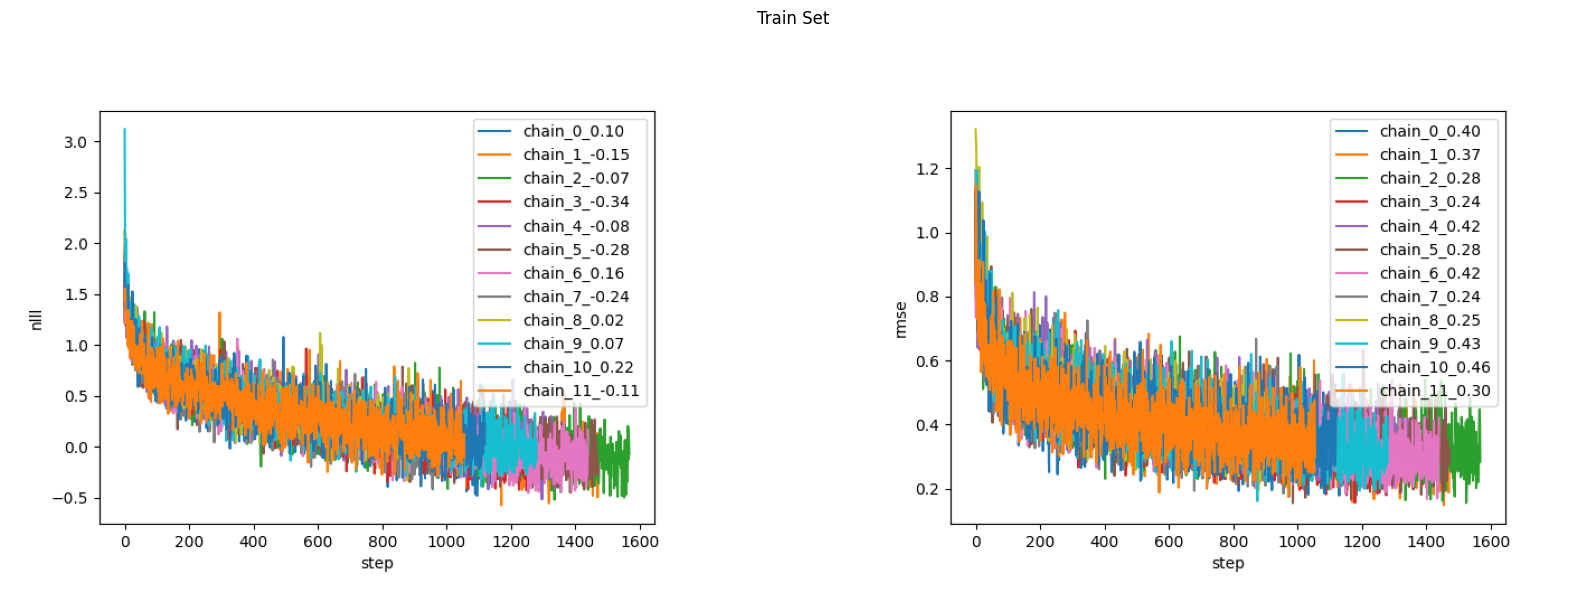

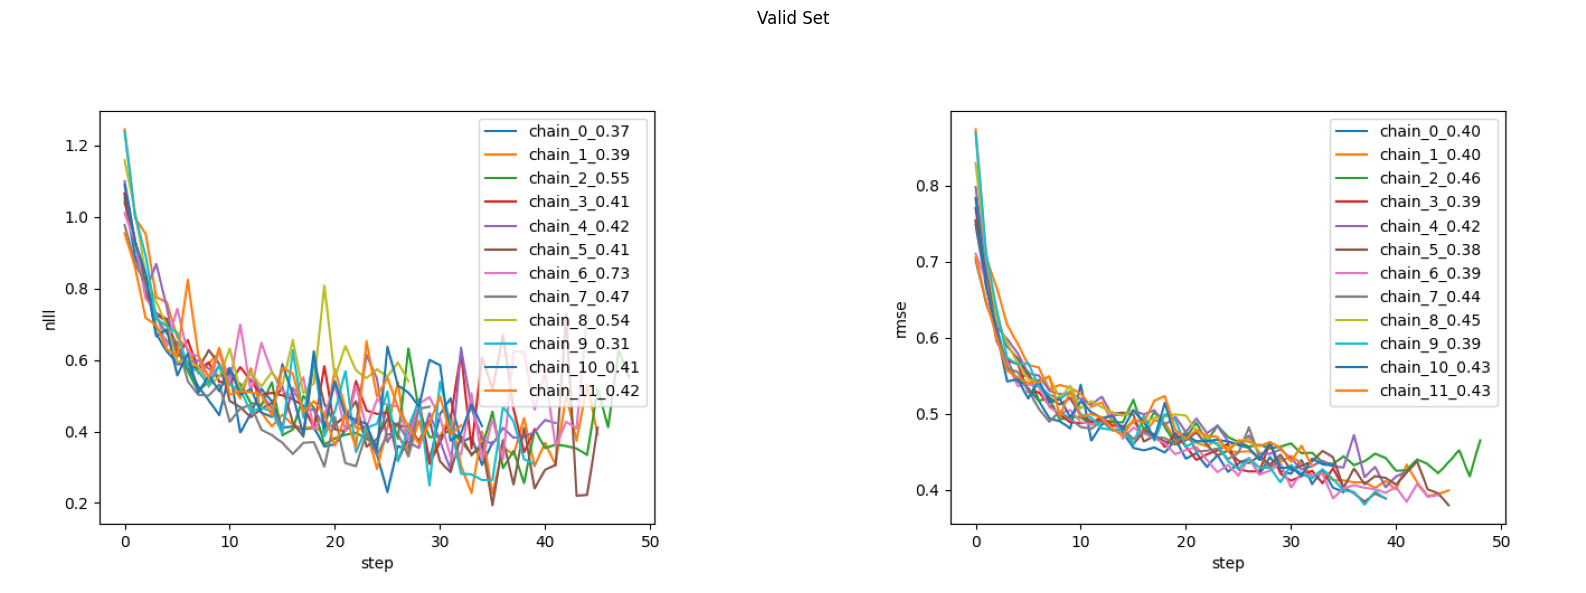

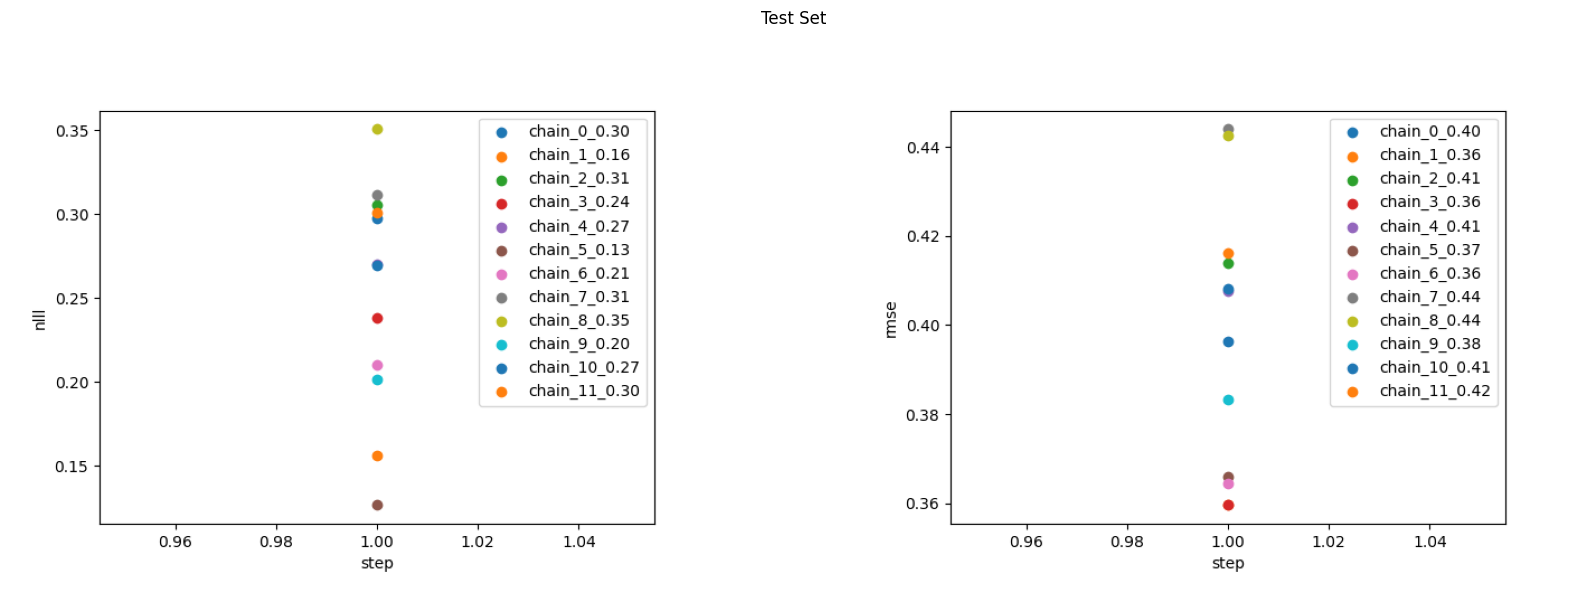

In [8]:
warmstart_dir = DIR / 'warmstart'
files = [warmstart_dir / f for f in os.listdir(warmstart_dir) if f.endswith('.npz')]
params_warmstart = train_utils.load_params_batch(files, tree_path=tree_dir)
if len(files) == 1:
    params_warmstart = jax.tree.map(lambda x: x[None, ...], params_warmstart)
print(f'Number of NaNs:\n{inf_utils.count_nan(params_warmstart)}')
viz.plot_warmstart_results(warmstart_dir=warmstart_dir)
# viz.plot_param_hist(params_warmstart, hist_=10000)

<center><h1>Sampling Warmup</center></h1>

In [9]:
if config.training.sampler.name == Sampler.MCLMC:
    with open(DIR / 'warmup_params.txt', 'r') as f:
        lines = f.readlines()
        step_size = jax.numpy.array([float(x) for x in lines[0].strip().split(',')])
        L = jax.numpy.array([float(x) for x in lines[1].strip().split(',')])

    print('Tuned MCLMC Parameters after warmup:')
    print(f'Step Size: {jax.numpy.mean(step_size):.4f} ± {jax.numpy.std(step_size):.4f}')
    print(f'L: {jax.numpy.mean(L):.4f} ± {jax.numpy.std(L):.4f}')
    metrics['step_size'] = jax.numpy.mean(step_size)
    metrics['L'] = jax.numpy.mean(L)
    metrics['step_size_std'] = jax.numpy.std(step_size)
    metrics['L_std'] = jax.numpy.std(L)

Tuned MCLMC Parameters after warmup:
Step Size: 0.5202 ± 0.0000
L: 137.0610 ± 0.0000


In [10]:
# Limit memory usage
if config.training.sampler.keep_warmup:
    samples_warmup = train_utils.load_samples_from_dir(DIR / 'sampling_warmup', tree_path=tree_dir)
    n_samples = inf_utils.count_samples(samples_warmup)
    n_chains = inf_utils.count_chains(samples_warmup)
    print(f'Loaded {n_chains} chains with {n_samples} warmup samples each')
    print(f'Number of NaNs:\n{inf_utils.count_nan(samples_warmup)}')
    _ = viz.plot_effective_sample_size(samples_warmup)
    viz.plot_param_movement(samples_warmup, random_n=5)
    # viz.plot_param_hist(samples_warmup, hist_limit=10000)
else:
    print('> No warmup samples has been saved.')

> No warmup samples has been saved.


<center><h1>Sampling</center></h1>

In [14]:
samples = train_utils.load_samples_from_dir(DIR / 'samples', tree_path=tree_dir)
n_samples = inf_utils.count_samples(samples)
n_chains = inf_utils.count_chains(samples)
print(f'Loaded {n_chains} chains with {n_samples} samples each')
#mean_ess = viz.plot_effective_sample_size(samples)

Loaded 12 chains with 1000 samples each


### Variance Analysis

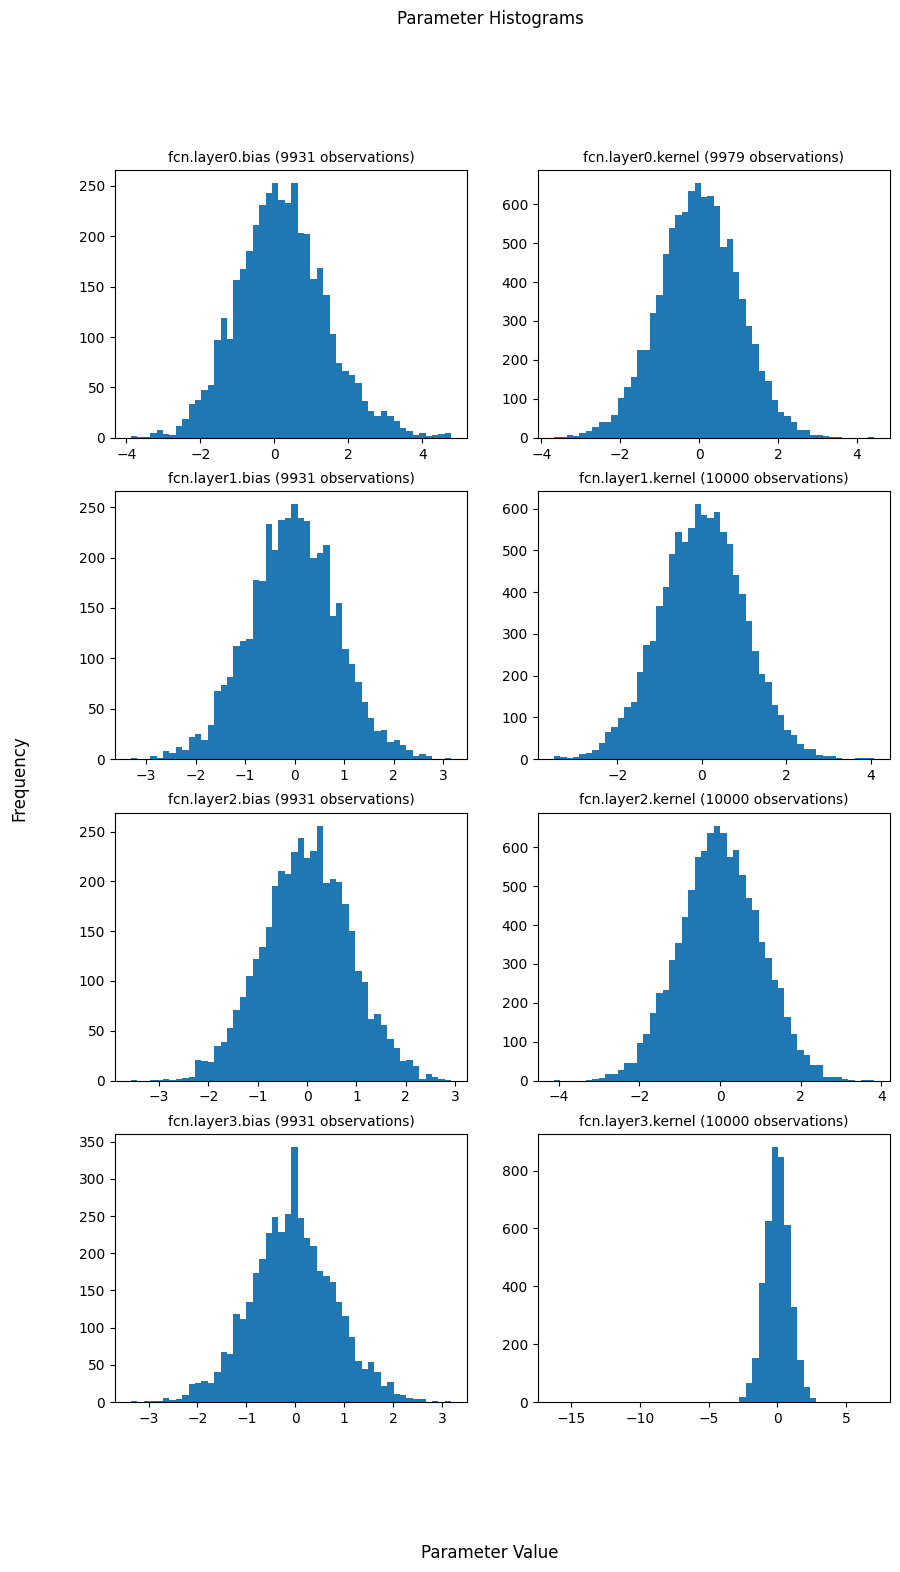

In [15]:
#mean_bcv, mean_wcv = viz.plot_variances(samples)
#mean_crhat = viz.plot_split_chain_r_hat(samples, n_splits=4)
viz.plot_param_hist(samples, hist_limit=10000)

### Visualizing Sampling

In [ ]:
viz.plot_pca(samples, '3d', max_chains=2, max_samples=None, annotate=True)
viz.plot_param_movement(samples, random_n=5)

In [ ]:
# Combine the mean diagnostics into a dataframe and save it
rows = list(mean_ess.keys())
columns = ['ess', 'bcv', 'wcv', 'crhat']
df = pd.DataFrame(index=rows, columns=columns)
df['ess'] = mean_ess.values()
df['bcv'] = mean_bcv.values()
df['wcv'] = mean_wcv.values()
df['crhat'] = mean_crhat.values()
df.to_csv(DIR / 'diagnostics.csv')

<center><h1>DE vs BDE Performance</center></h1>

In [16]:
# Extra arguments needed in forward pass of the flax model
kwargs = {}

# Setup Loader
if config.data.data_type == DatasetType.TABULAR:
    loader = ds.TabularLoader(
        config.data,
        rng=config.jax_rng,
        target_len=config.data.target_len
    )
elif config.data.data_type == DatasetType.TEXT:
    from src.dataset.utils import CustomBPETokenizer
    tokenizer = CustomBPETokenizer(
        config.model.context_len, max_vocab_size=config.model.vocab_size
    )
    loader = ds.TextLoader(
        config=config.data,
        rng=config.jax_rng,
        tokenizer=tokenizer,
        context_len=config.model.context_len,
        omit_freq=100,
    )
    kwargs = {'train': False, 'pad_id': tokenizer.padding_token_id}
elif config.data.data_type == DatasetType.IMAGE:
    loader = ds.ImageLoader(
        config.data,
        rng=config.jax_rng,
    )
else:
    raise NotImplementedError(f'DatasetType {config.data.data_type} not supported yet.')

random_input = next(loader.iter('train', 1))['feature']

print(f'> Loader:\n{loader}')
module = config.get_flax_model()

print('> Parameter Overview:\n')
print(module.tabulate(config.jax_rng, x=random_input, **kwargs))

with open(DIR / 'samples/info.pkl', 'rb') as f:
    info = pickle.load(f)

accept_rate = info.get("acceptance_rate", None)
integration_steps = info.get("num_integration_steps", None)
if accept_rate is not None:
    print("Average acceptance rate: ", accept_rate.mean())
    metrics['acceptance_rate'] = accept_rate.mean()
if integration_steps is not None:
    print("Average ingeration steps: ", integration_steps.mean())
    metrics['integration_steps'] = integration_steps.mean()

> Loader:
TabularLoader:
 | Data: airfoil
 | Task: regr
 | Features: 5
 | Target Length: 1
 | Train: 1052
 | Valid: 150
 | Test: 301
> Parameter Overview:


                                  FCN Summary                                   
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ path       ┃ module         ┃ inputs         ┃ outputs       ┃ params        ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│            │ FCN            │ x:             │ float32[1,64] │               │
│            │                │ float32[1,5]   │               │               │
├────────────┼────────────────┼────────────────┼───────────────┼───────────────┤
│ fcn        │ FullyConnected │ float32[1,5]   │ float32[1,64] │               │
├────────────┼────────────────┼────────────────┼───────────────┼───────────────┤
│ fcn/layer0 │ Dense          │ float32[1,5]   │ float32[1,64] │ bias:         │
│            │                │  

In [17]:
module

FCN(
    # attributes
    config = FCNConfig(model='FCN', hidden_structure=[64, 64, 64, 64], activation=<Activation.RELU: 'relu'>, use_bias=True)
)

In [18]:
features = loader.test_x # (B x F)
labels = loader.test_y # (B x T)
print("Test Set: Feature and Label have shapes: ", features.shape, labels.shape)

Test Set: Feature and Label have shapes:  (301, 5) (301,)


In [ ]:
logits, metrics = evaluate_de(
    params=params_warmstart,
    module=module,
    features=features,
    labels=labels,
    task=config.data.task,
    batch_size=config.training.warmstart.batch_size,
    verbose=False,
    metrics_dict=metrics,
    n_samples=config.training.sampler.n_samples // config.training.sampler.n_thinning,
    rng_key=config.jax_rng,
    nominal_coverages=[0.5, 0.75, 0.9, 0.95],
    **kwargs
)

In [20]:
mem_cap = 4 * 1024 ** 3 # 4 GB
mem_usage = (
    inf_utils.get_mem_size(samples) / n_chains
    + inf_utils.get_mem_size(features)
    + inf_utils.get_mem_size(labels)
)
overhead_unit = mem_usage * 10 # estimatation

batch_size = max(1, (mem_cap - overhead_unit) // mem_usage)
if batch_size > labels.shape[0]:
    batch_size = None
print(f'> Batch size for evaluation: {batch_size}\n')

> Batch size for evaluation: 73.0



In [22]:
logits, metrics = evaluate_bde(
    params=samples,
    module=module,
    features=features,
    labels=labels,
    task=config.data.task,
    batch_size=batch_size,
    verbose=False,
    metrics_dict=metrics,
    nominal_coverages=[0.5, 0.75, 0.9, 0.95],
    **kwargs
)

Bayesian Deep Ensemble Performance | LPPD: -12.374, RMSE: 11899.5605
__________________________________________________
Chain 0 | LPPD: nan, RMSE: nan
Chain 1 | LPPD: -13.102, RMSE: 23152.2598
Chain 2 | LPPD: -12.801, RMSE: 26698.5762
Chain 3 | LPPD: nan, RMSE: nan
Chain 4 | LPPD: -12.725, RMSE: 25607.4062
Chain 5 | LPPD: nan, RMSE: nan
Chain 6 | LPPD: nan, RMSE: nan
Chain 7 | LPPD: nan, RMSE: nan
Chain 8 | LPPD: nan, RMSE: nan
Chain 9 | LPPD: nan, RMSE: nan
Chain 10 | LPPD: nan, RMSE: nan
Chain 11 | LPPD: -12.590, RMSE: 22641.8047
__________________________________________________
Calibration Error: 0.2850
Coverage for 0.5: 1.0000
Coverage for 0.75: 1.0000
Coverage for 0.9: 1.0000
Coverage for 0.95: 1.0000


In [ ]:
# LPPD over the samples
viz.plot_lppd(logits, labels, config.data.task)

In [ ]:
# save metrics
with open(DIR / 'metrics.pkl', 'wb') as f:
    pickle.dump(metrics, f)

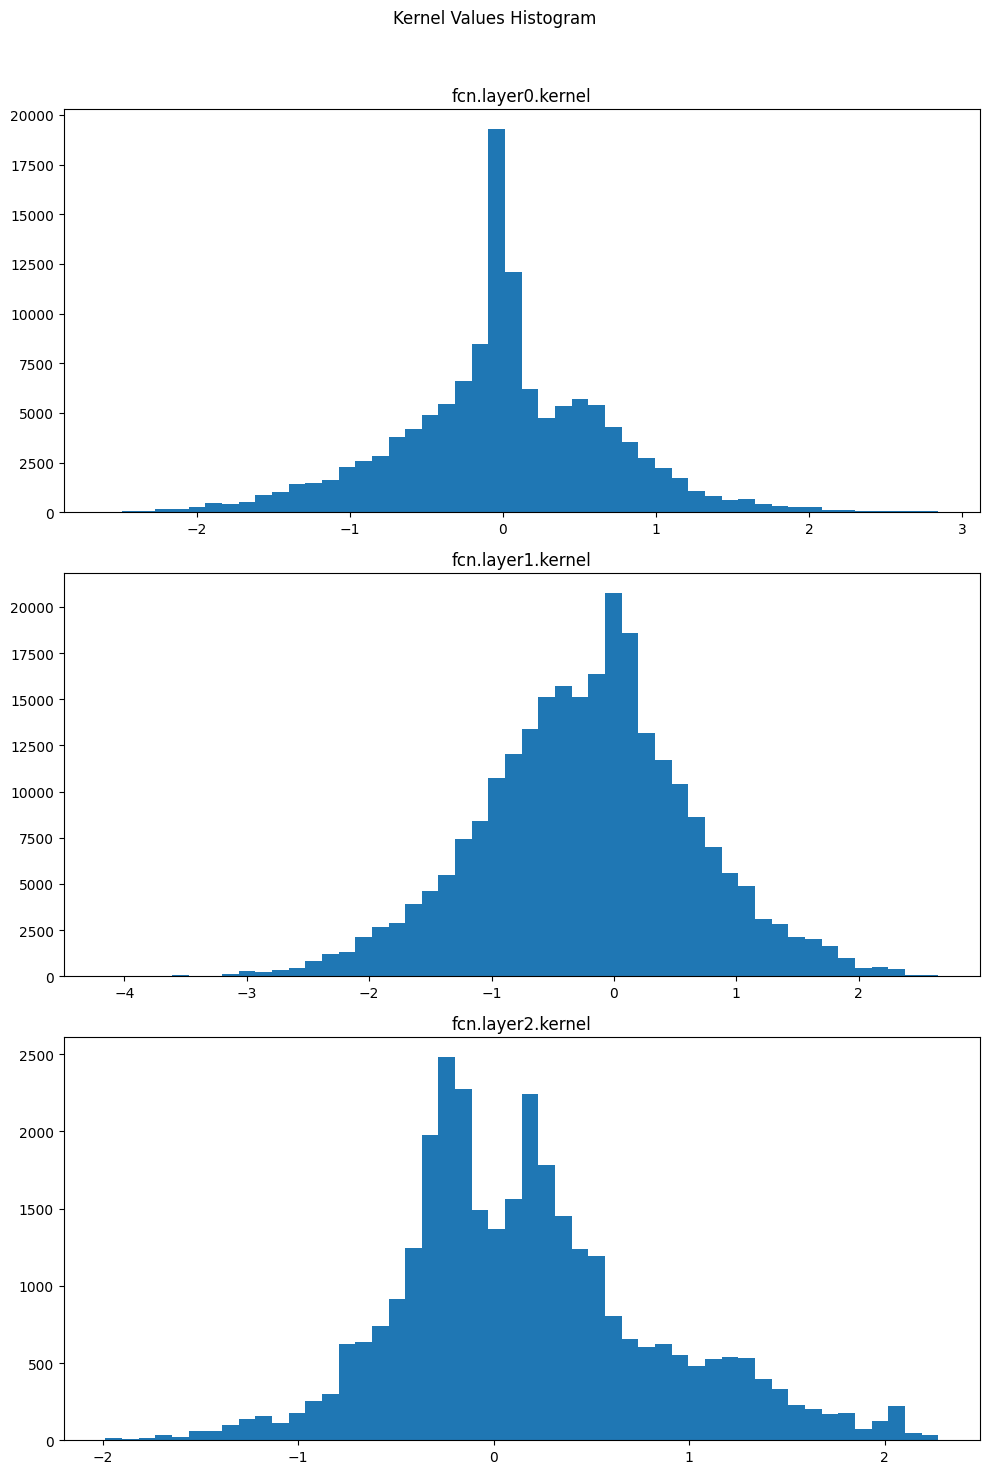

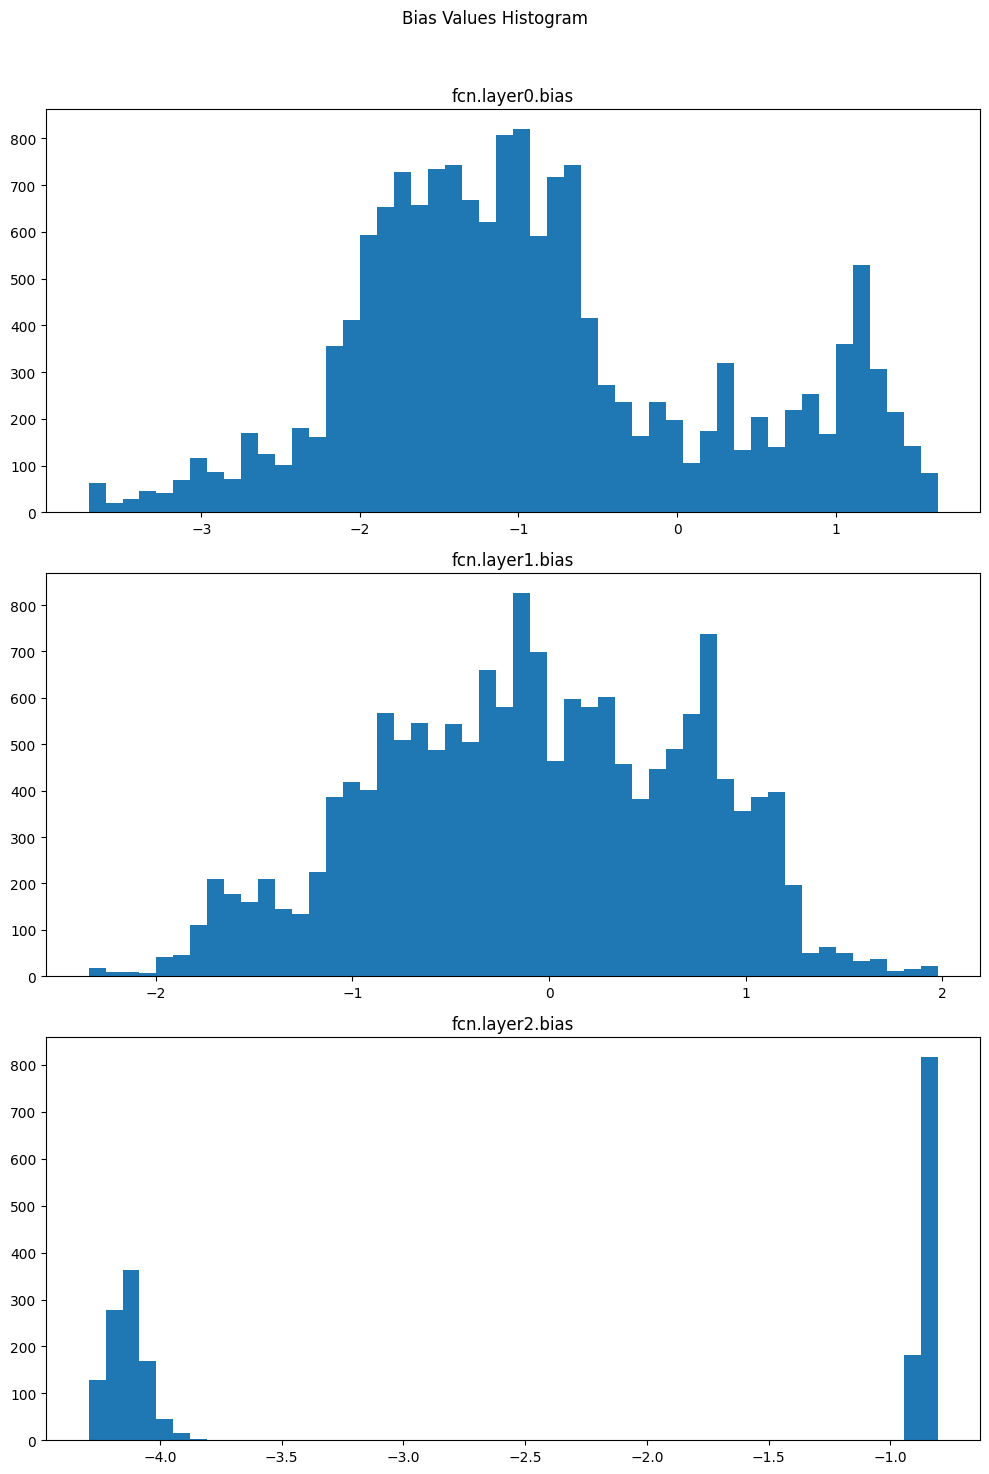

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
npz_files = [f for f in os.listdir('./results/repl_uci/mclmc_energy_true/samples/0') if f.endswith('.npz')]
# Initialize dictionaries to store all kernel and bias values
all_kernel_values = {'fcn.layer0.kernel': [], 'fcn.layer1.kernel': [], 'fcn.layer2.kernel': []}
all_bias_values = {'fcn.layer0.bias': [], 'fcn.layer1.bias': [], 'fcn.layer2.bias': []}

# Collect values from all samples
for npz in npz_files:
    npz_file = np.load(f'./results/repl_uci/mclmc_energy_true/samples/0/{npz}')
    for layer in ['fcn.layer0', 'fcn.layer1', 'fcn.layer2']:
        all_kernel_values[f'{layer}.kernel'].extend(npz_file[f'{layer}.kernel'].flatten())
        all_bias_values[f'{layer}.bias'].extend(npz_file[f'{layer}.bias'].flatten())

# Plot kernel histograms
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
fig.suptitle('Kernel Values Histogram')
for i, layer in enumerate(['fcn.layer0.kernel', 'fcn.layer1.kernel', 'fcn.layer2.kernel']):
    axes[i].hist(all_kernel_values[layer], bins=50)
    axes[i].set_title(layer)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Plot bias histograms
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
fig.suptitle('Bias Values Histogram')
for i, layer in enumerate(['fcn.layer0.bias', 'fcn.layer1.bias', 'fcn.layer2.bias']):
    axes[i].hist(all_bias_values[layer], bins=50)
    axes[i].set_title(layer)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show() 


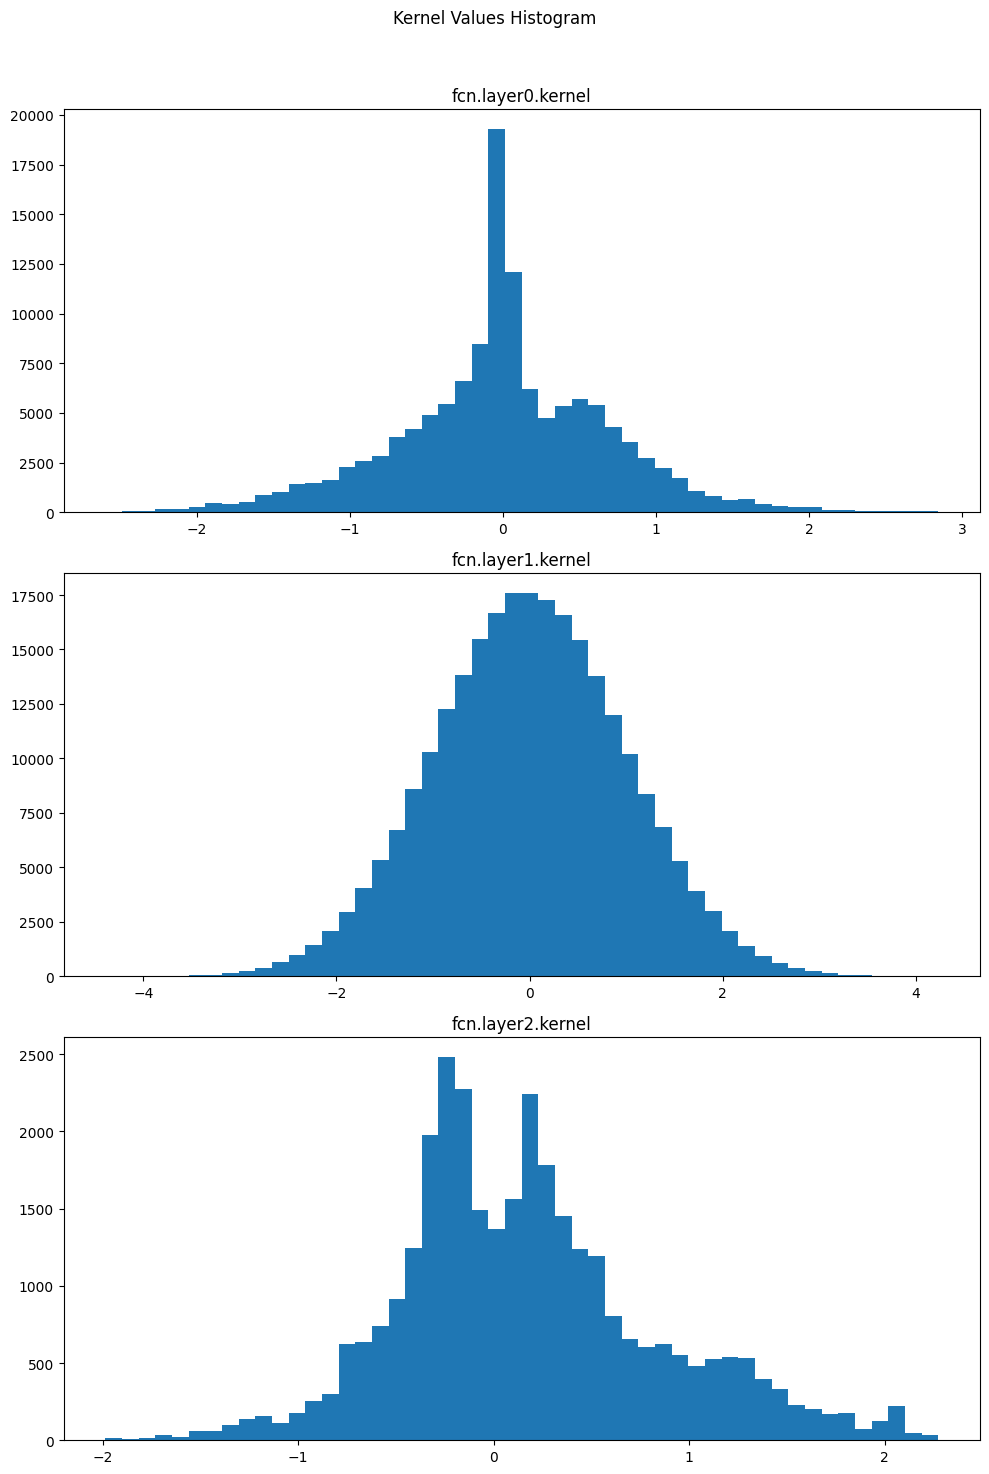

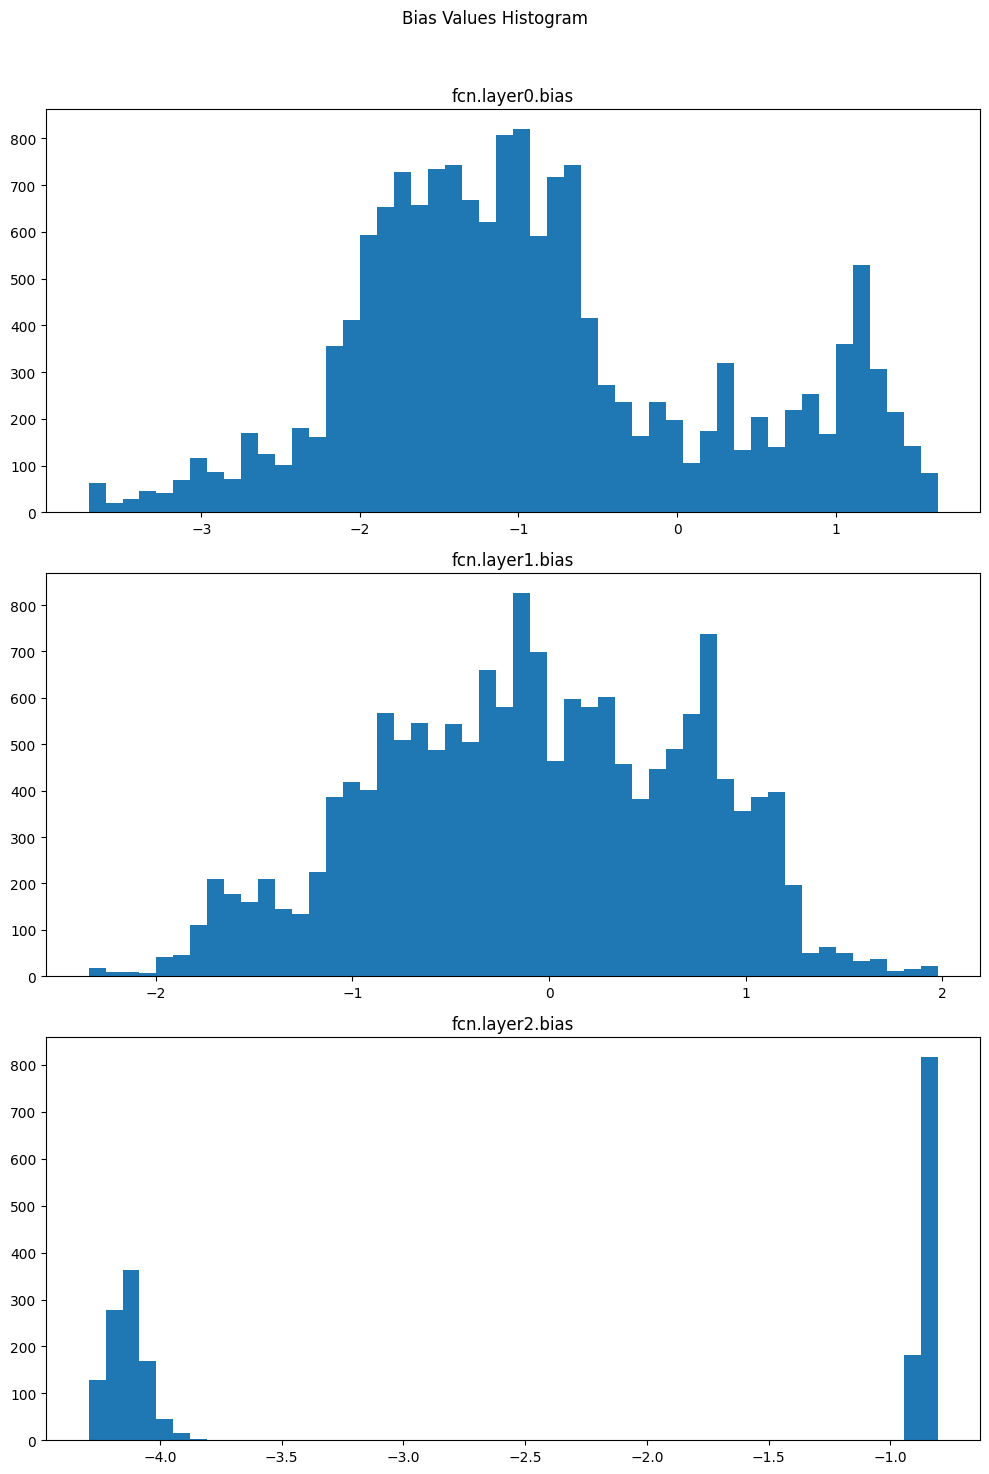

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
npz_files = [f for f in os.listdir('./results/repl_uci/mclmc_energy_sample_prior/samples/0') if f.endswith('.npz')]
# Initialize dictionaries to store all kernel and bias values
all_kernel_values = {'fcn.layer0.kernel': [], 'fcn.layer1.kernel': [], 'fcn.layer2.kernel': []}
all_bias_values = {'fcn.layer0.bias': [], 'fcn.layer1.bias': [], 'fcn.layer2.bias': []}

# Collect values from all samples
for npz in npz_files:
    npz_file = np.load(f'./results/repl_uci/mclmc_energy_sample_prior/samples/0/{npz}')
    for layer in ['fcn.layer0', 'fcn.layer1', 'fcn.layer2']:
        all_kernel_values[f'{layer}.kernel'].extend(npz_file[f'{layer}.kernel'].flatten())
        all_bias_values[f'{layer}.bias'].extend(npz_file[f'{layer}.bias'].flatten())

# Plot kernel histograms
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
fig.suptitle('Kernel Values Histogram')
for i, layer in enumerate(['fcn.layer0.kernel', 'fcn.layer1.kernel', 'fcn.layer2.kernel']):
    axes[i].hist(all_kernel_values[layer], bins=50)
    axes[i].set_title(layer)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Plot bias histograms
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
fig.suptitle('Bias Values Histogram')
for i, layer in enumerate(['fcn.layer0.bias', 'fcn.layer1.bias', 'fcn.layer2.bias']):
    axes[i].hist(all_bias_values[layer], bins=50)
    axes[i].set_title(layer)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show() 


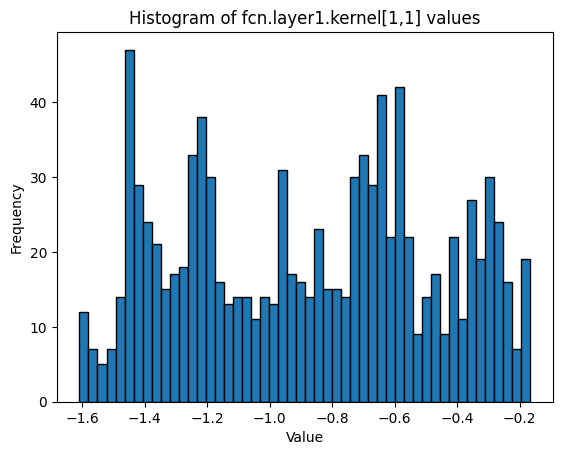

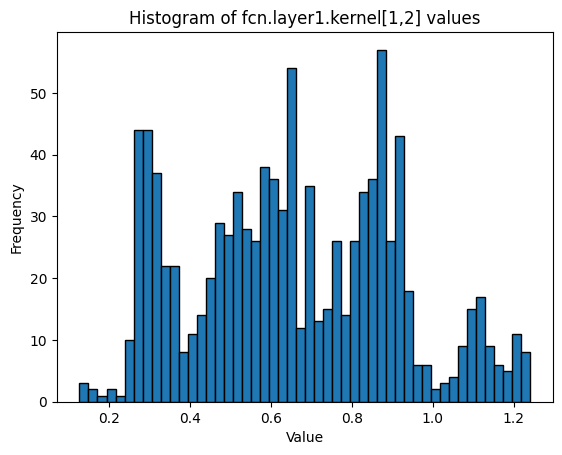

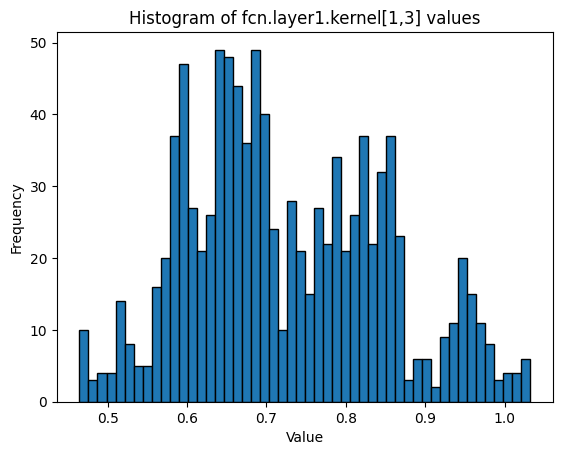

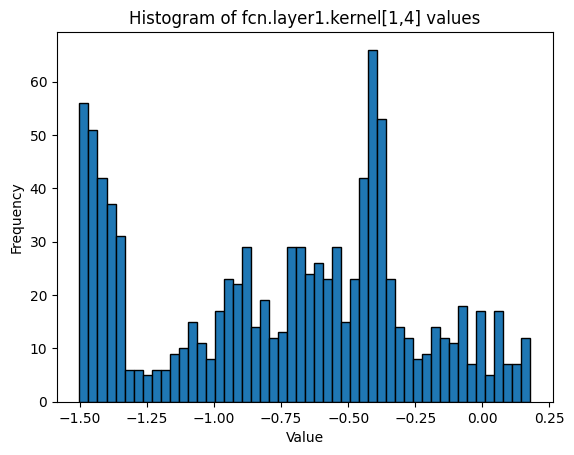

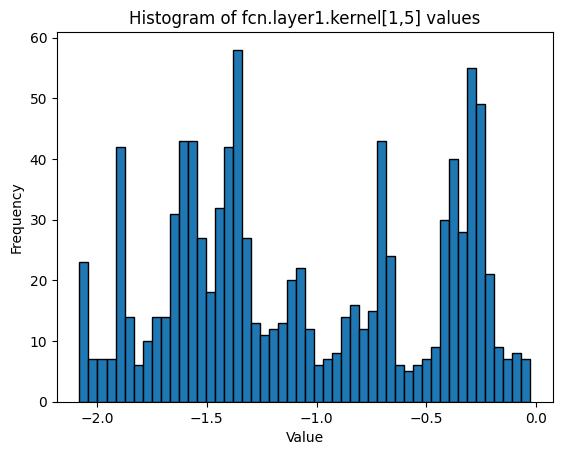

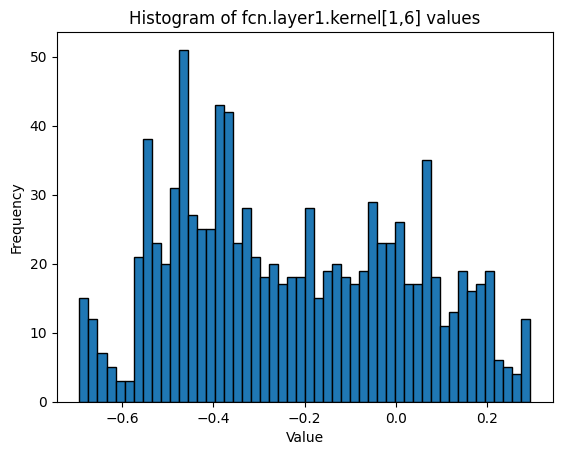

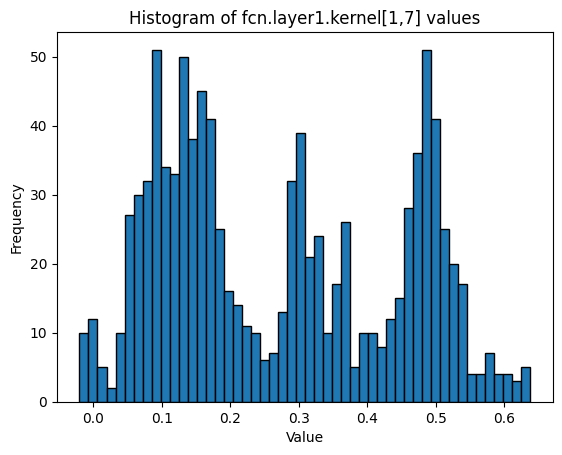

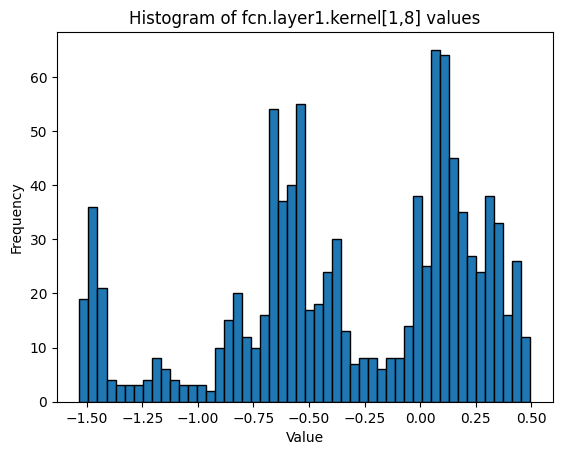

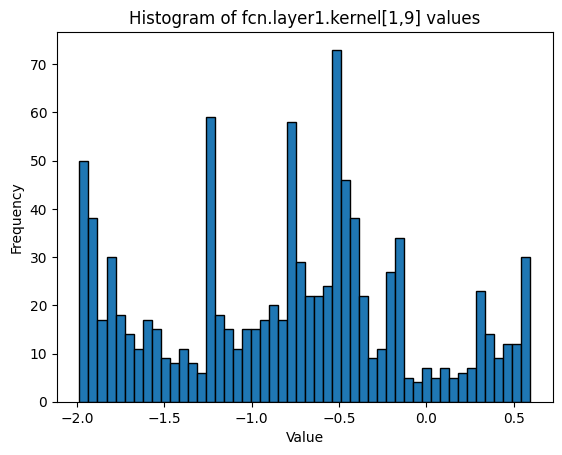

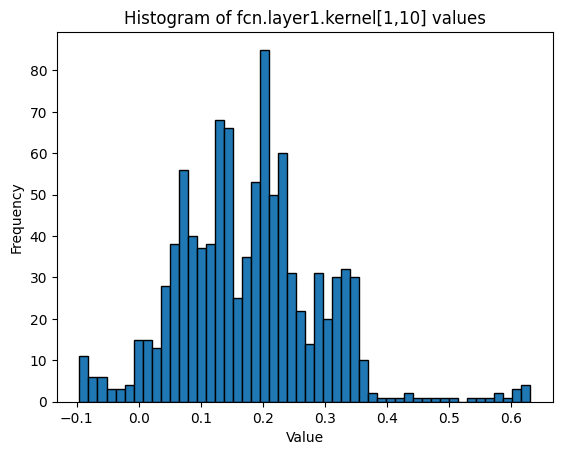

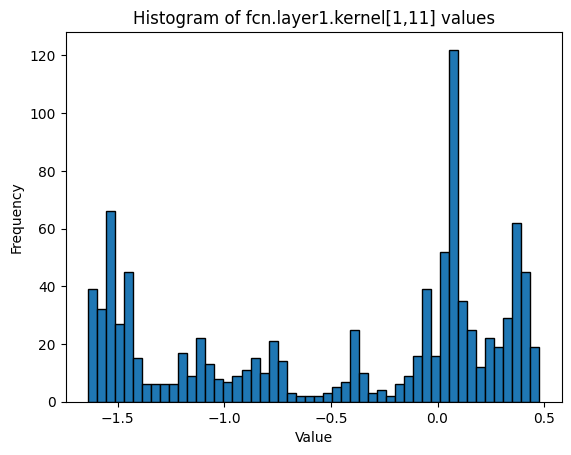

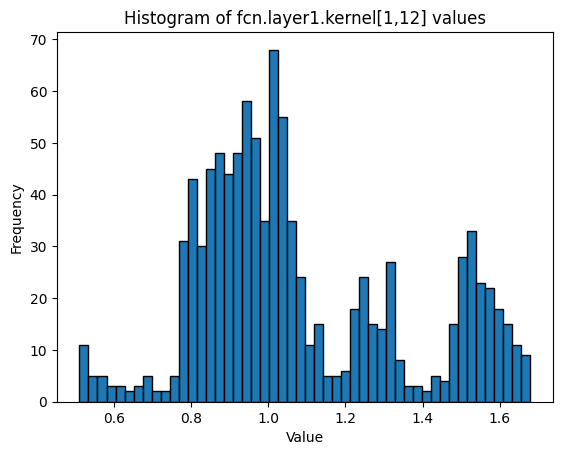

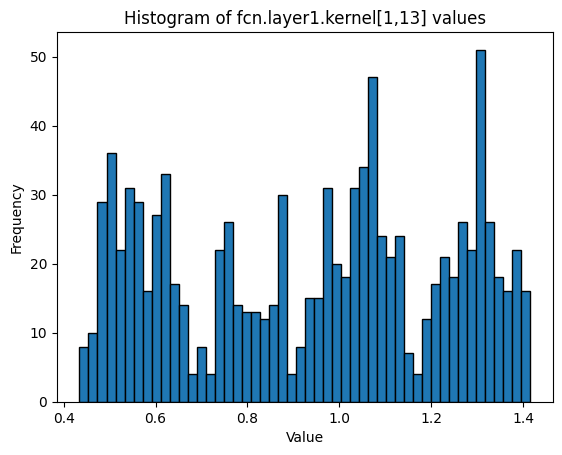

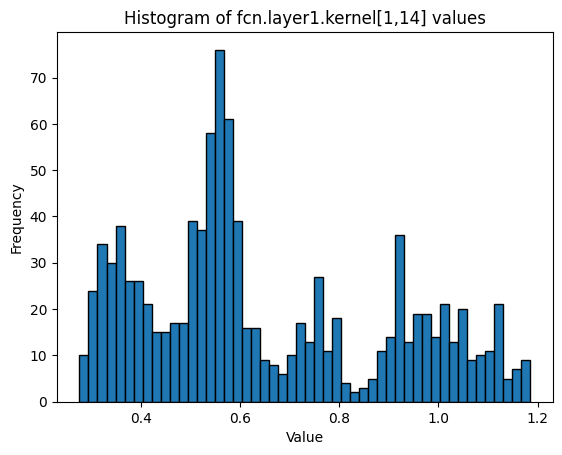

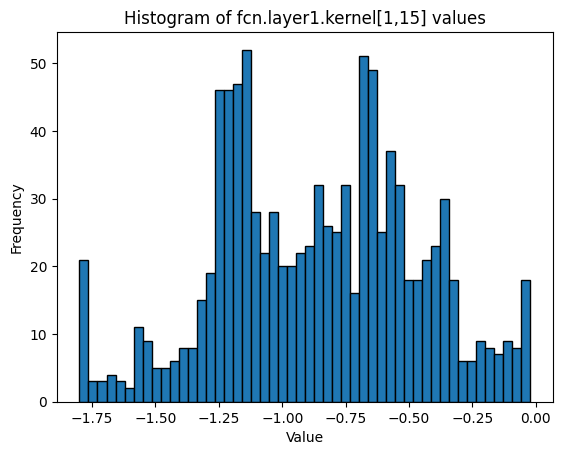

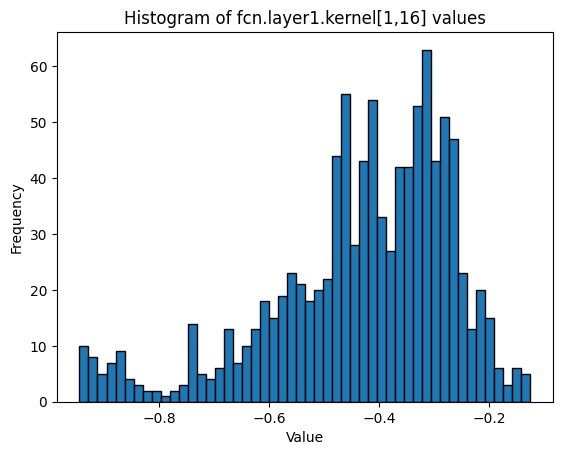

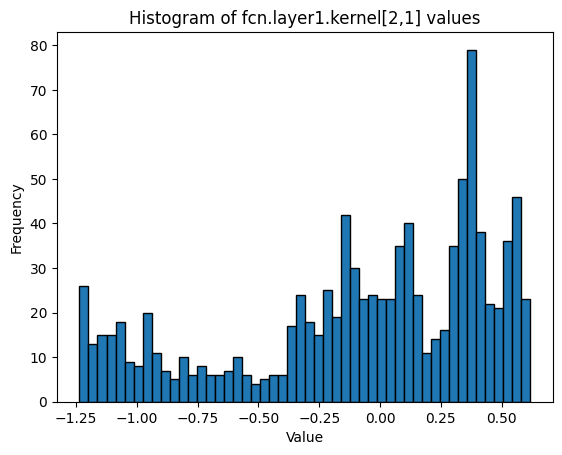

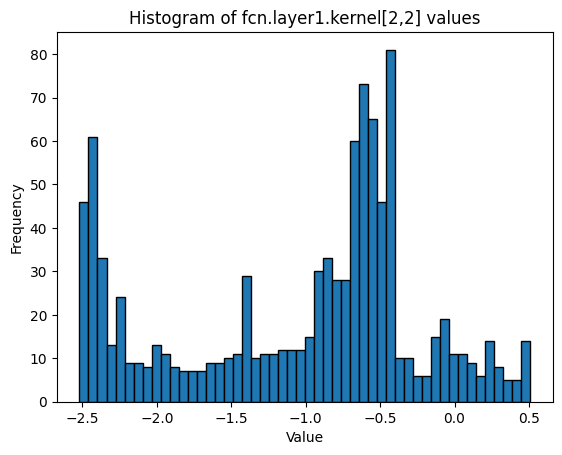

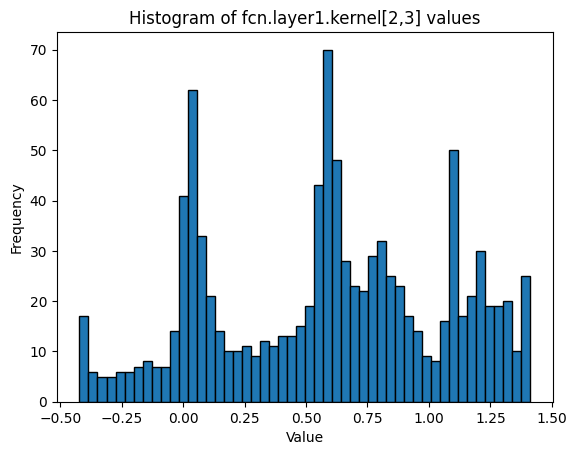

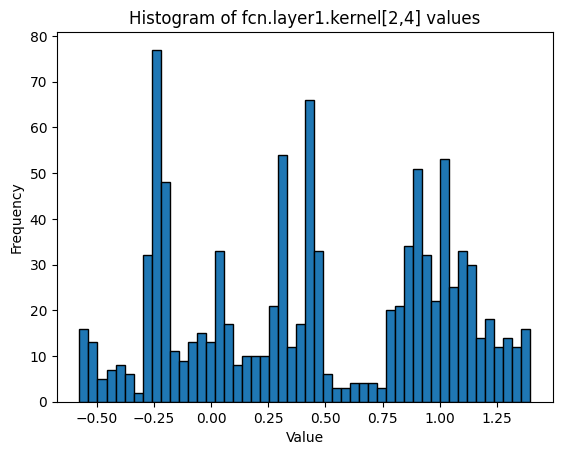

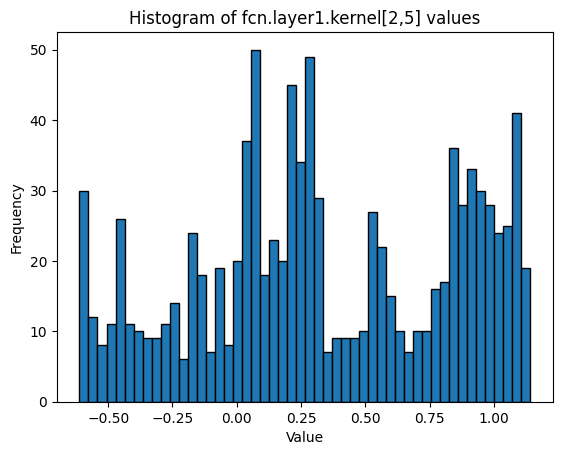

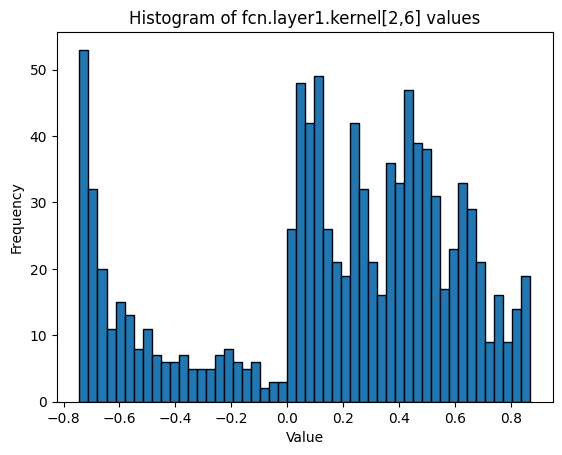

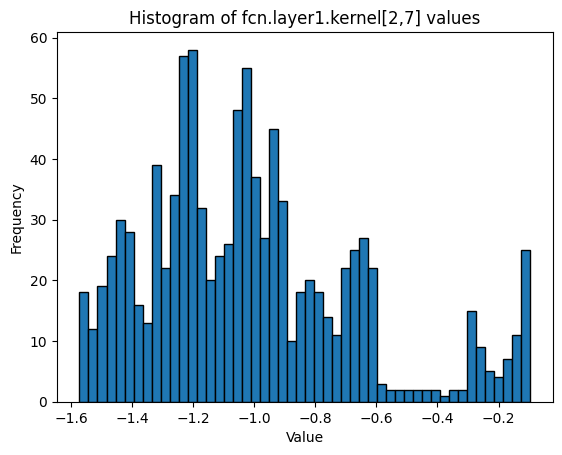

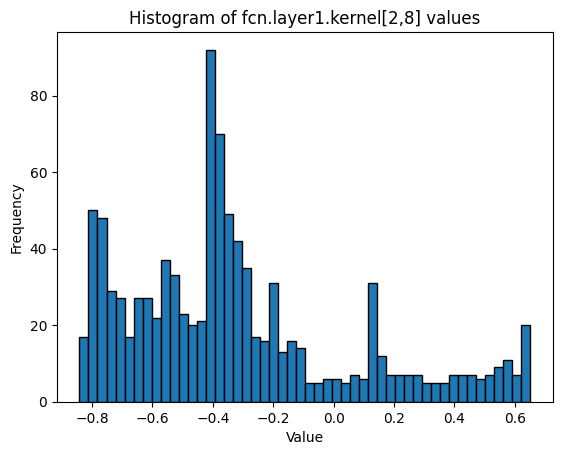

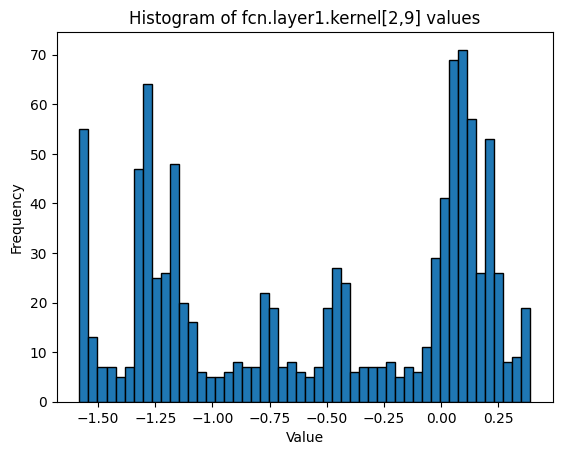

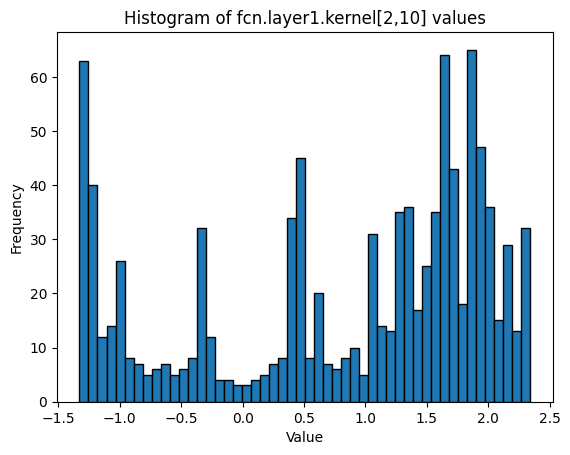

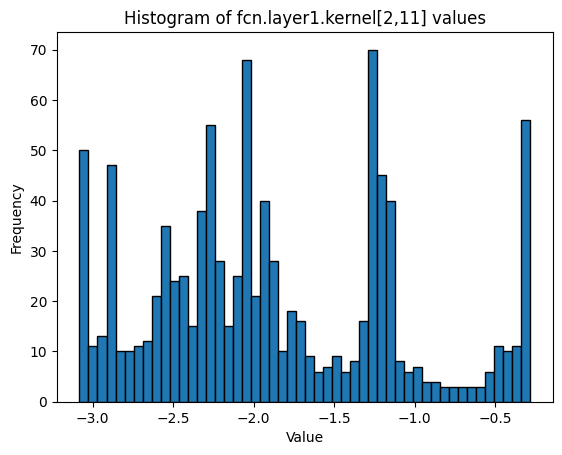

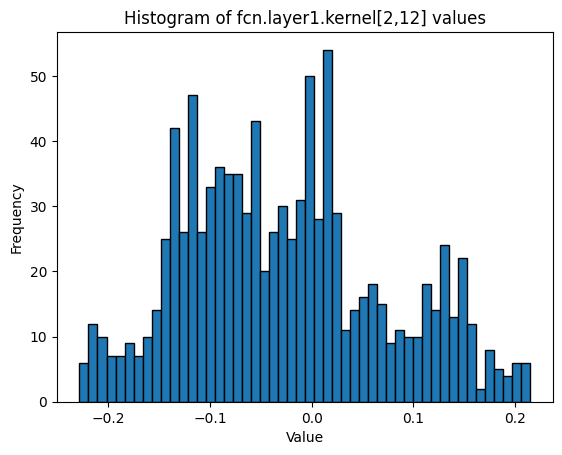

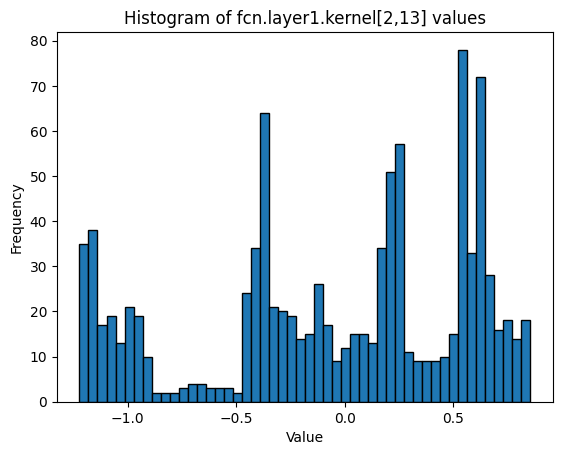

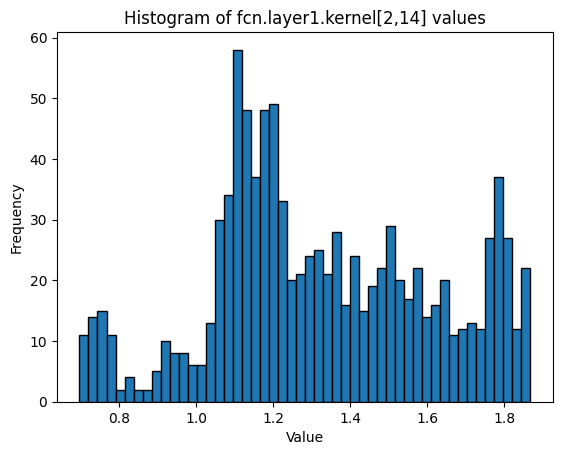

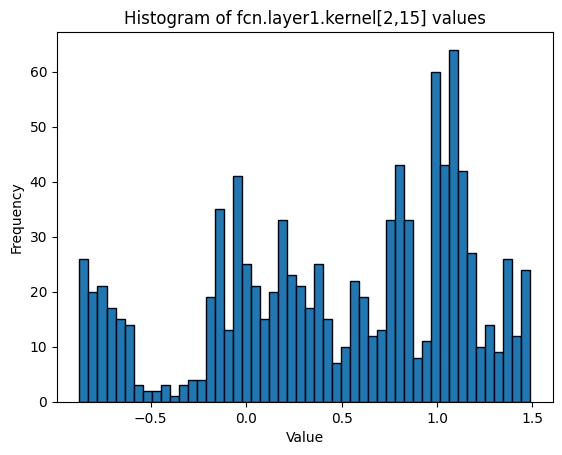

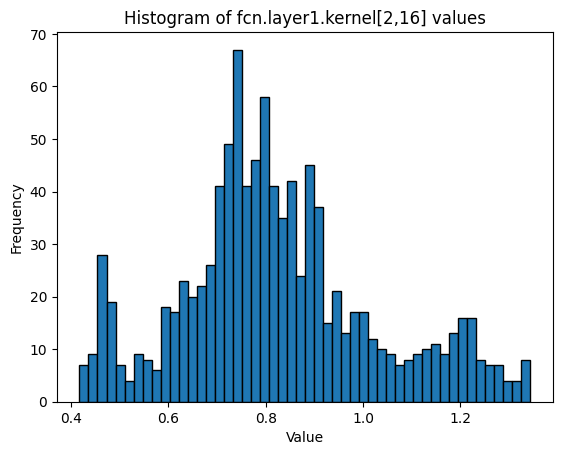

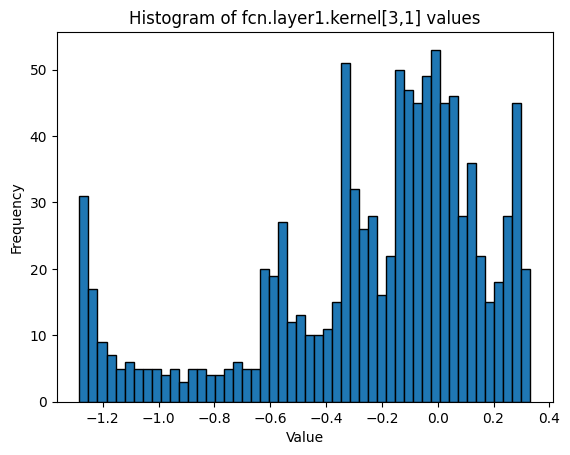

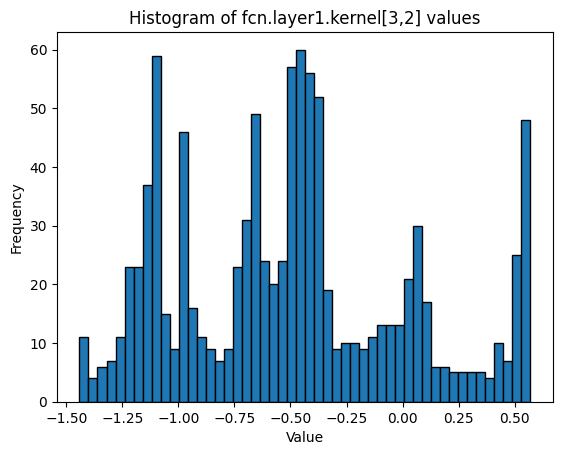

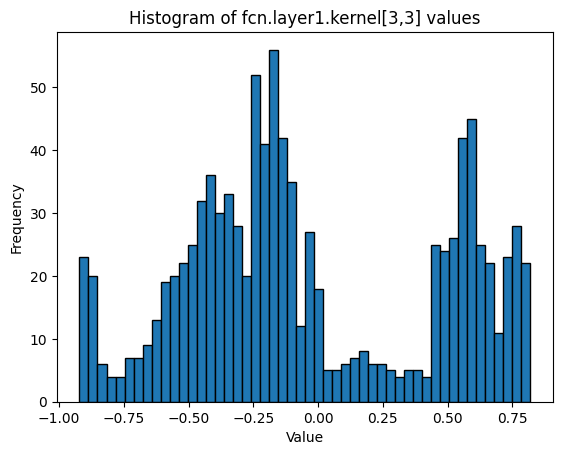

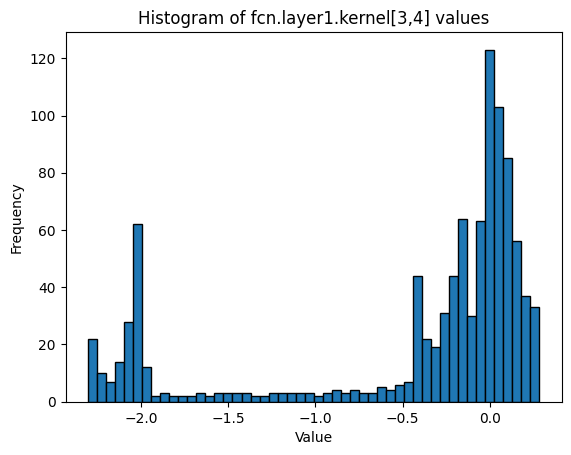

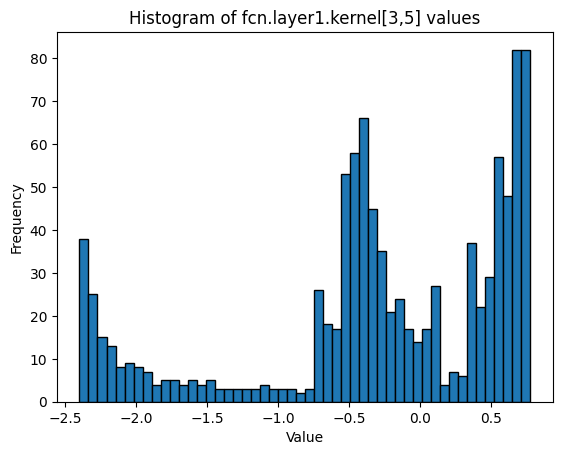

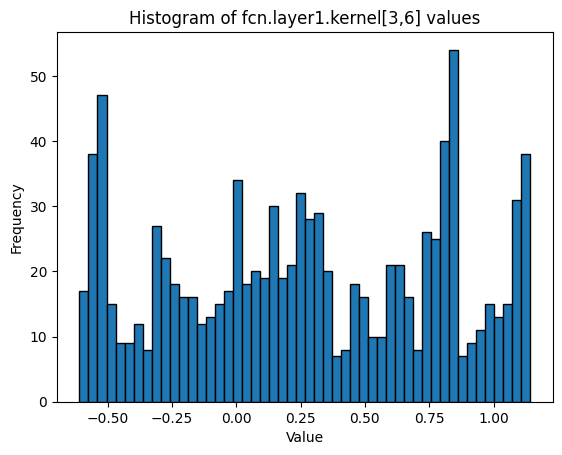

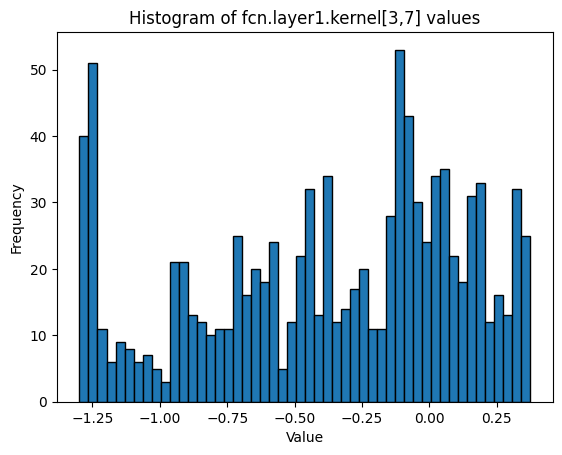

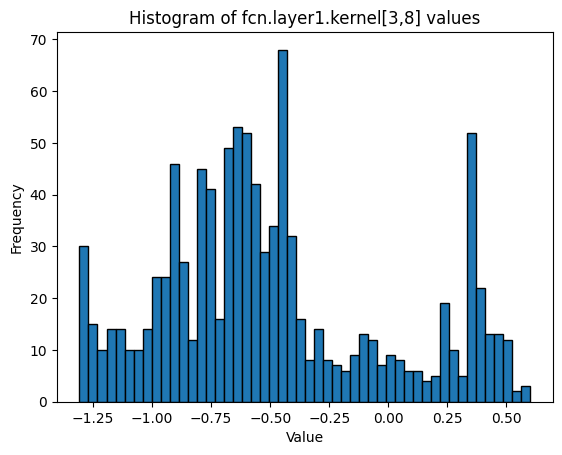

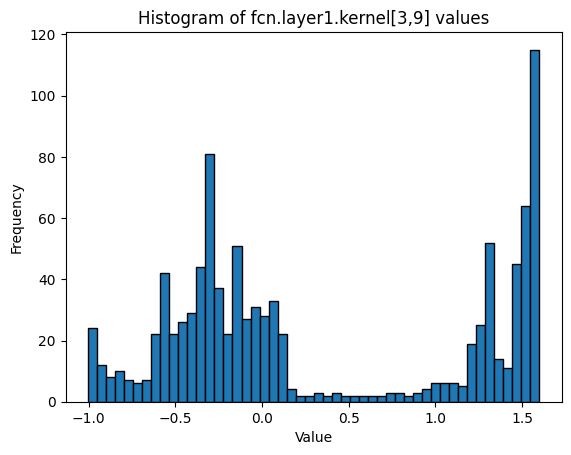

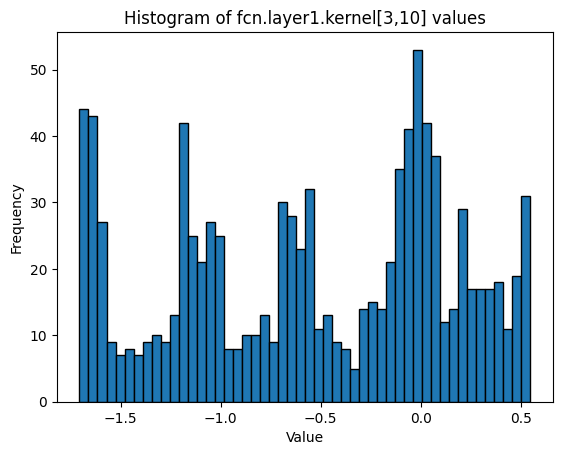

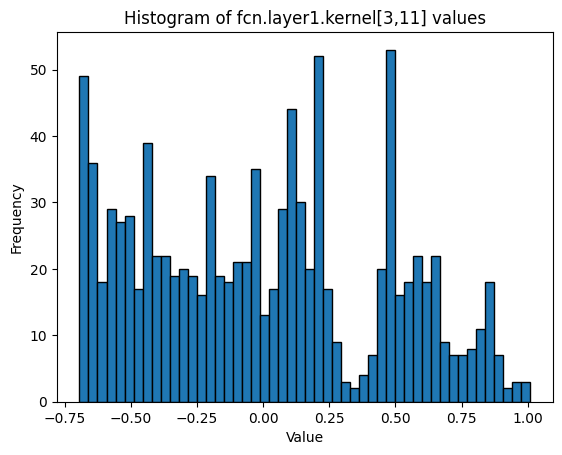

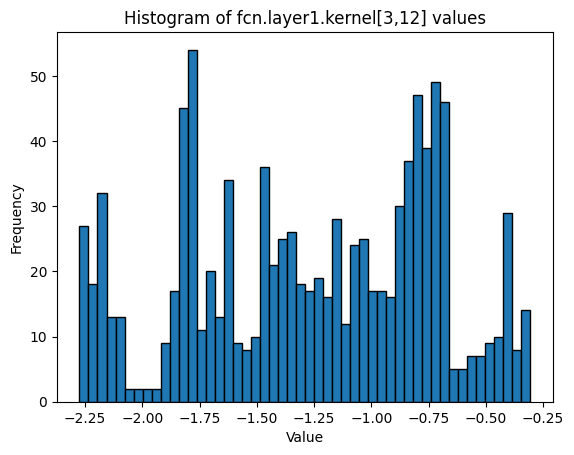

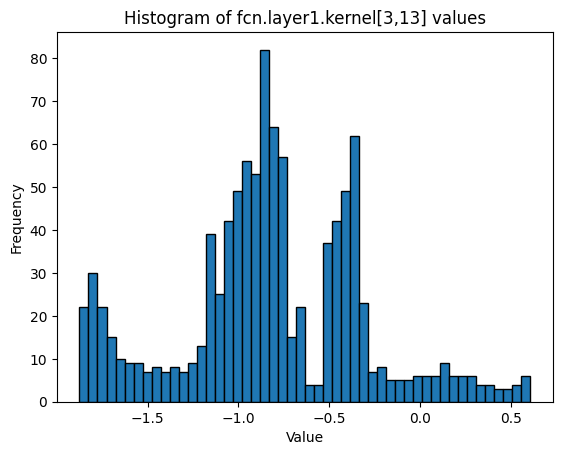

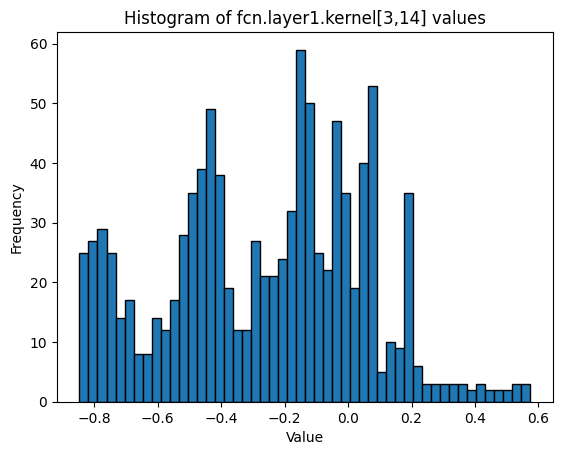

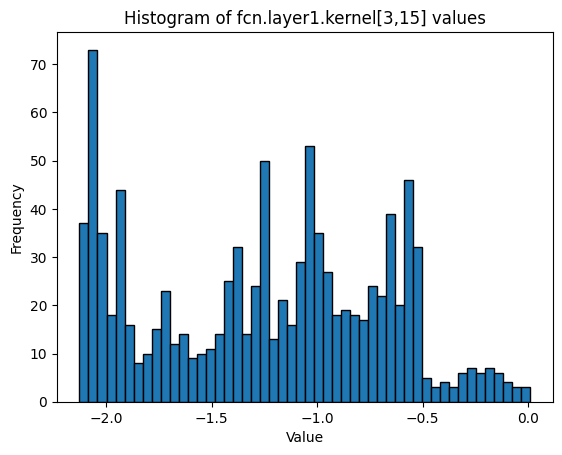

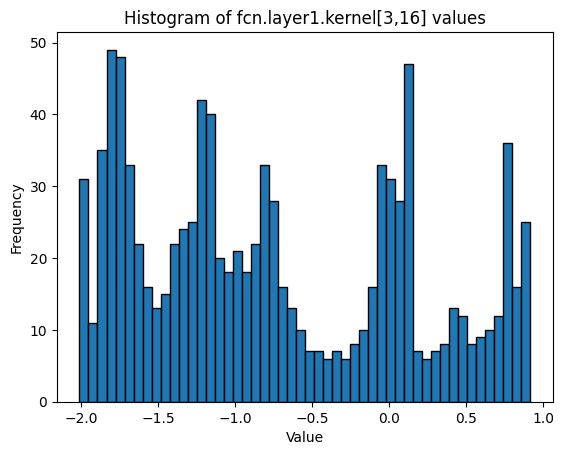

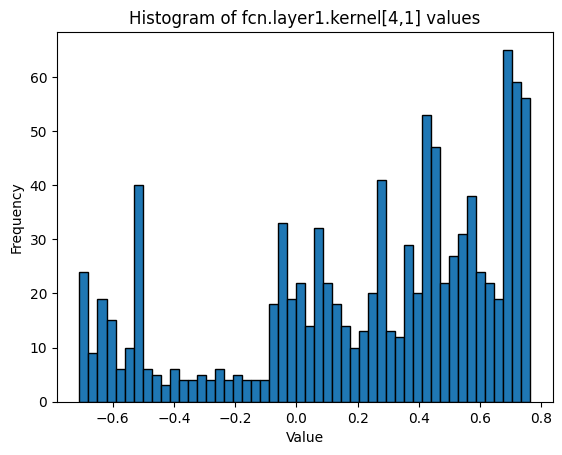

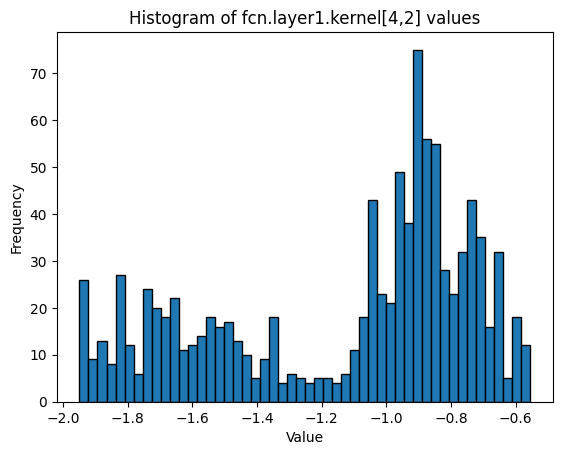

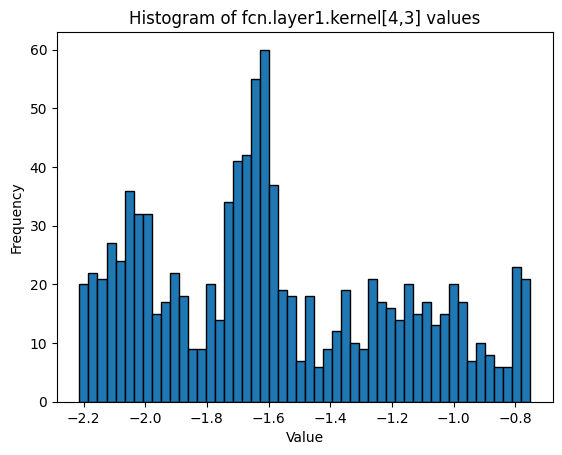

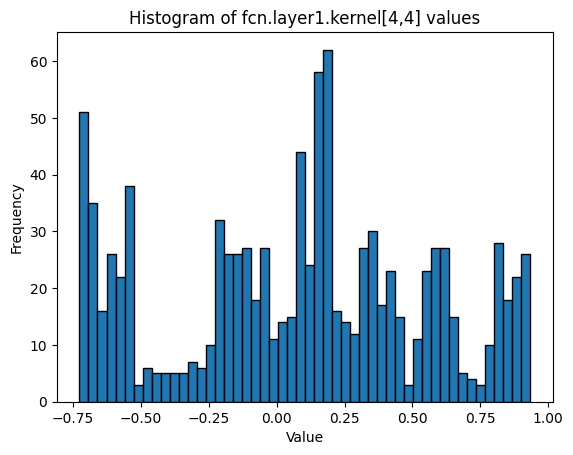

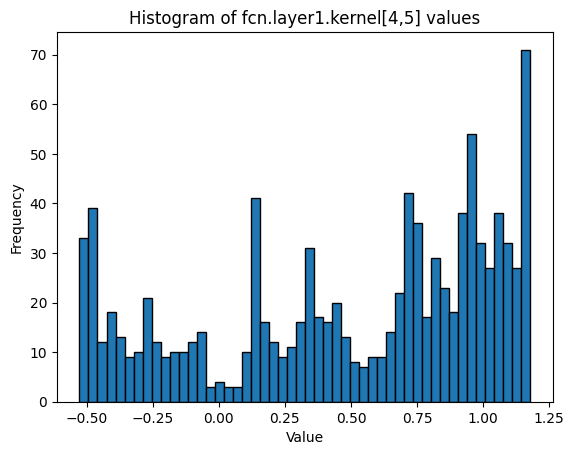

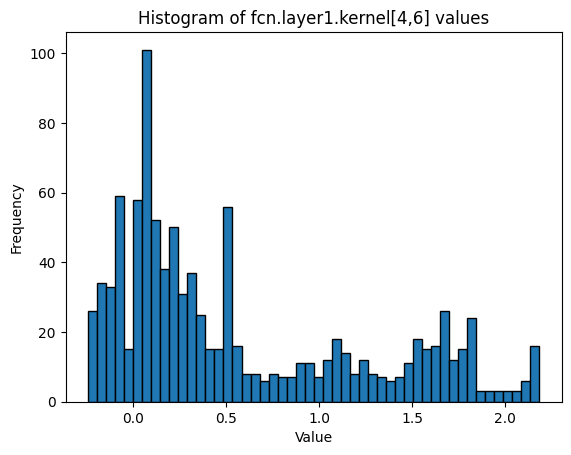

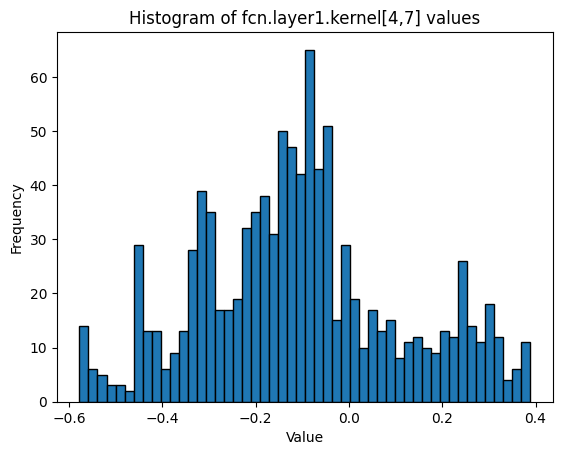

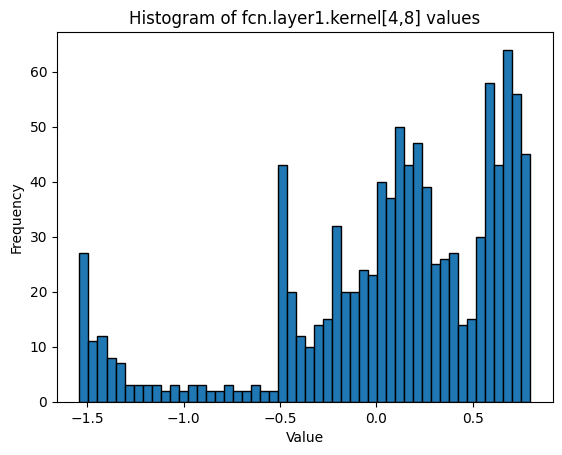

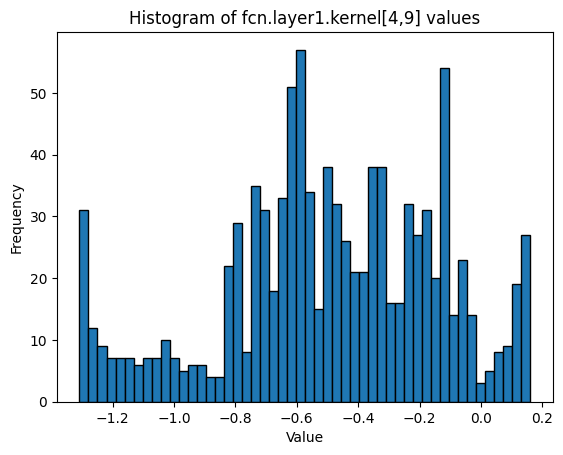

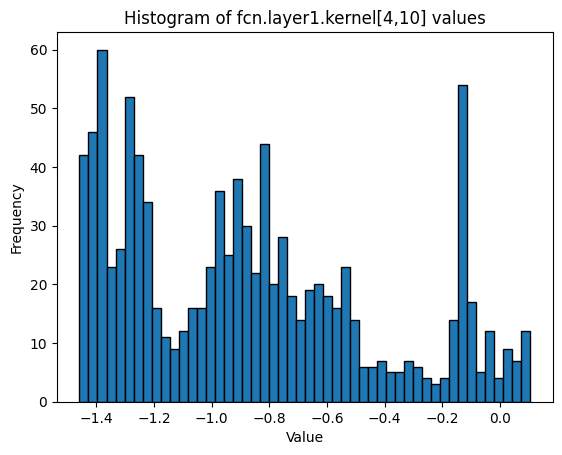

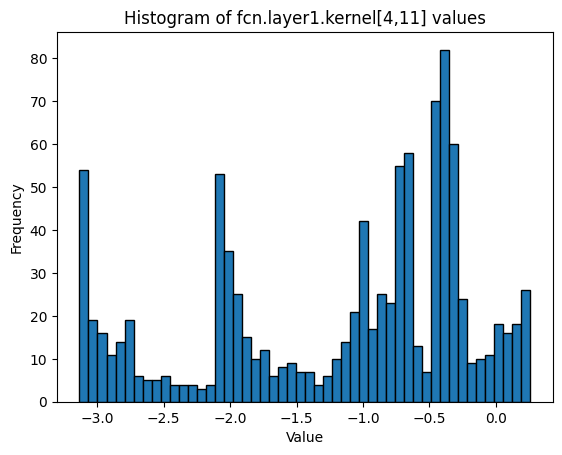

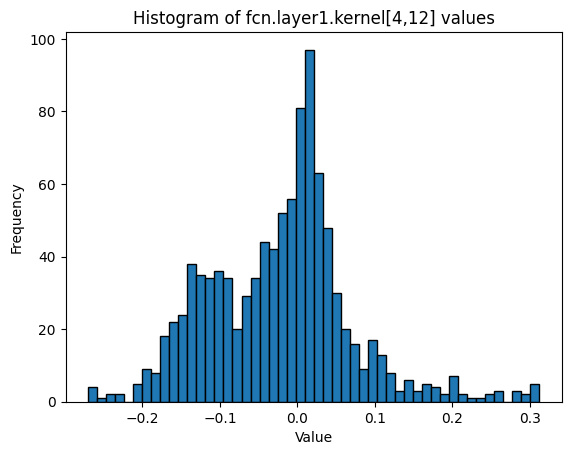

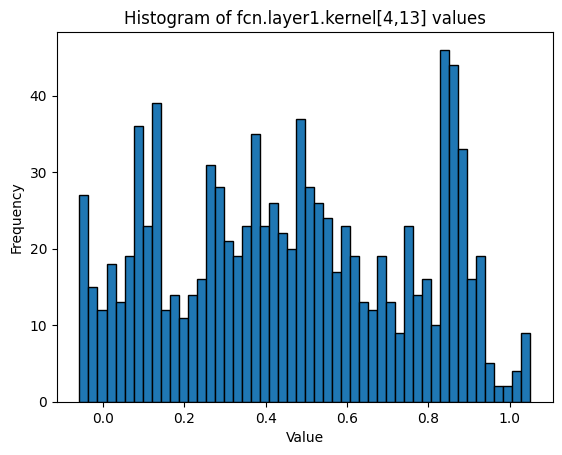

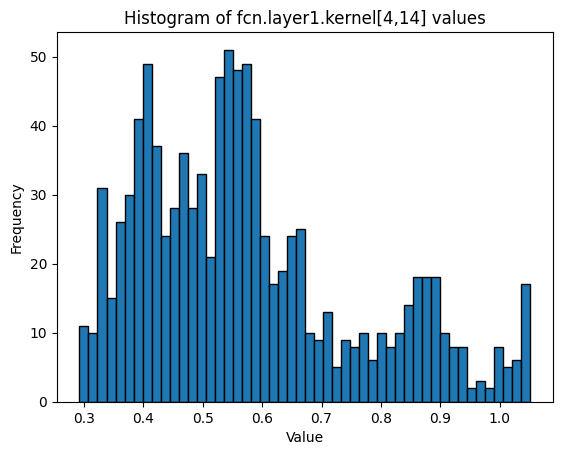

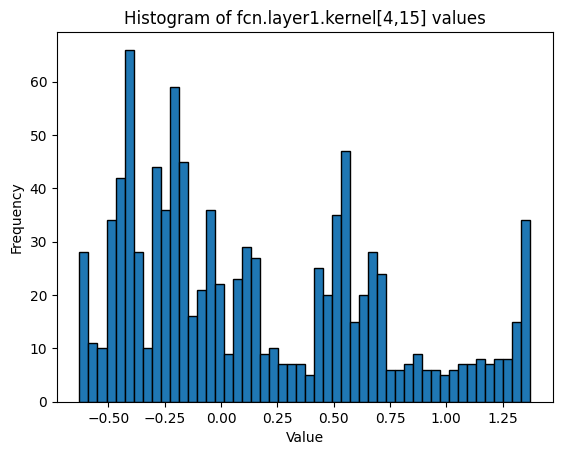

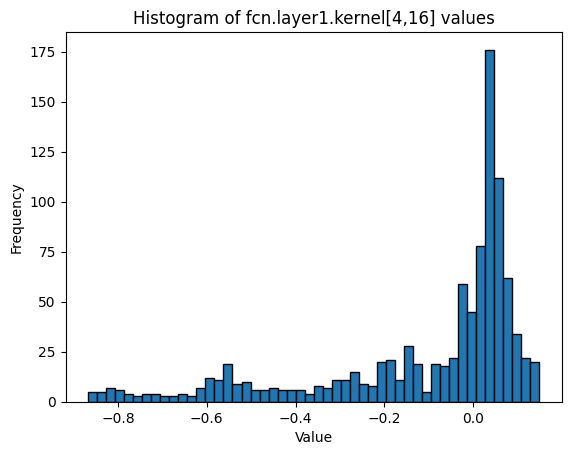

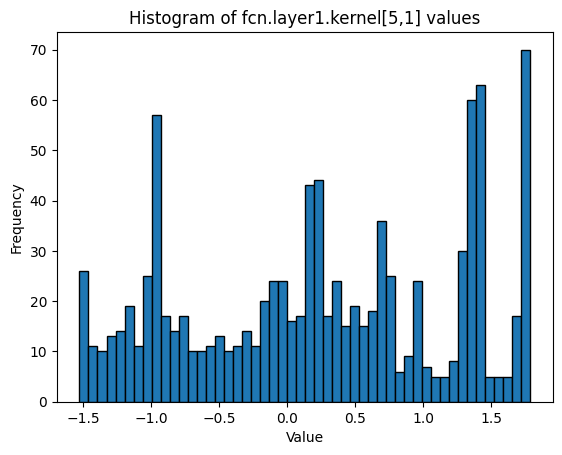

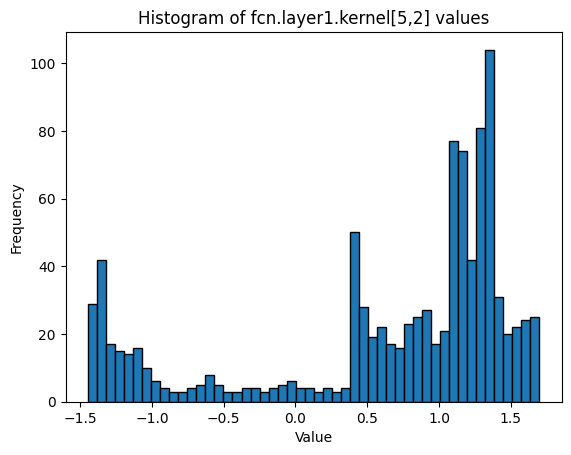

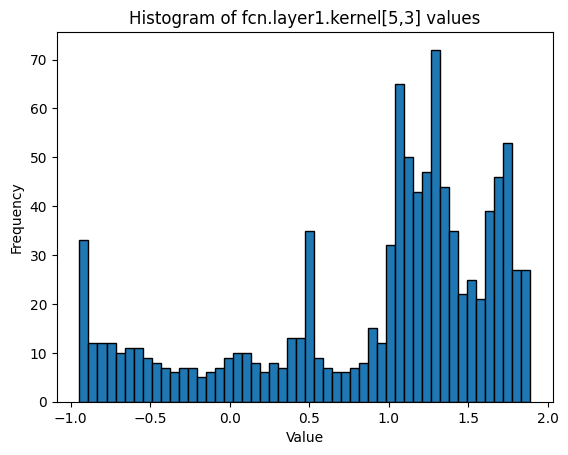

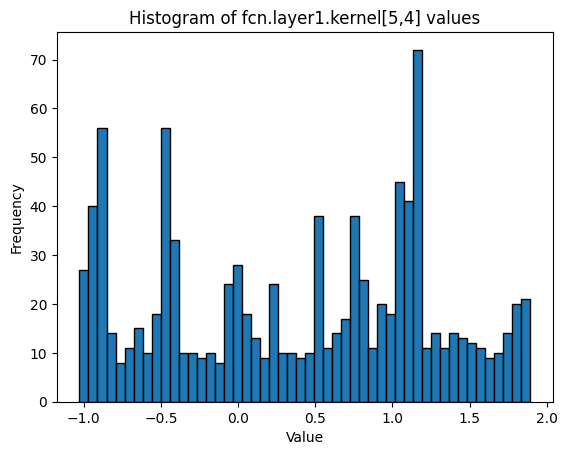

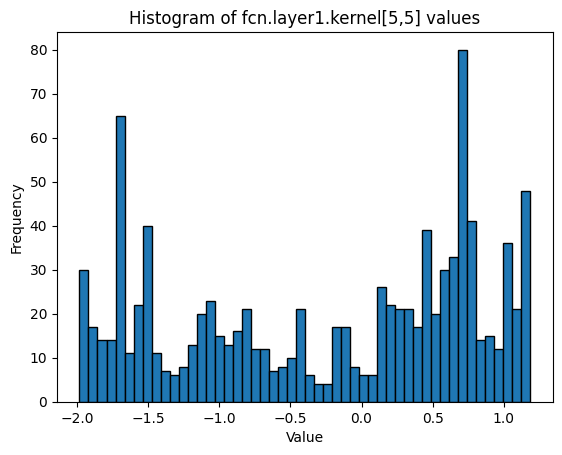

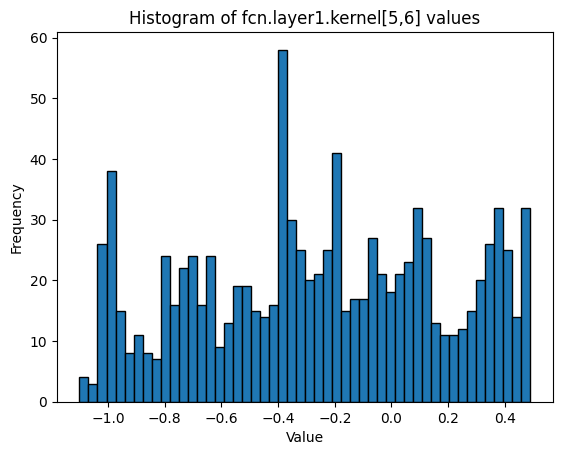

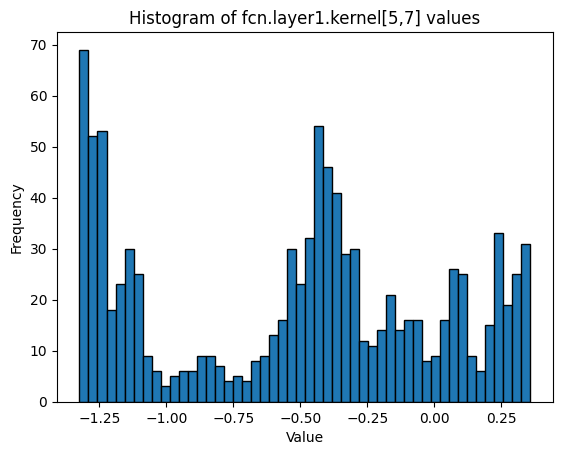

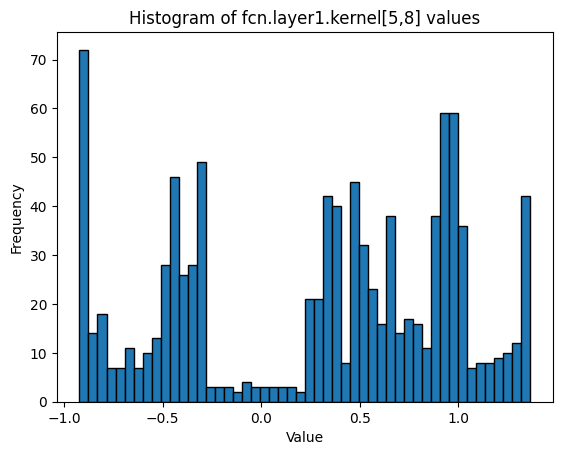

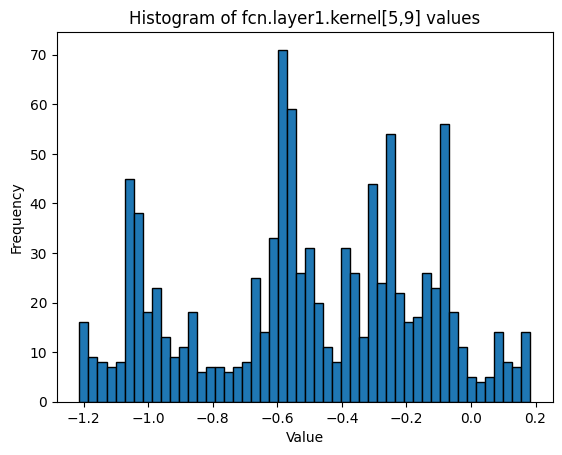

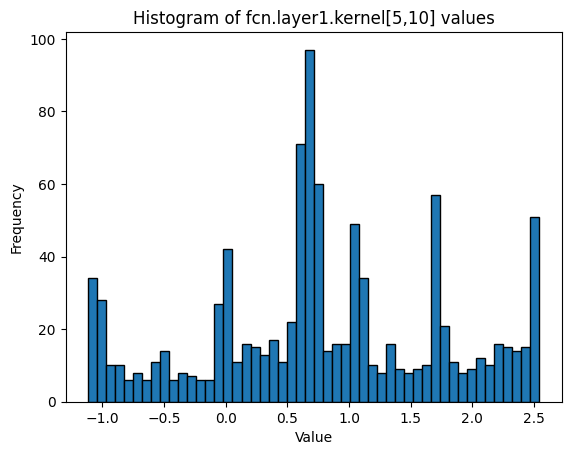

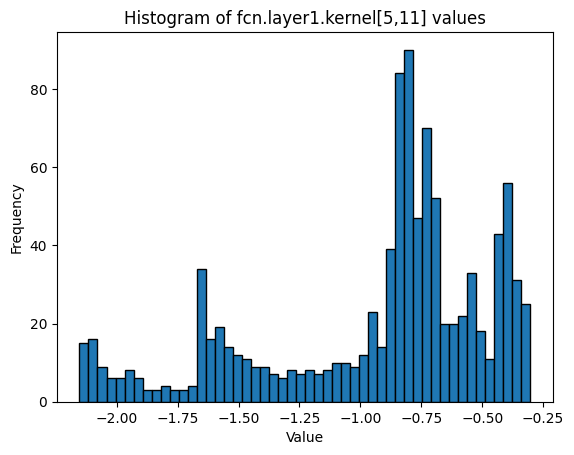

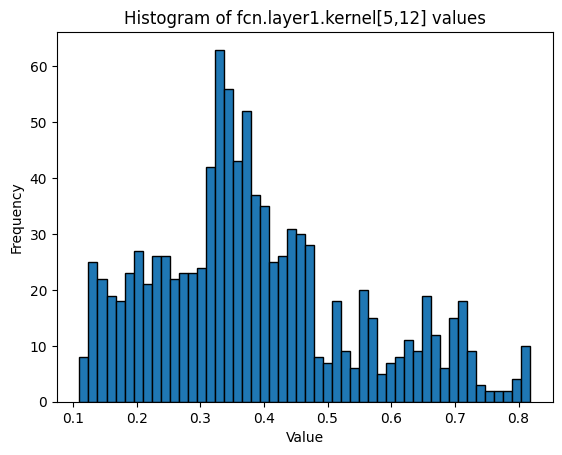

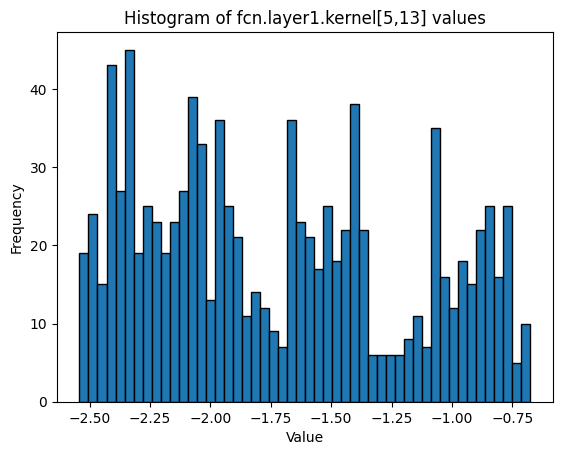

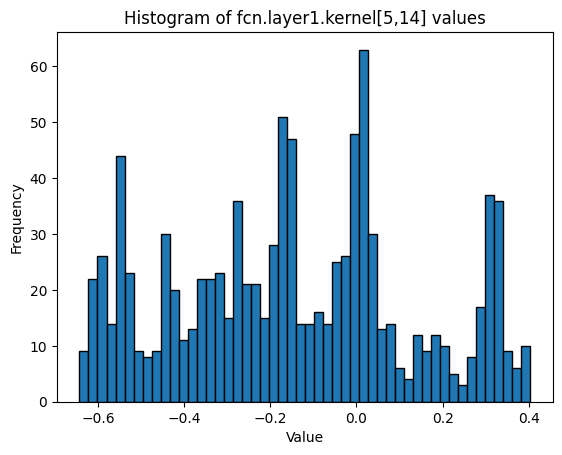

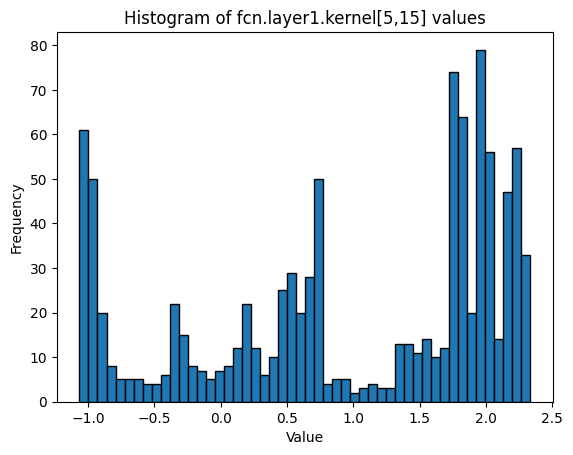

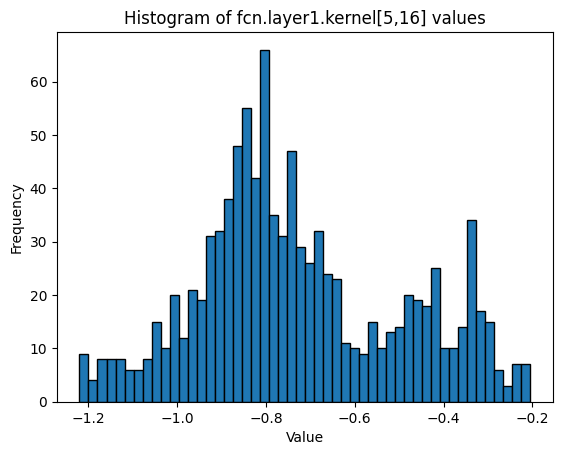

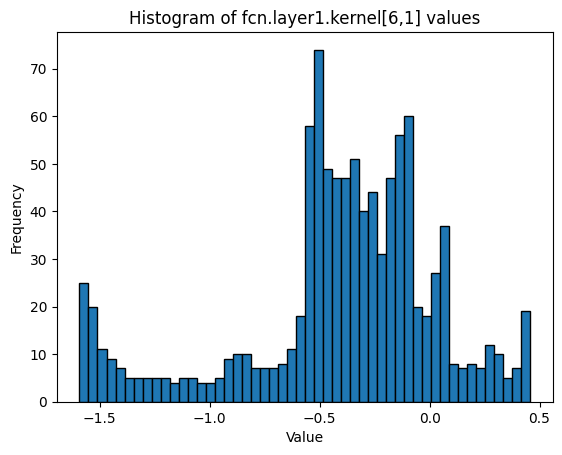

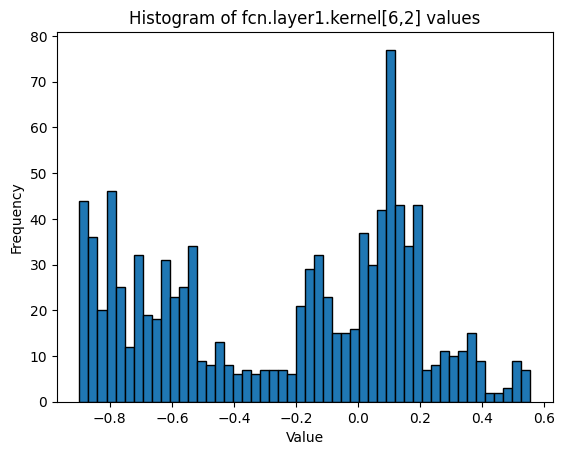

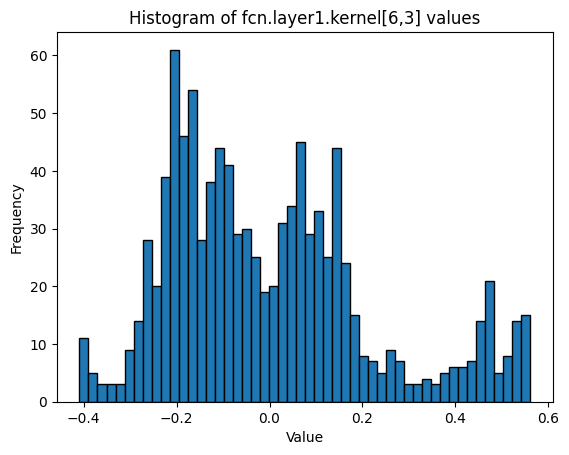

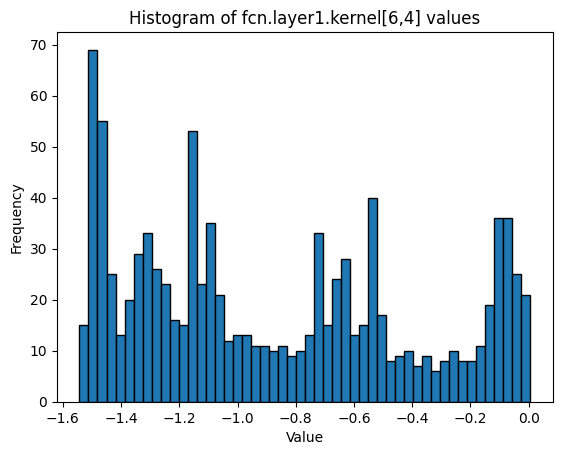

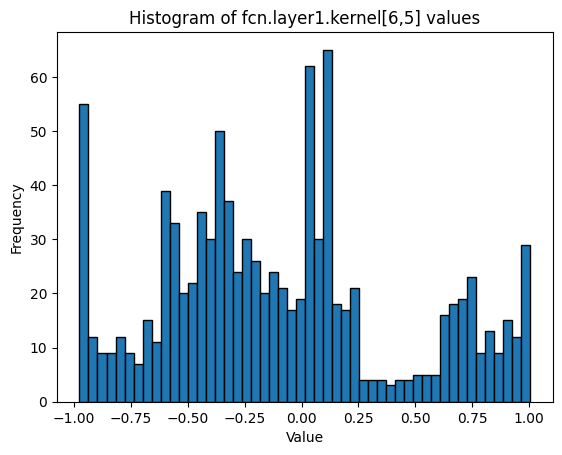

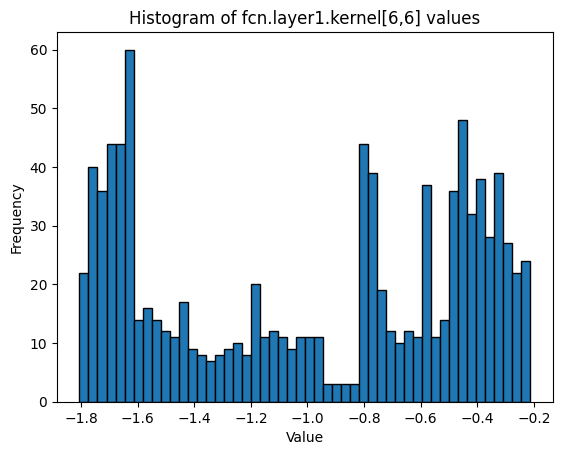

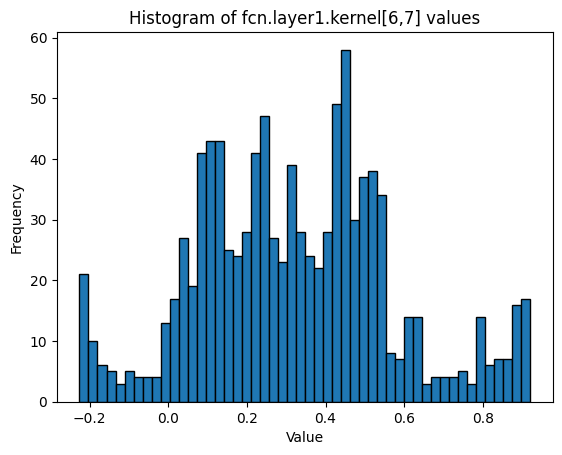

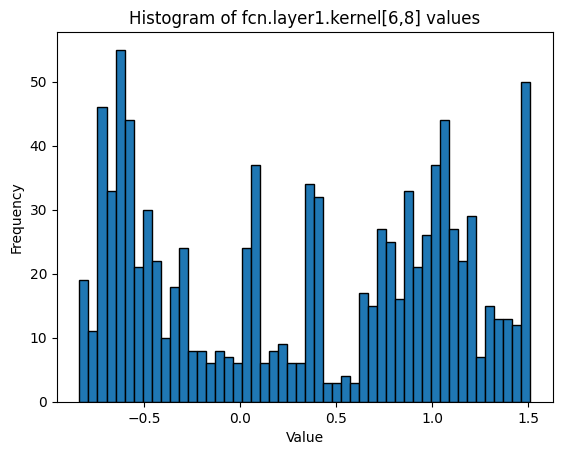

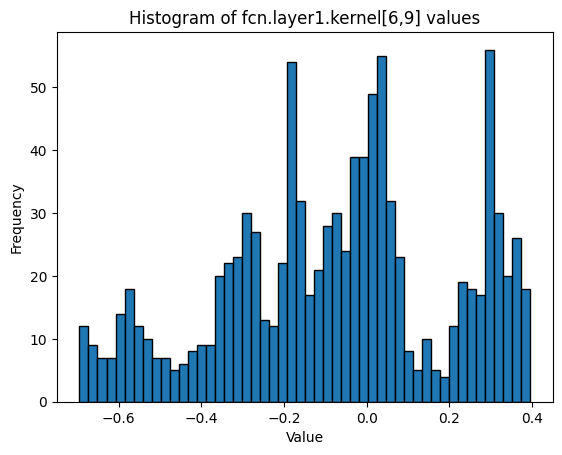

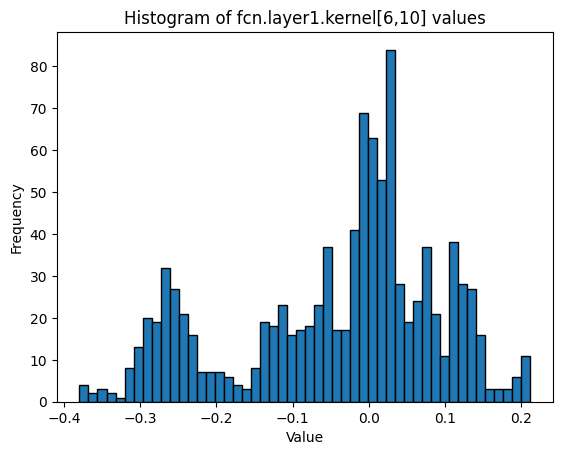

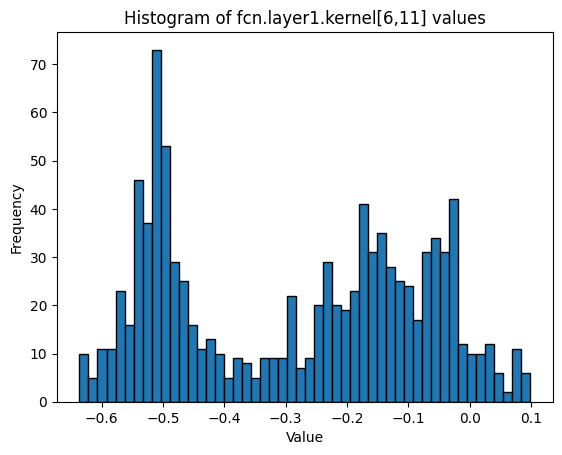

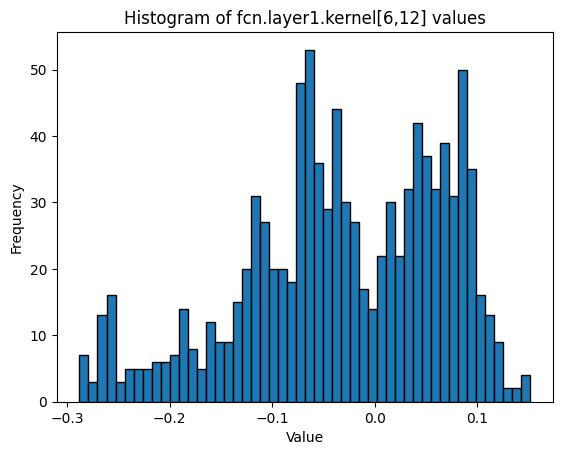

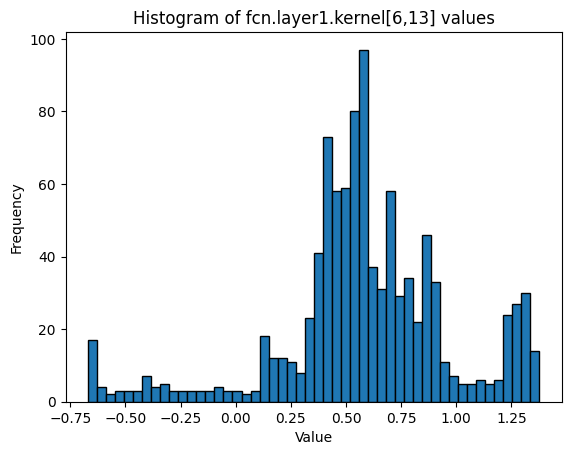

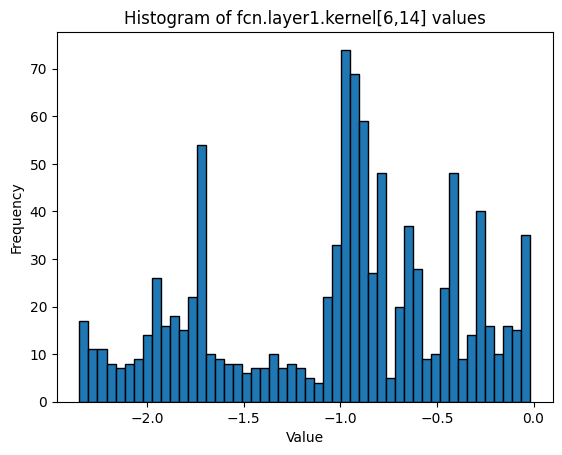

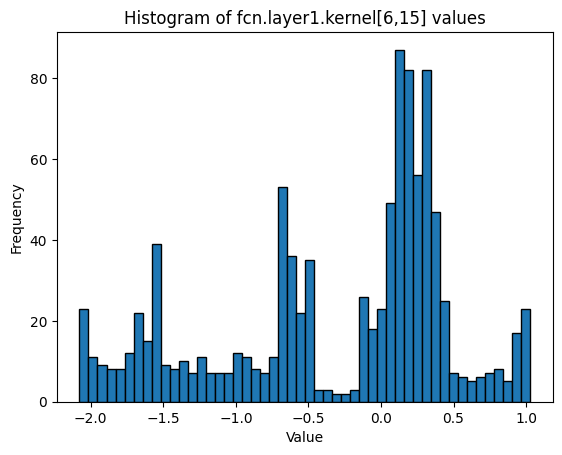

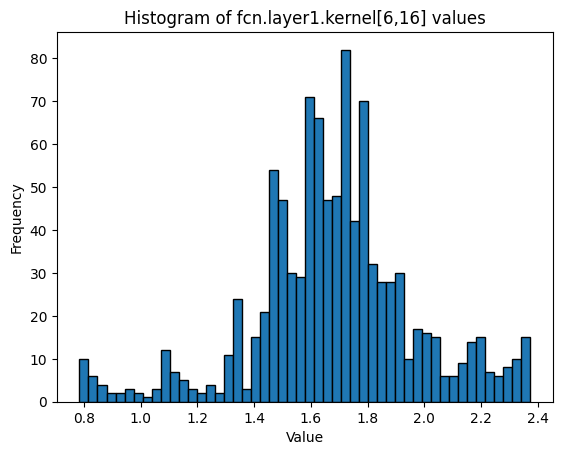

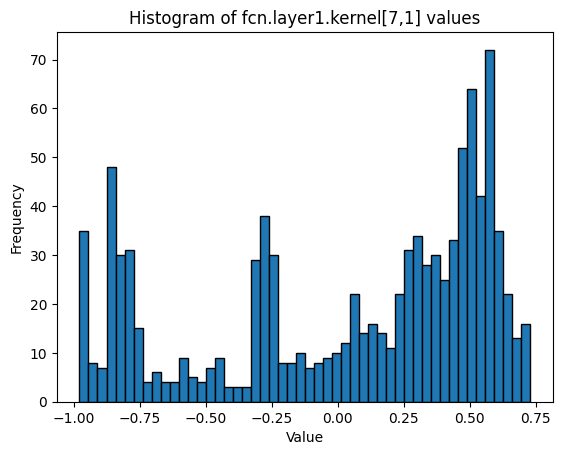

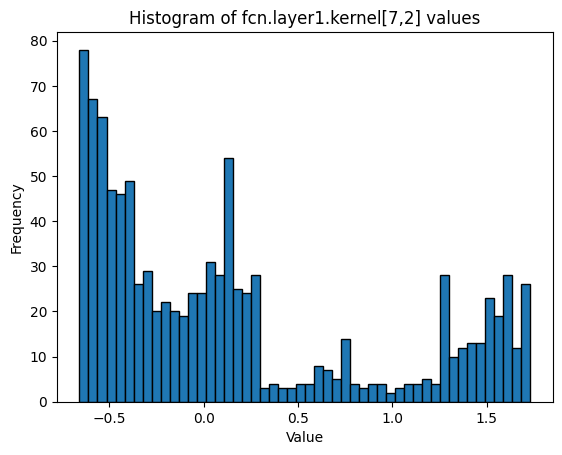

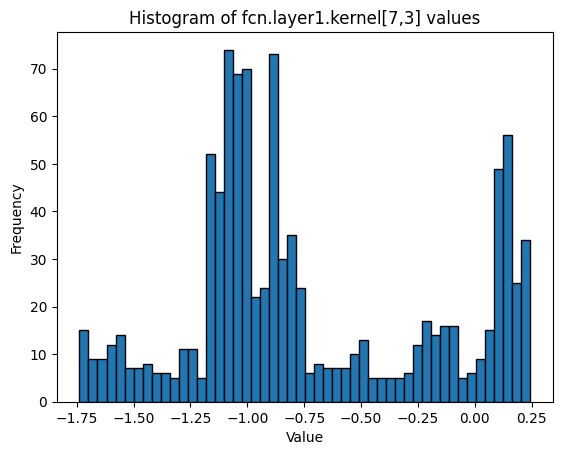

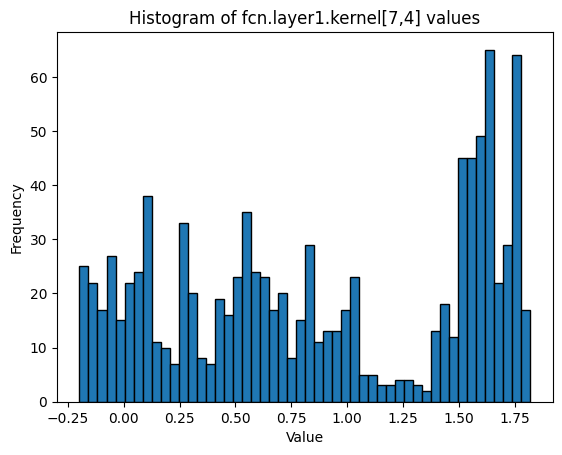

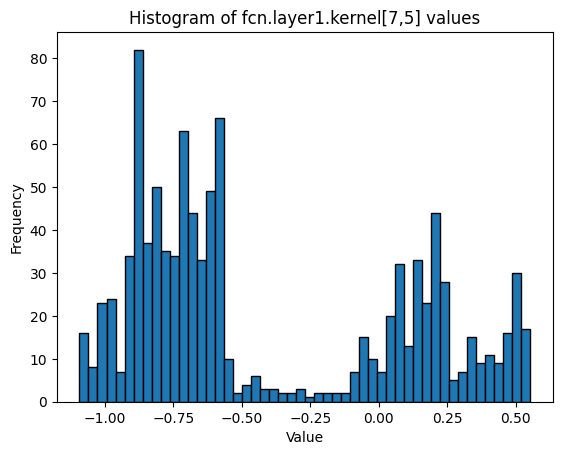

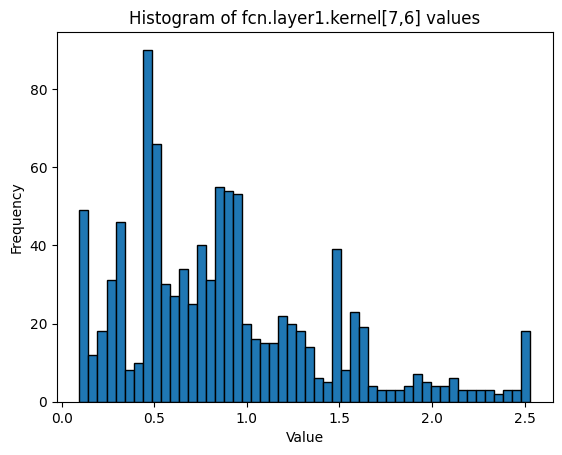

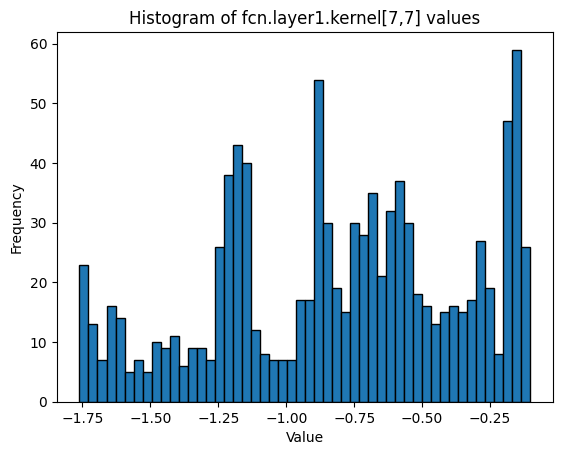

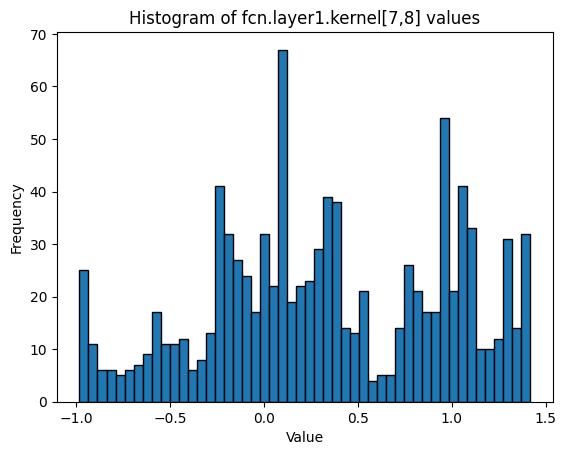

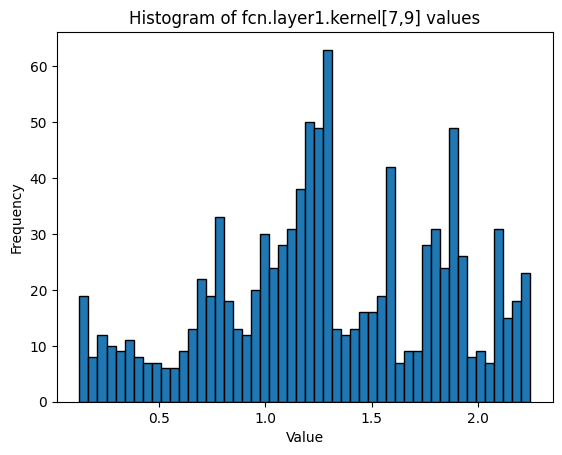

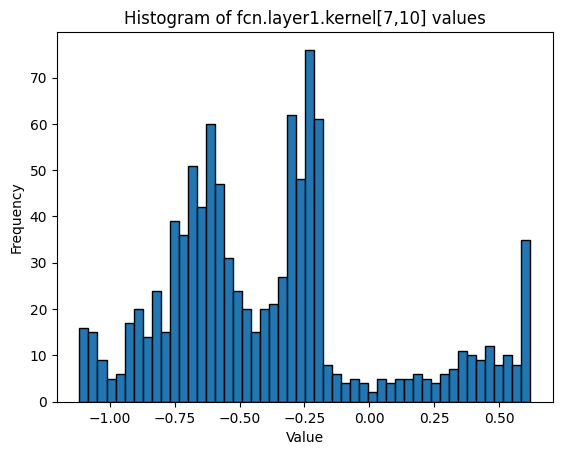

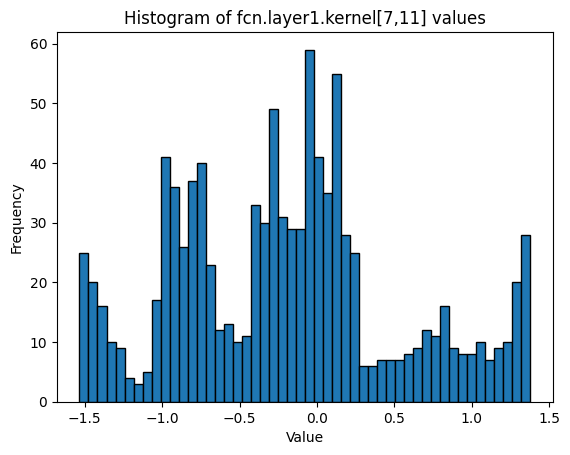

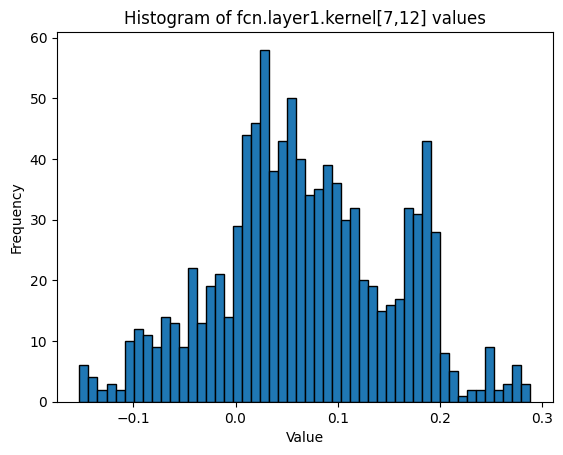

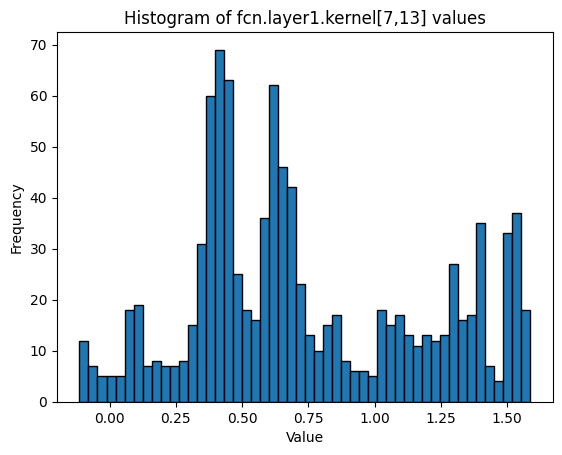

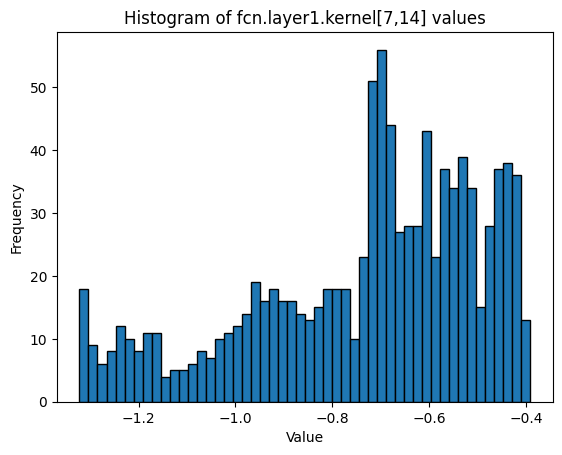

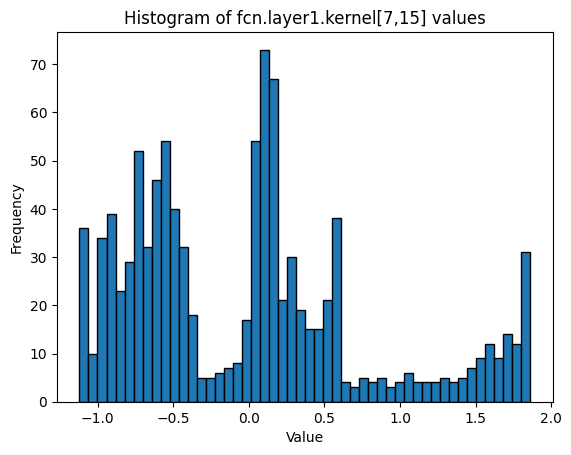

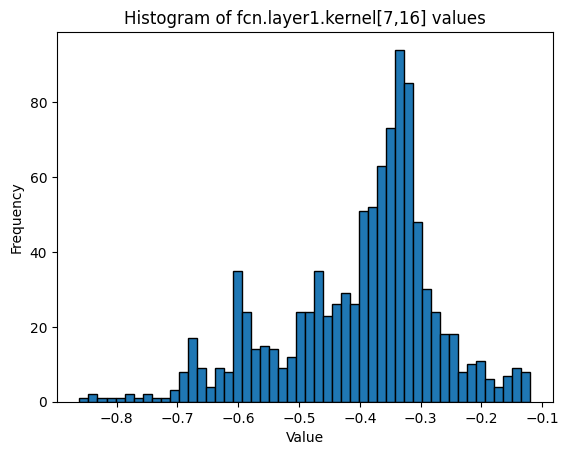

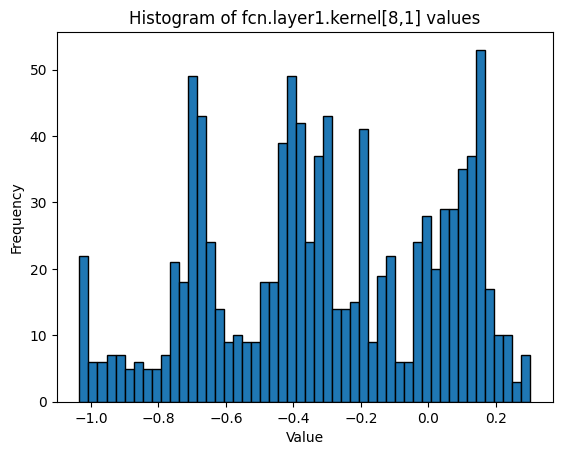

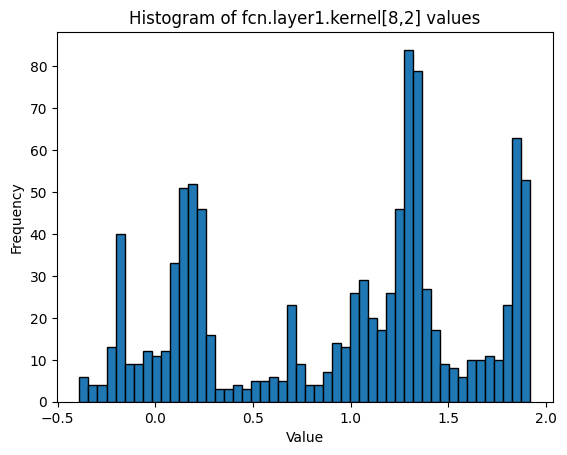

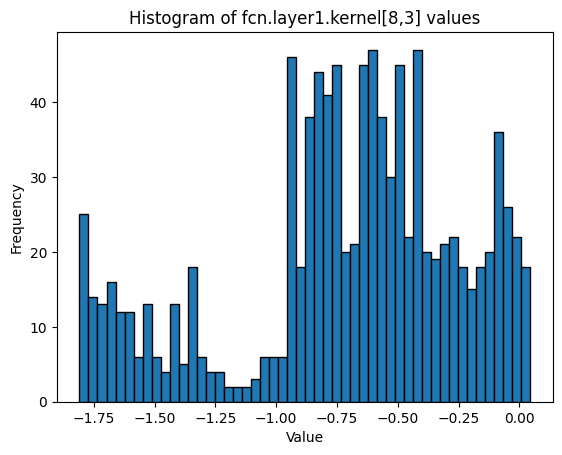

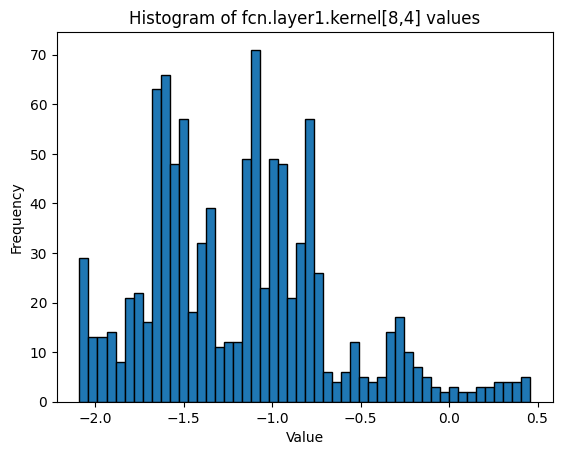

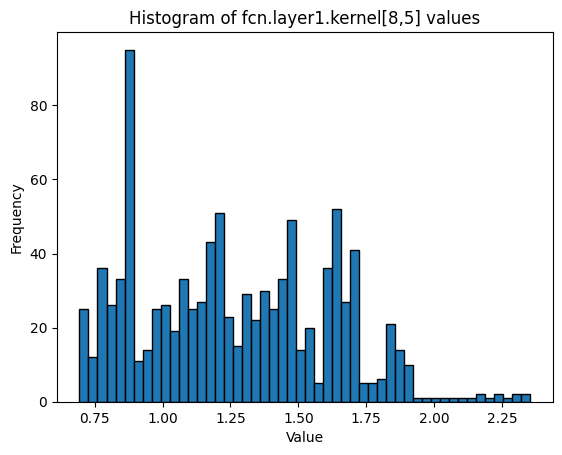

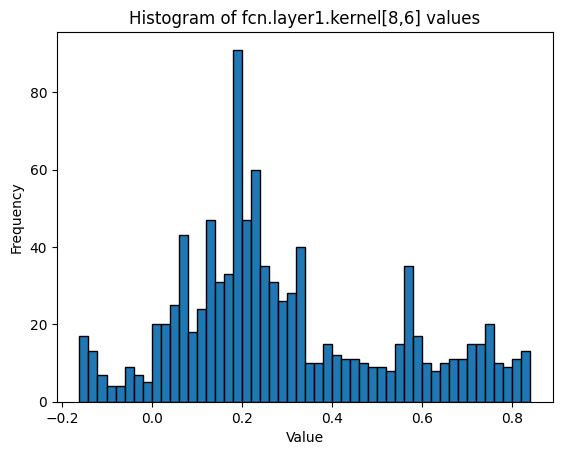

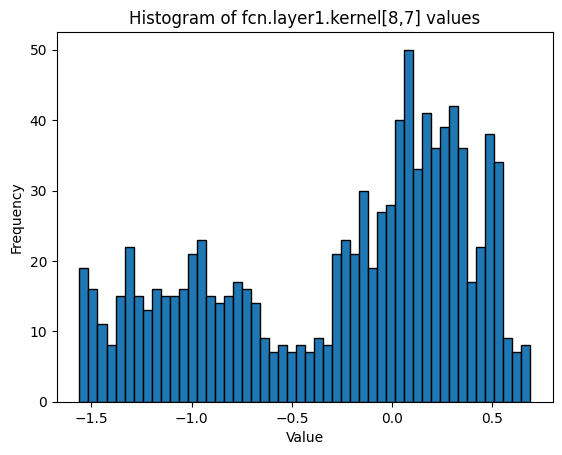

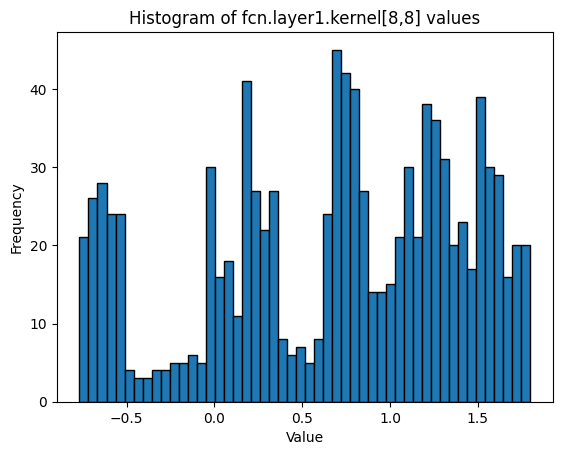

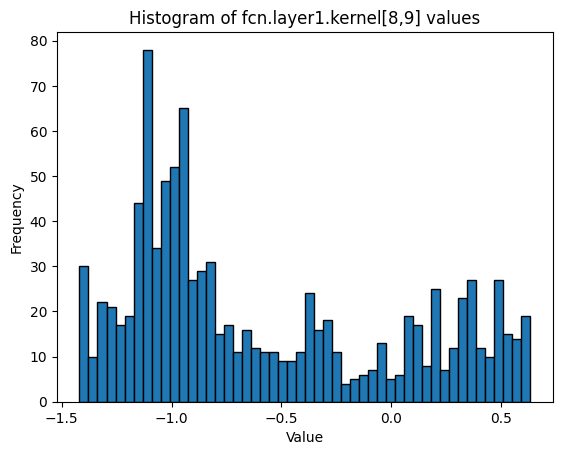

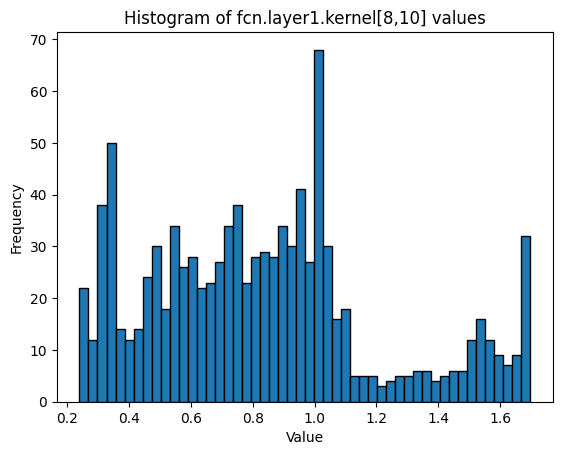

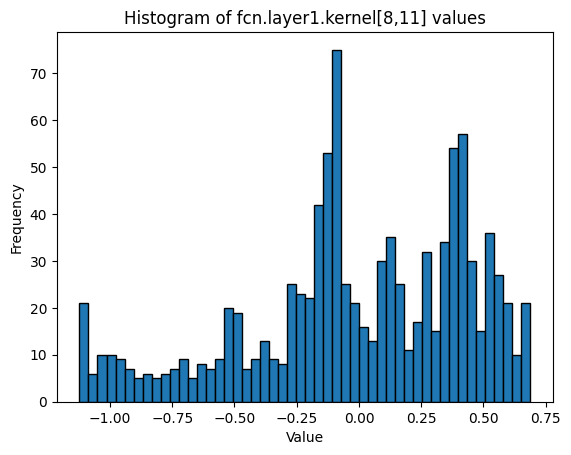

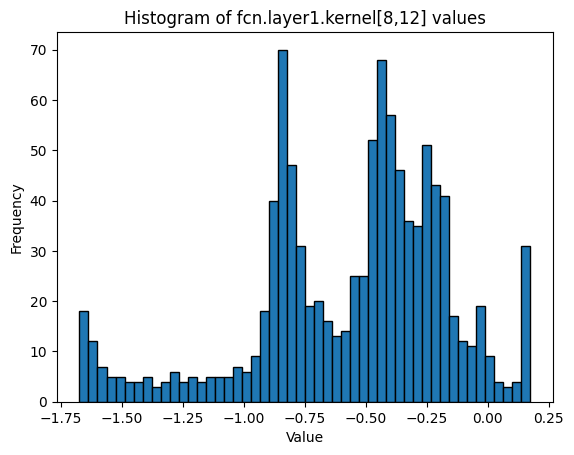

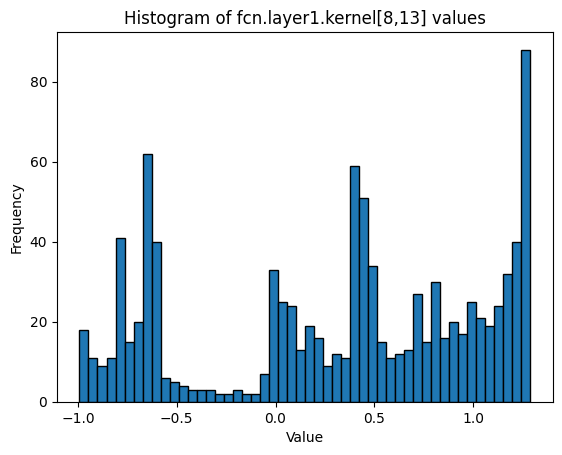

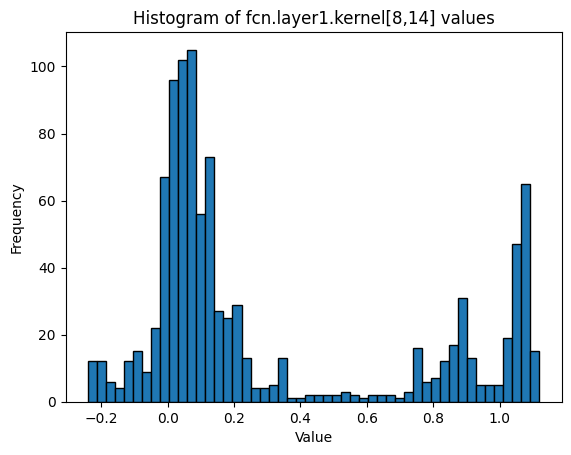

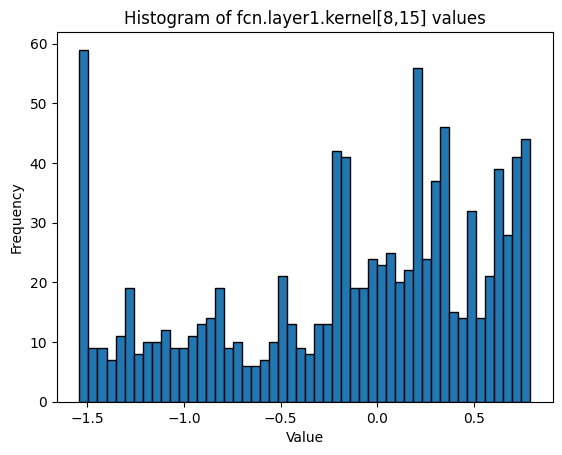

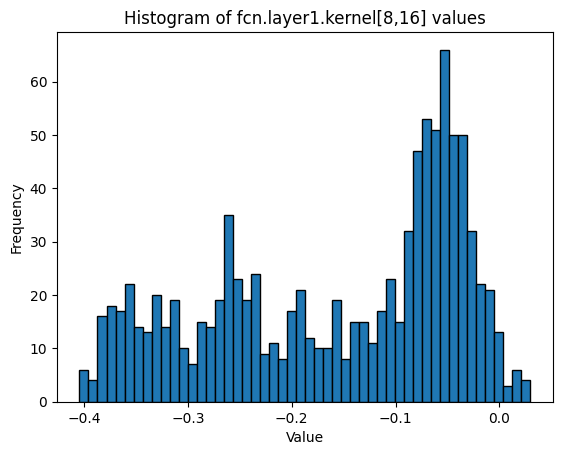

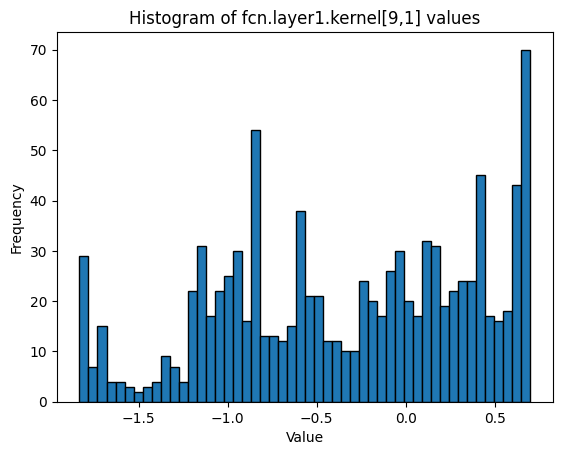

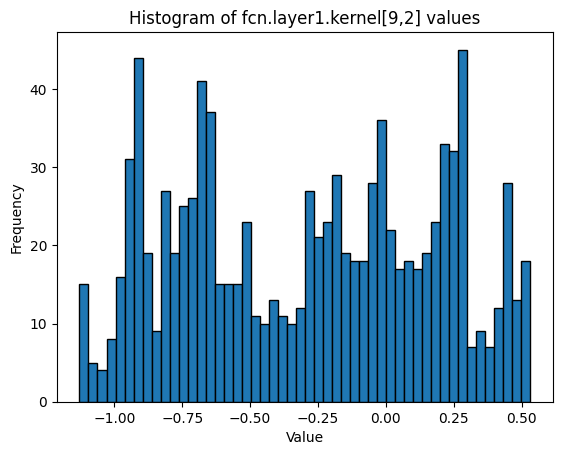

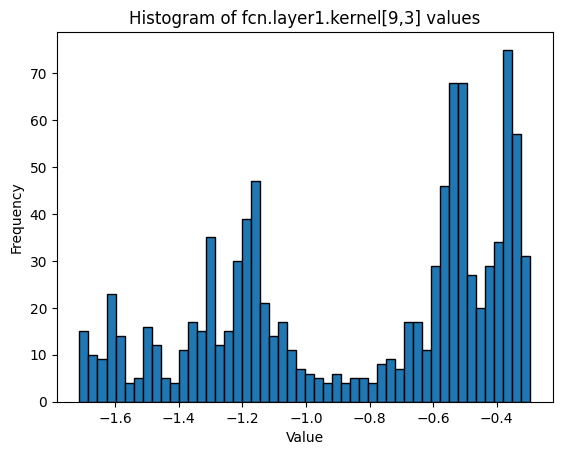

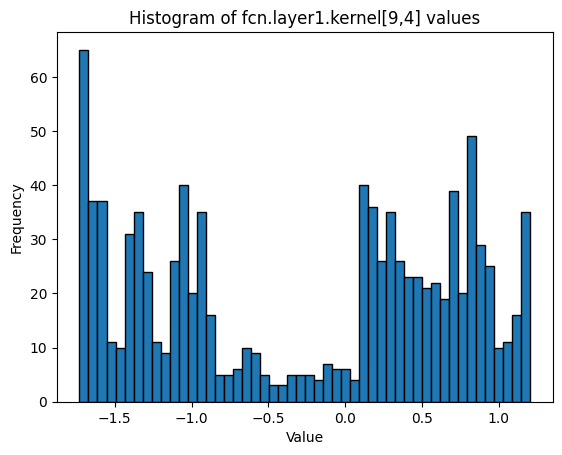

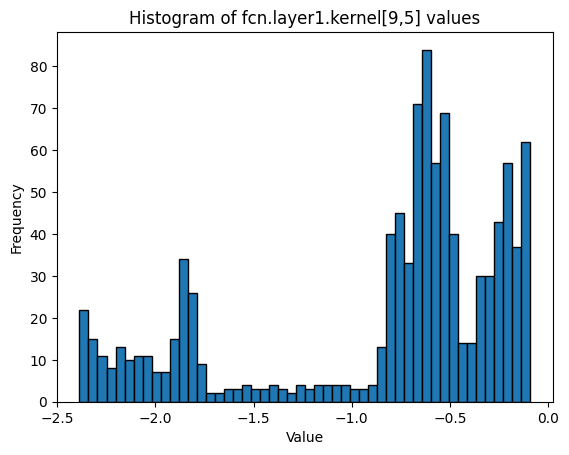

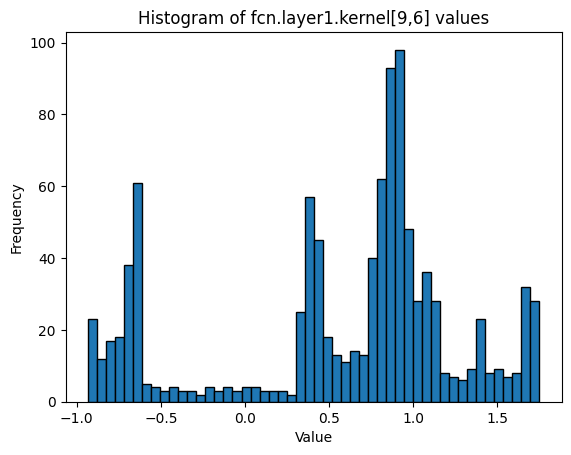

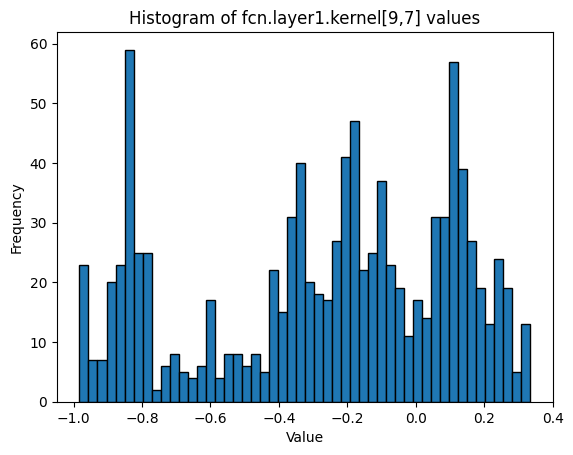

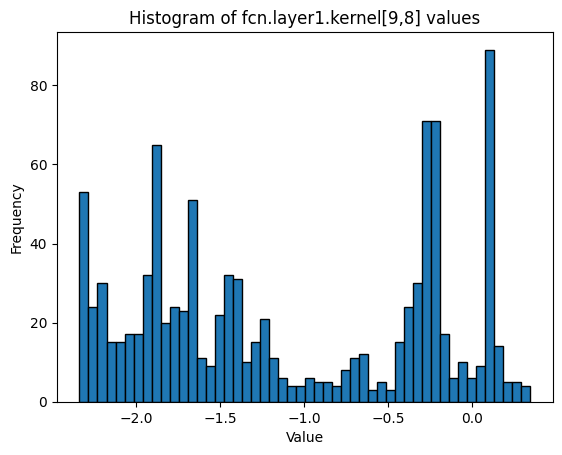

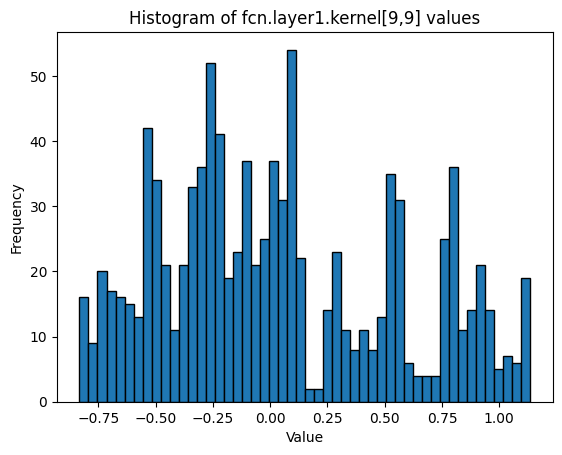

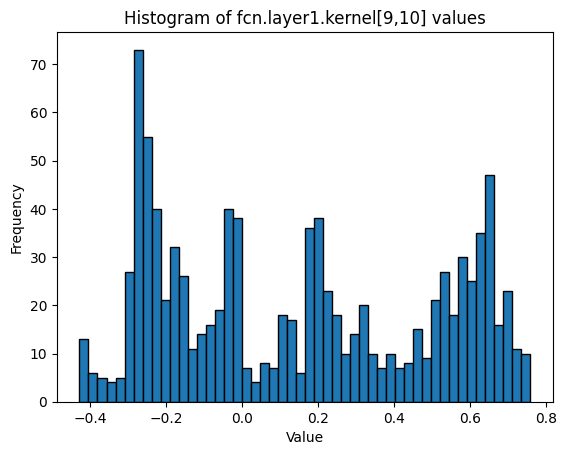

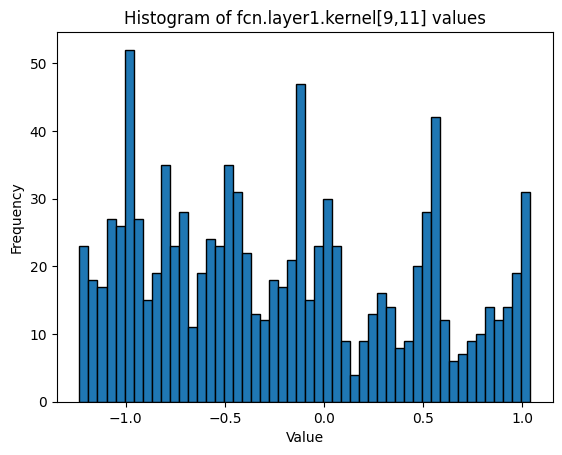

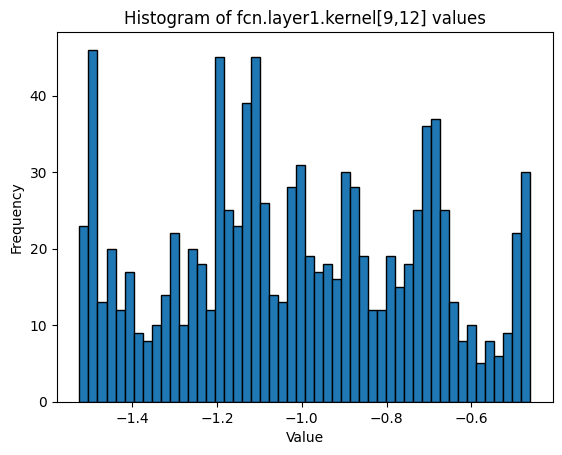

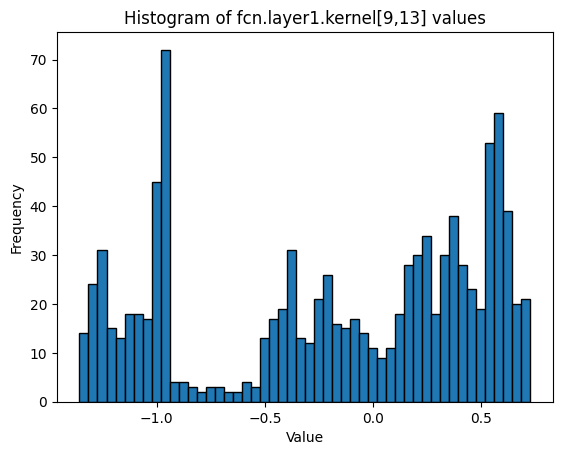

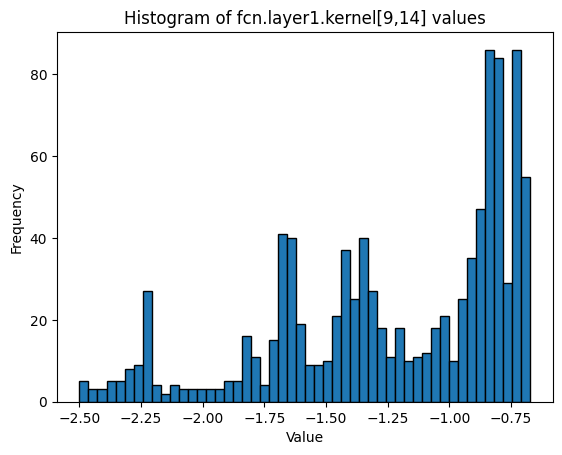

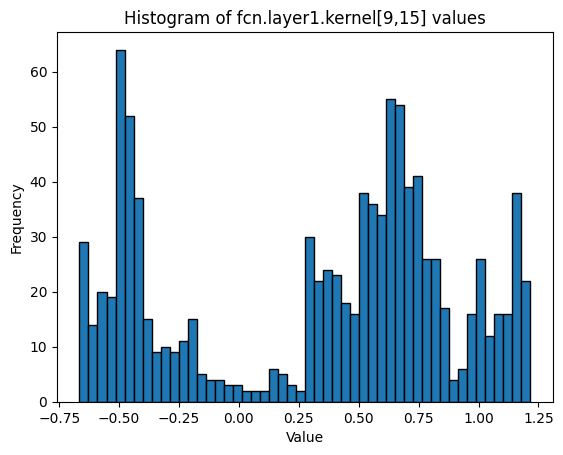

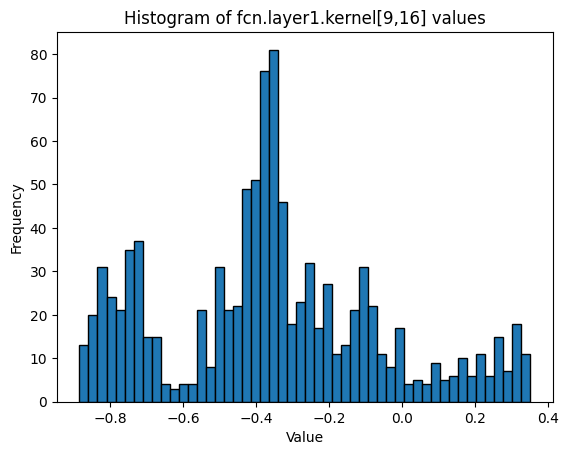

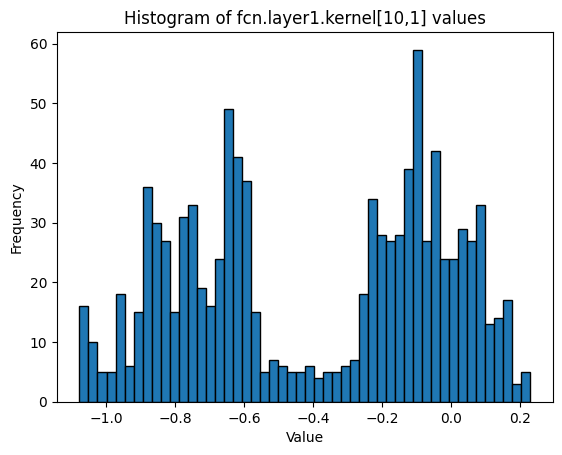

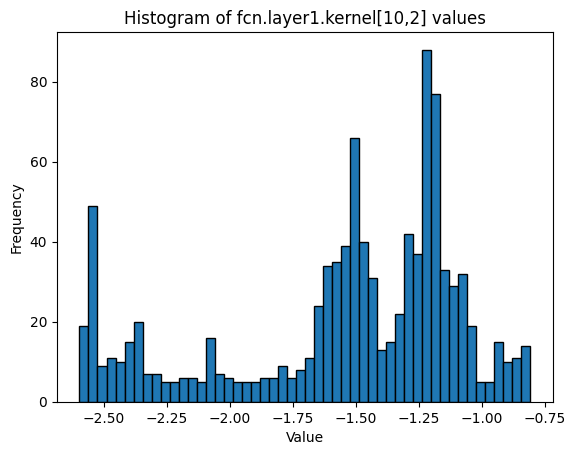

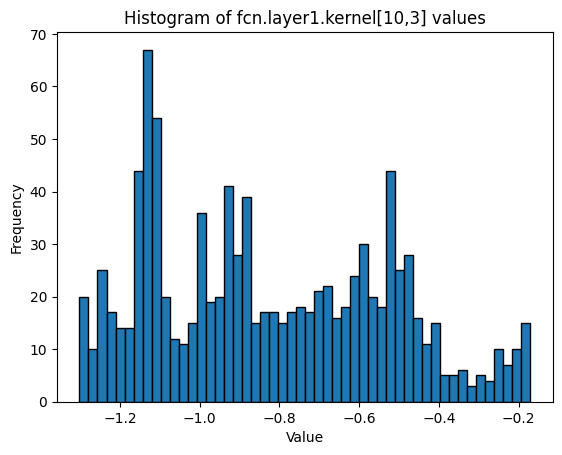

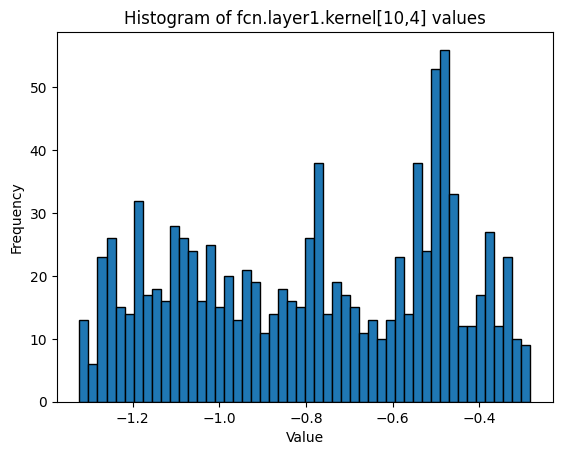

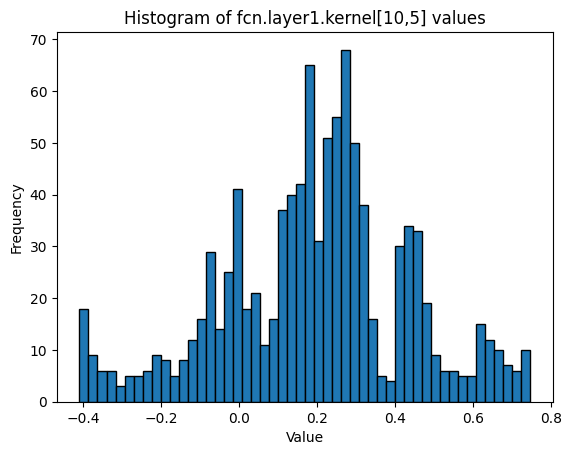

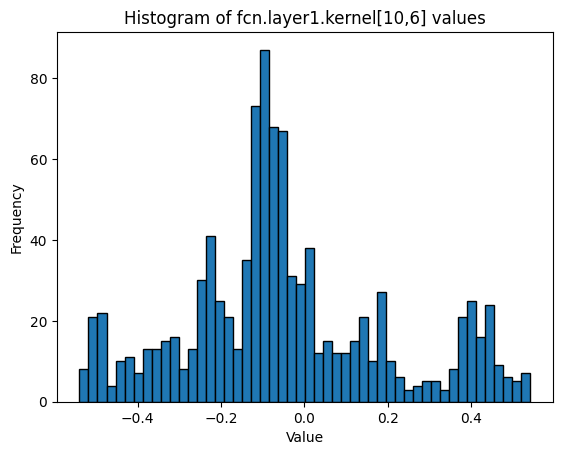

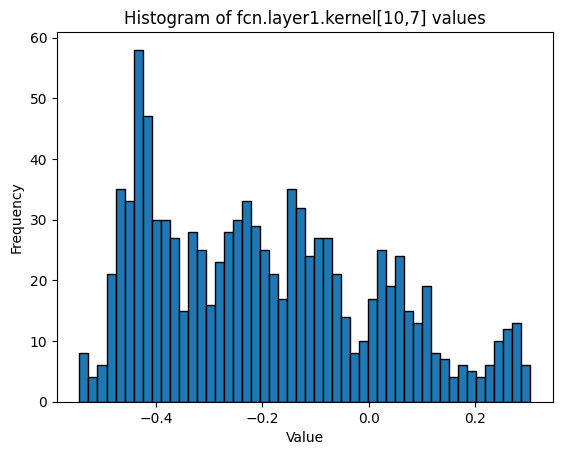

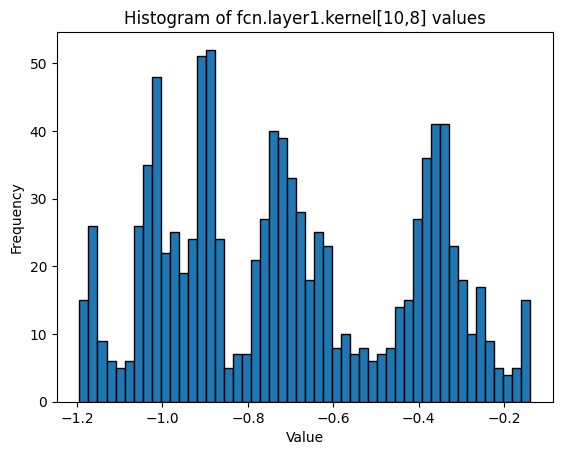

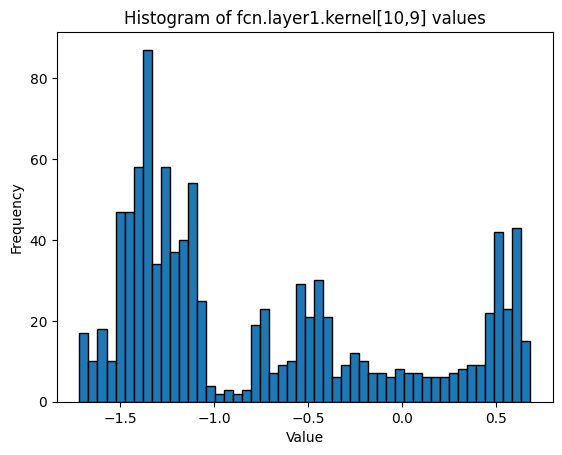

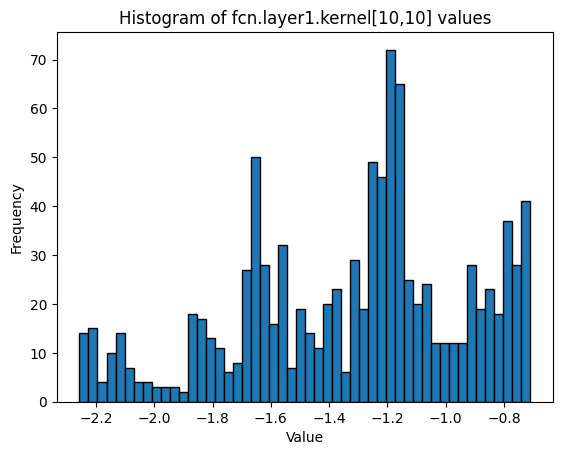

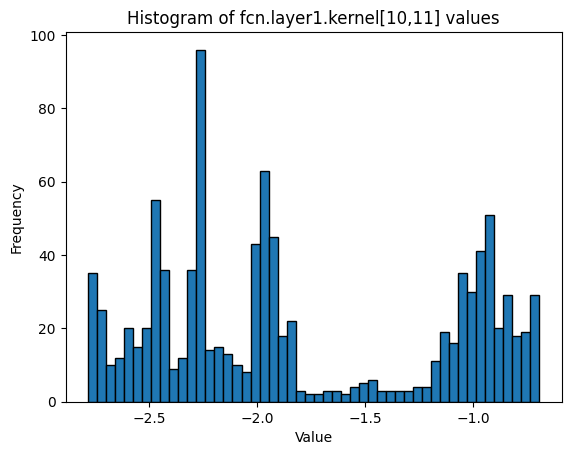

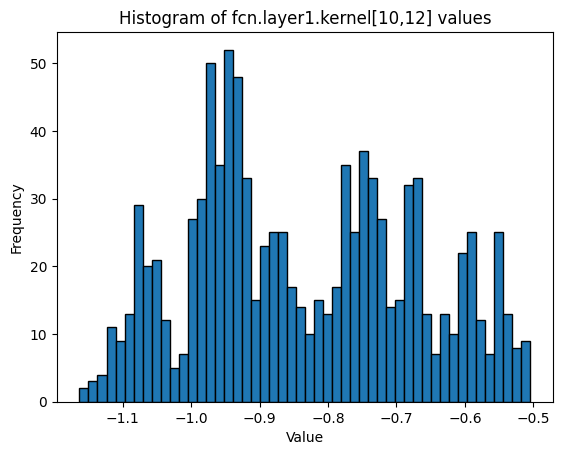

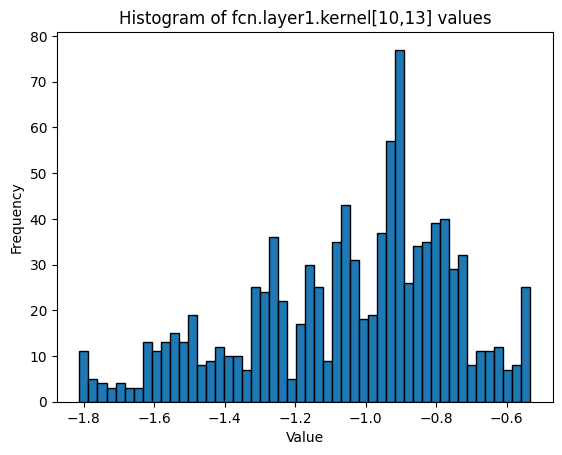

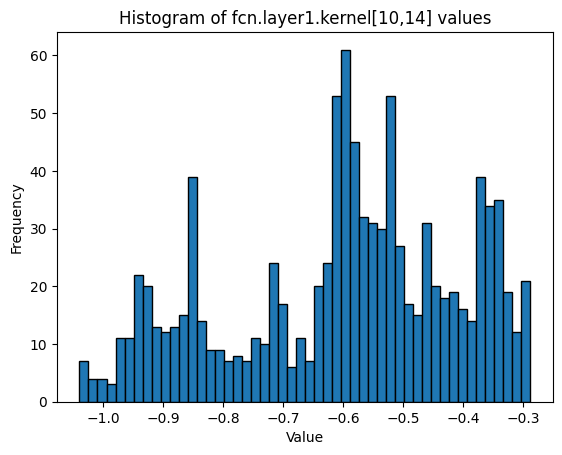

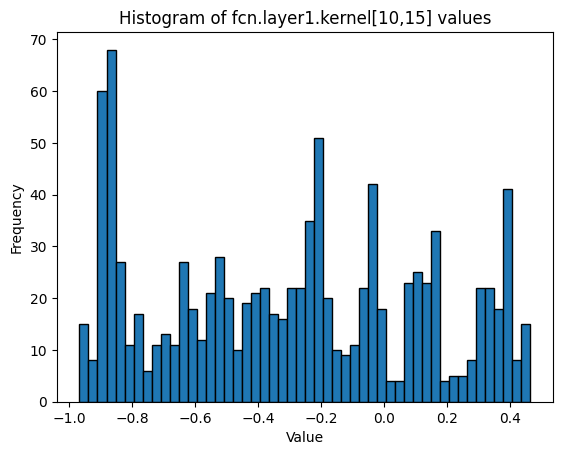

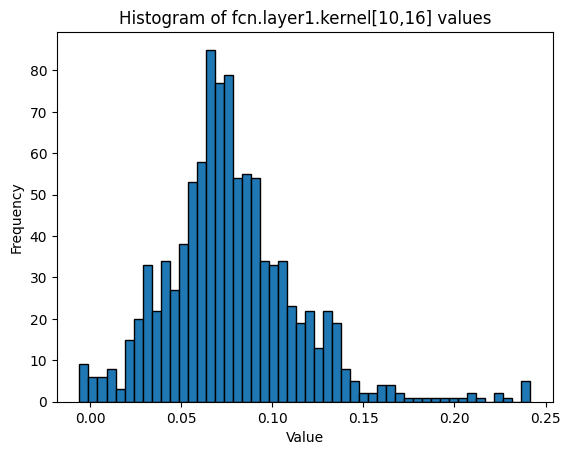

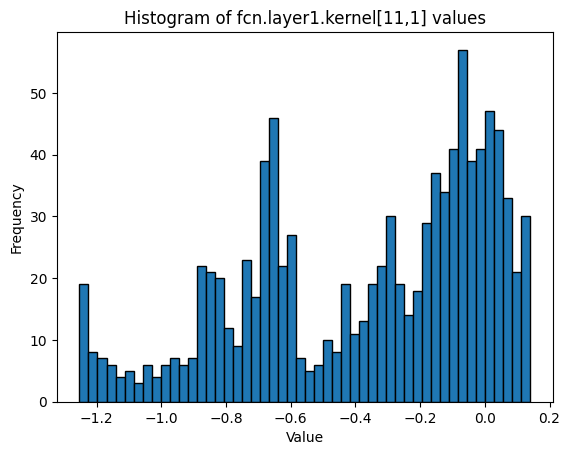

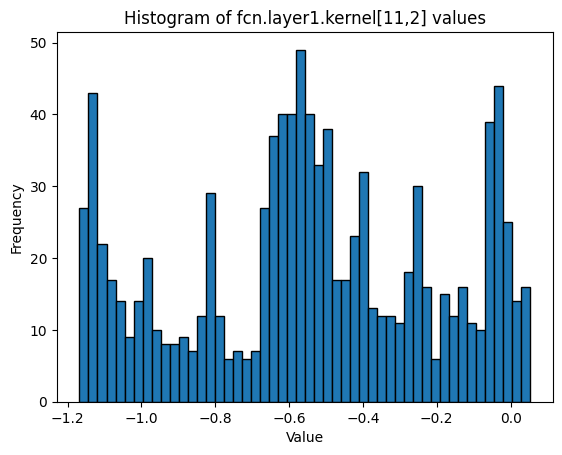

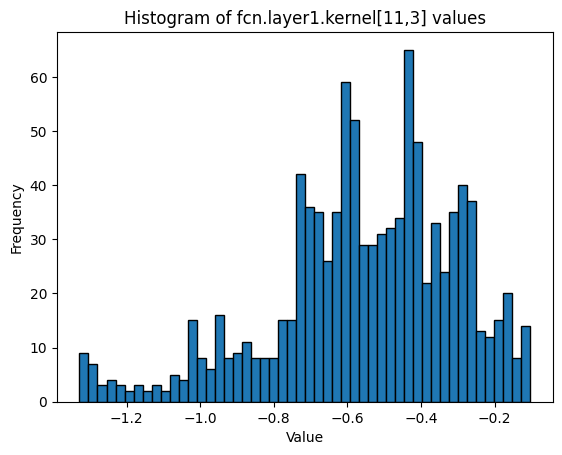

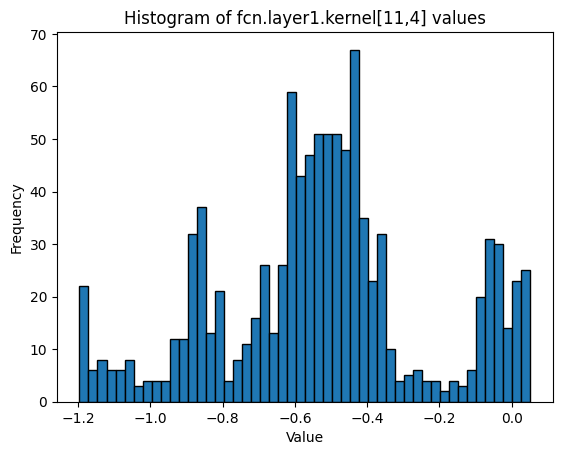

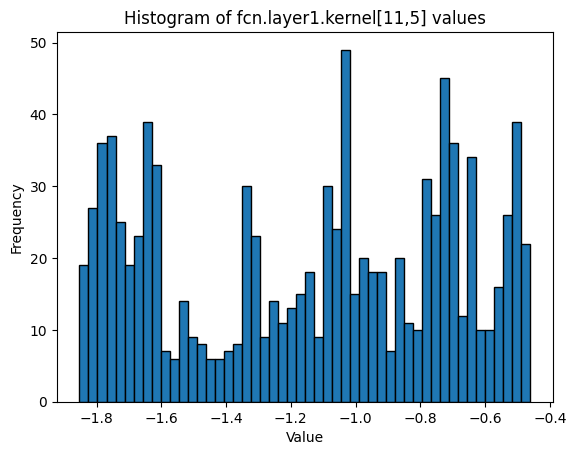

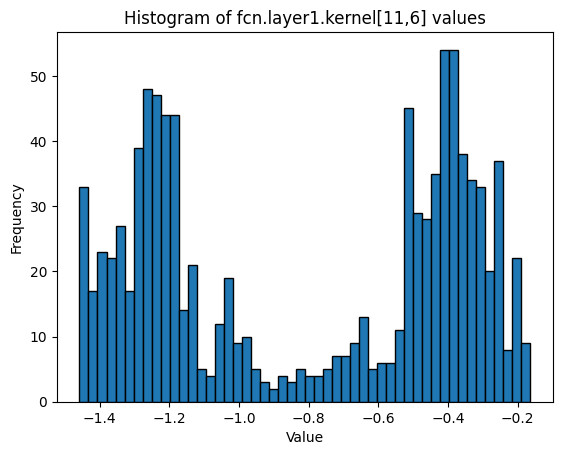

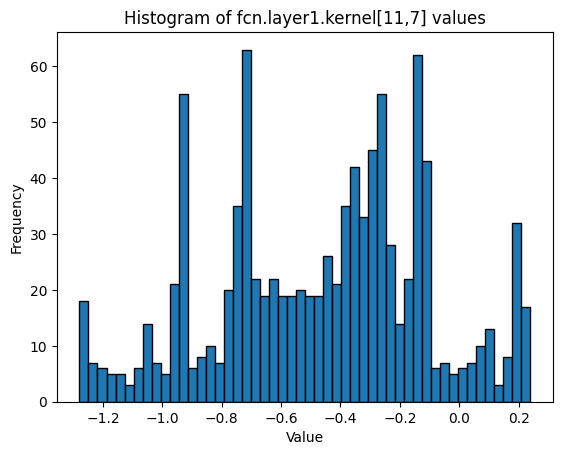

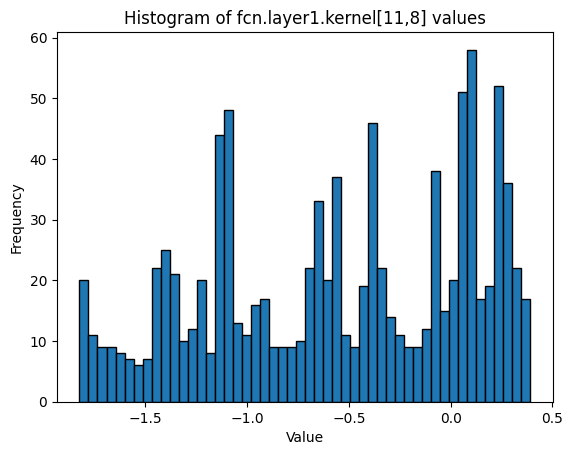

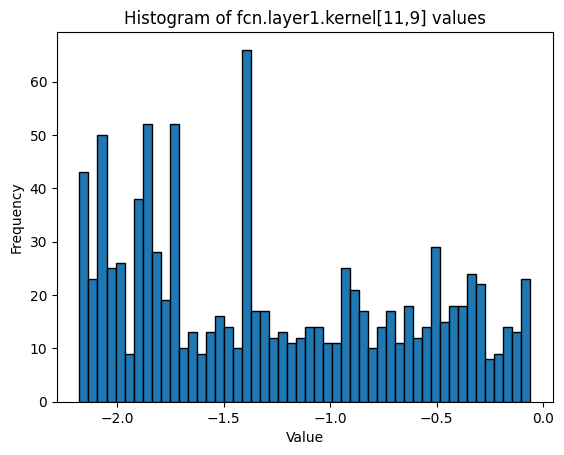

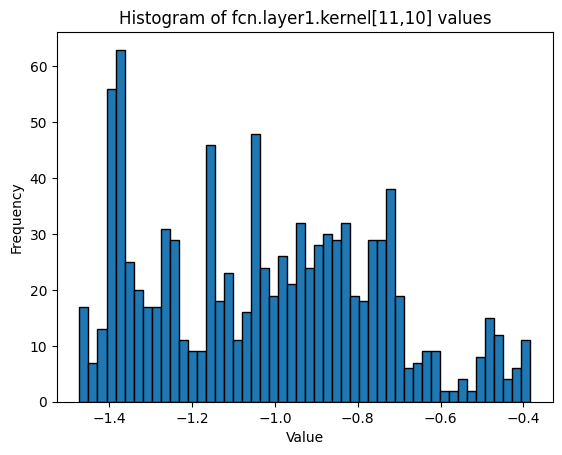

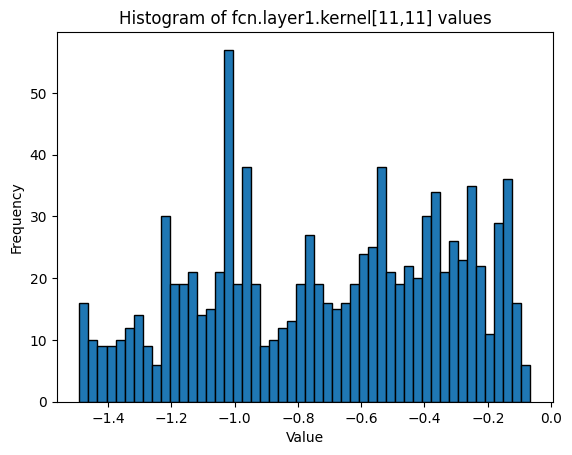

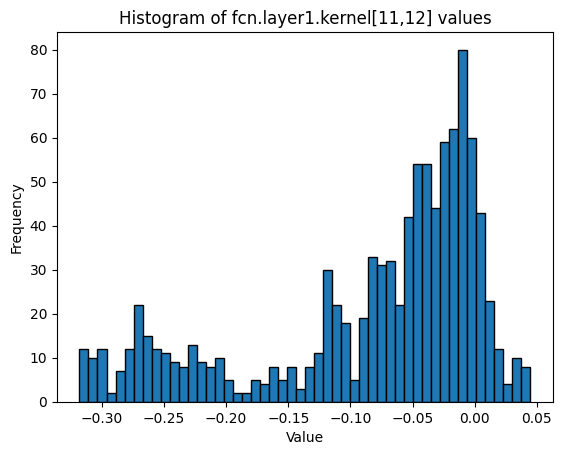

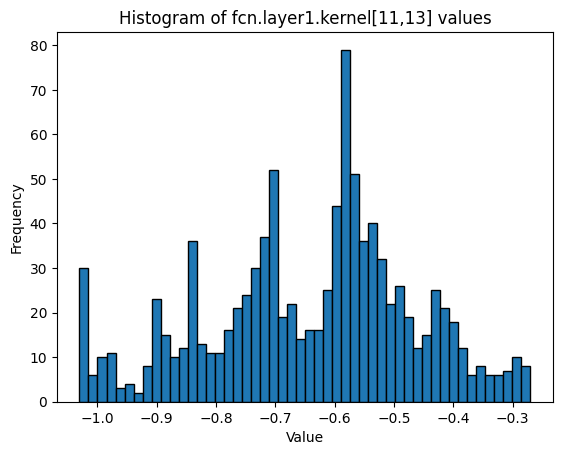

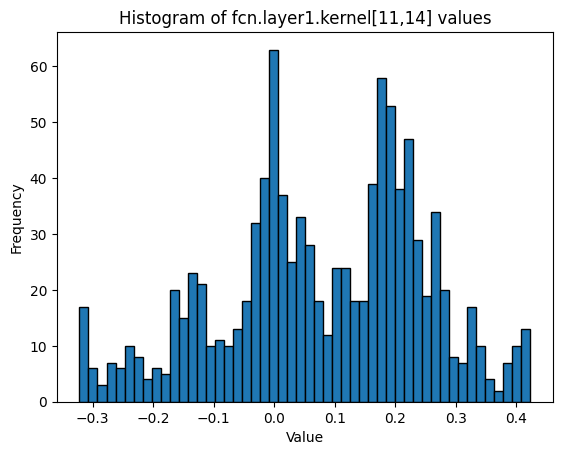

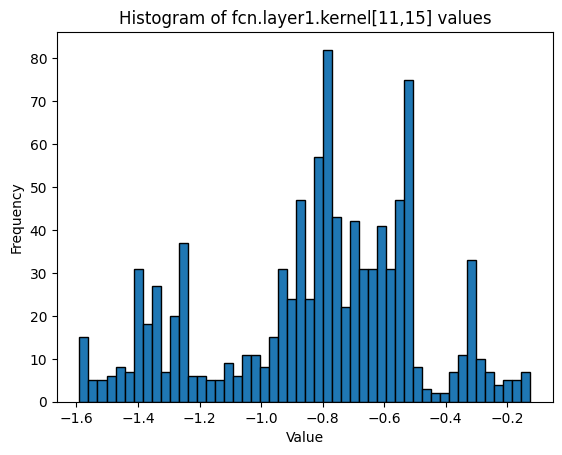

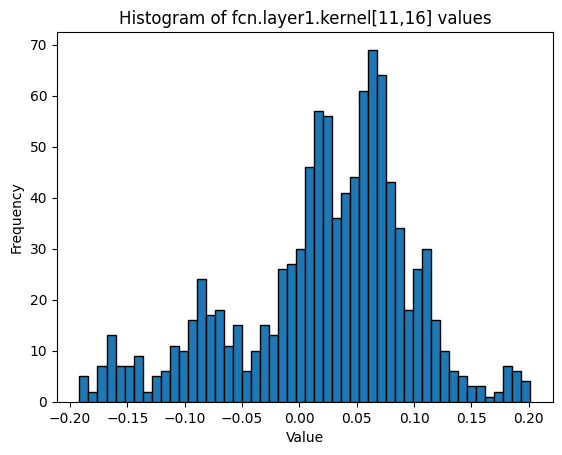

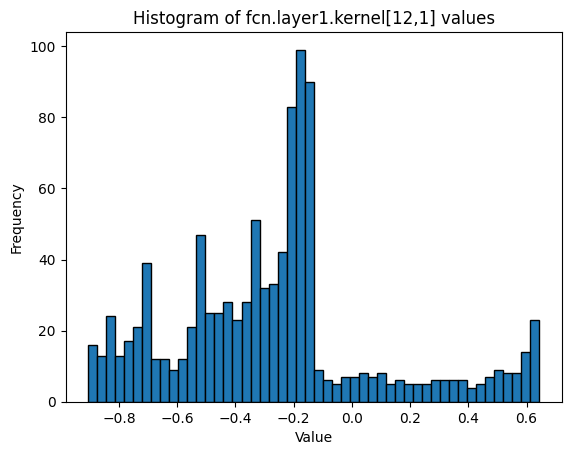

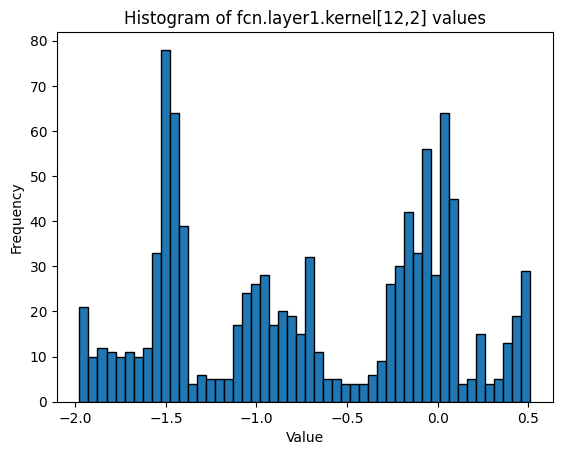

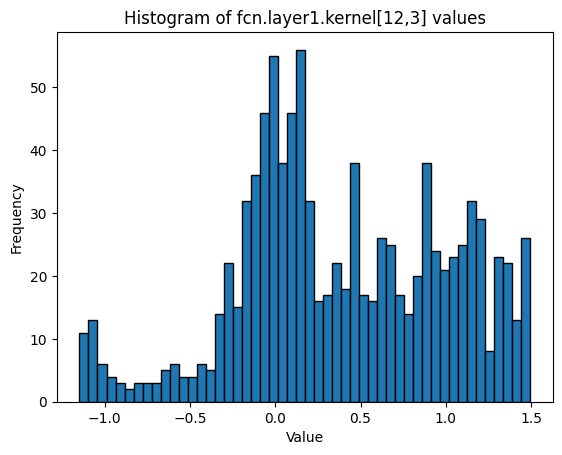

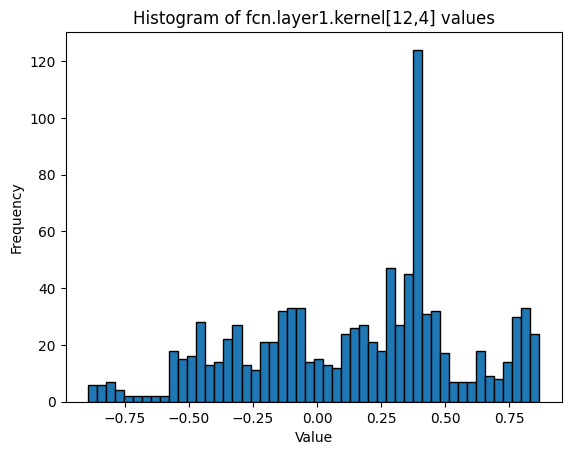

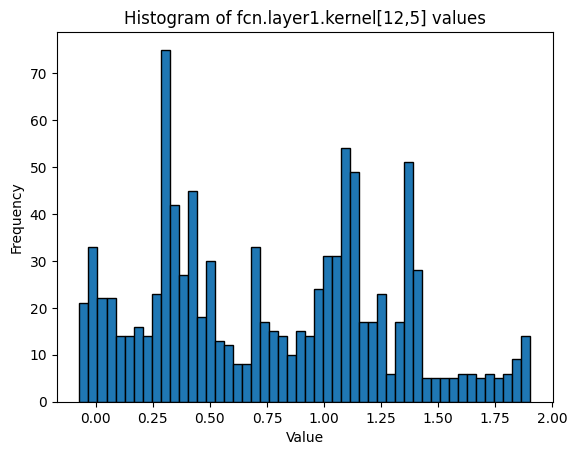

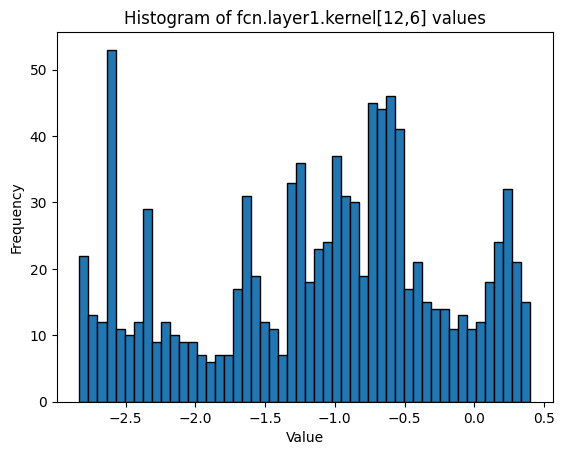

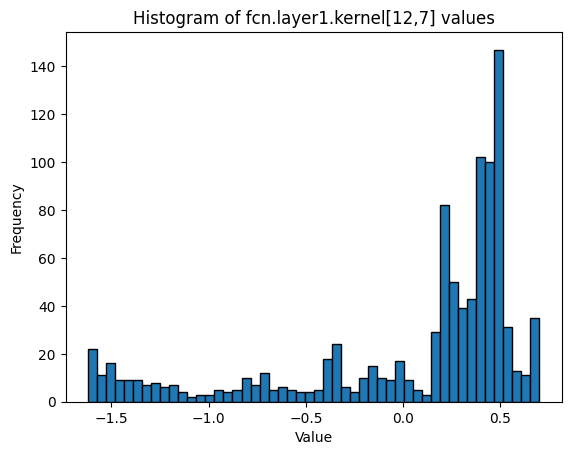

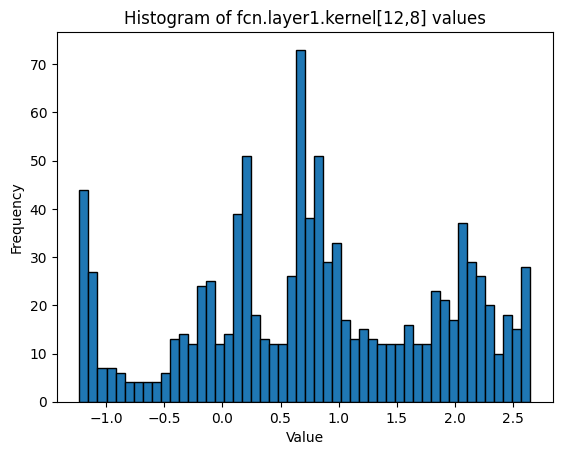

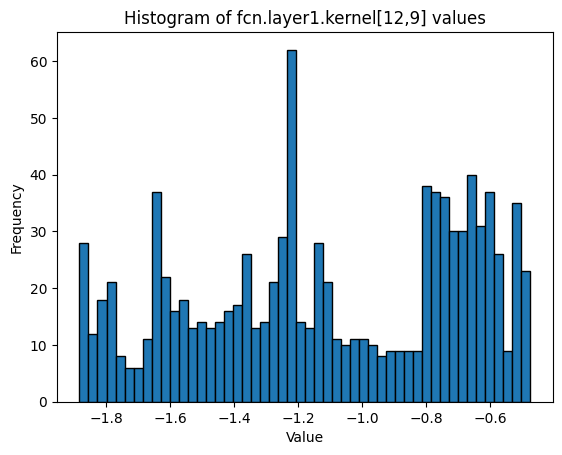

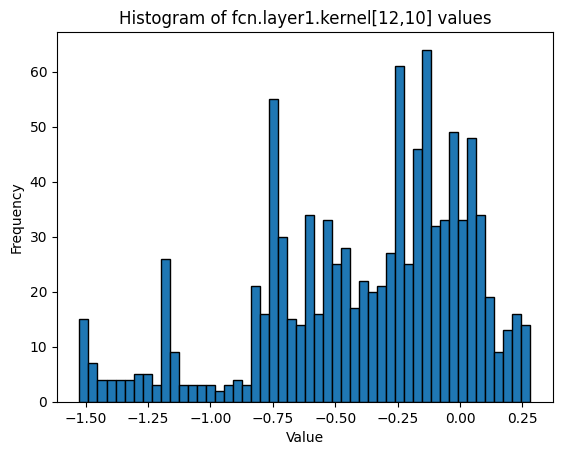

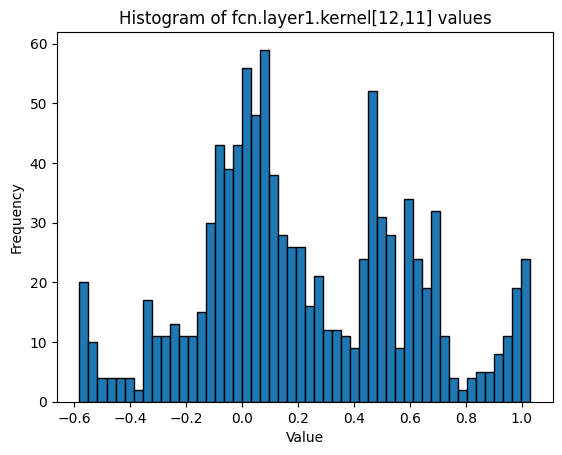

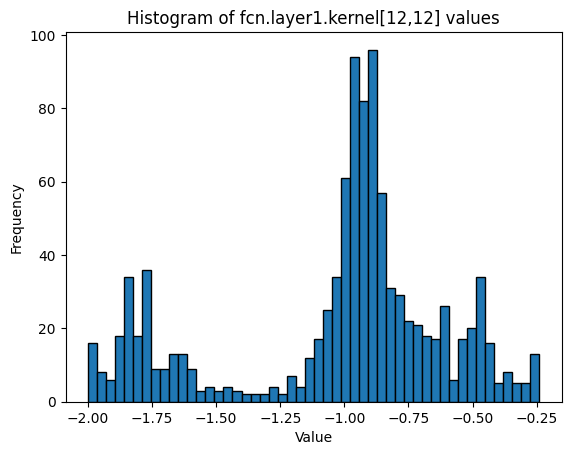

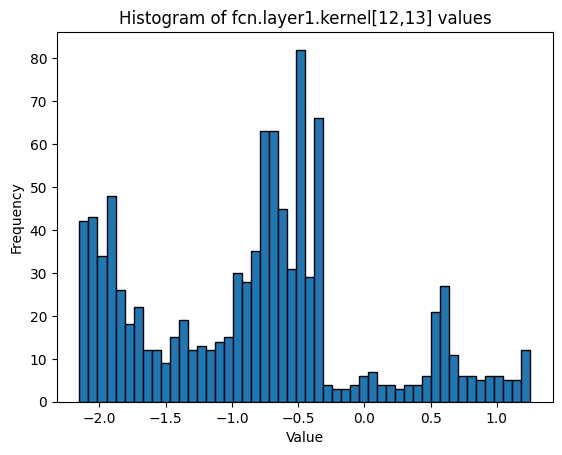

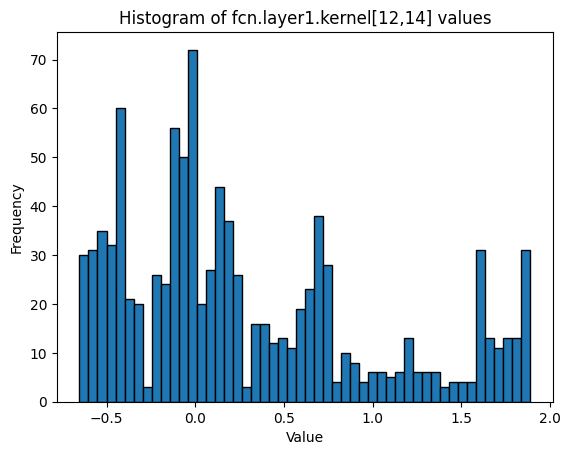

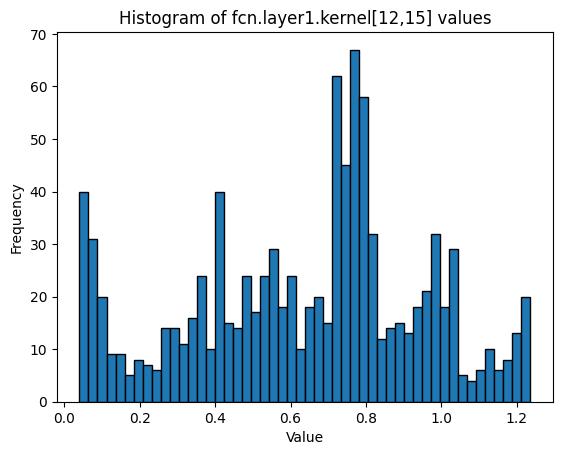

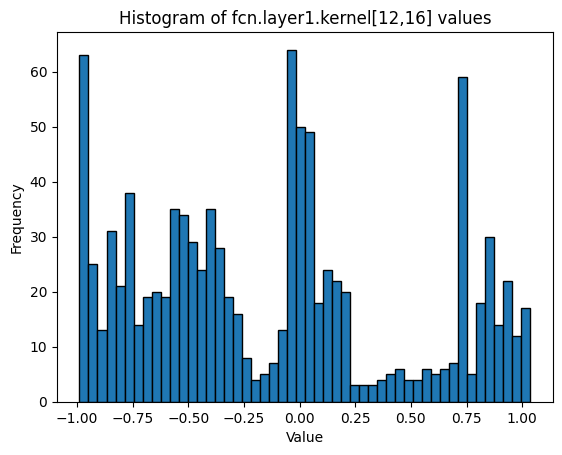

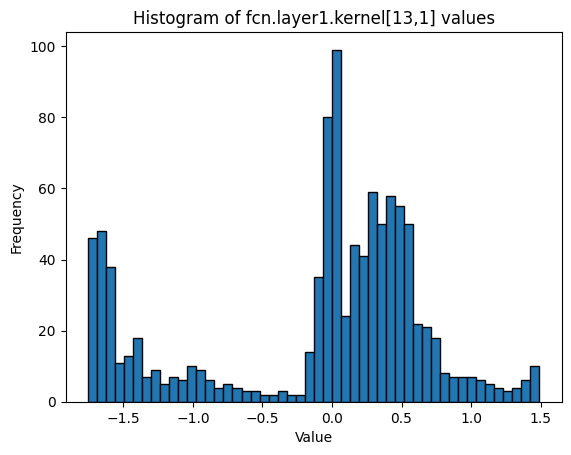

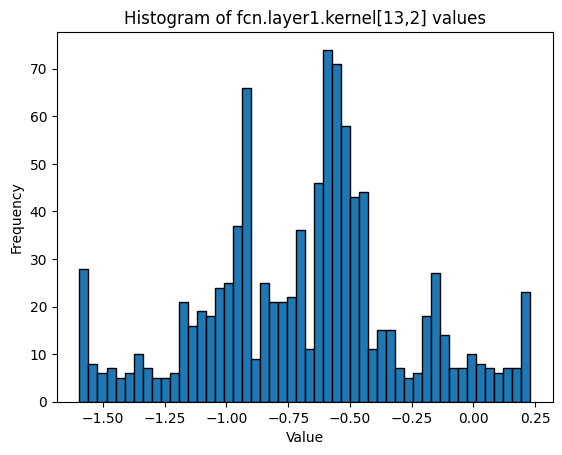

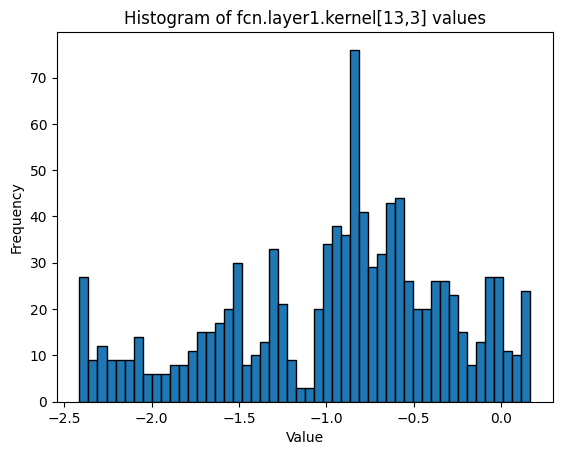

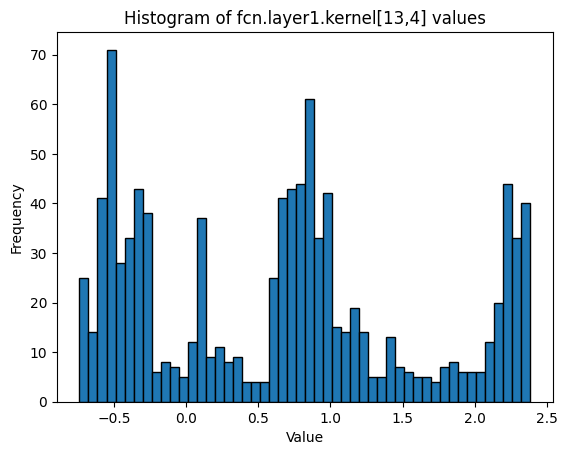

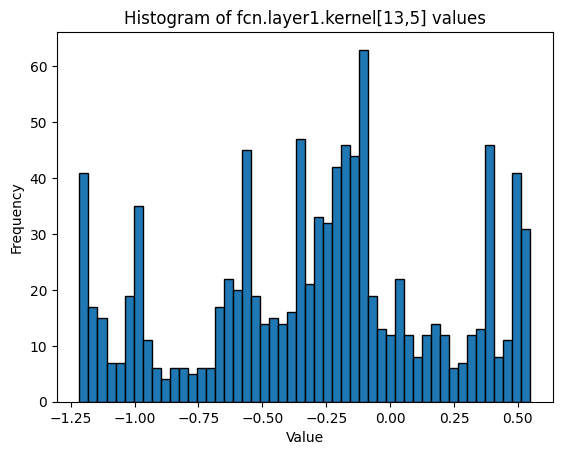

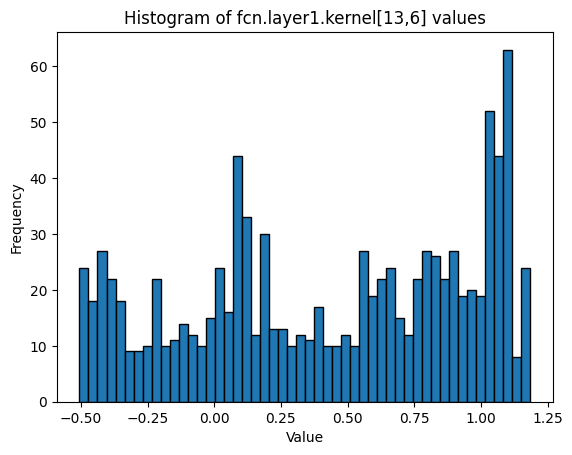

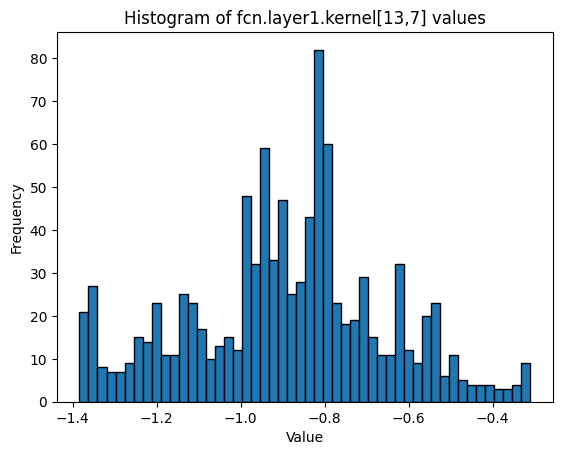

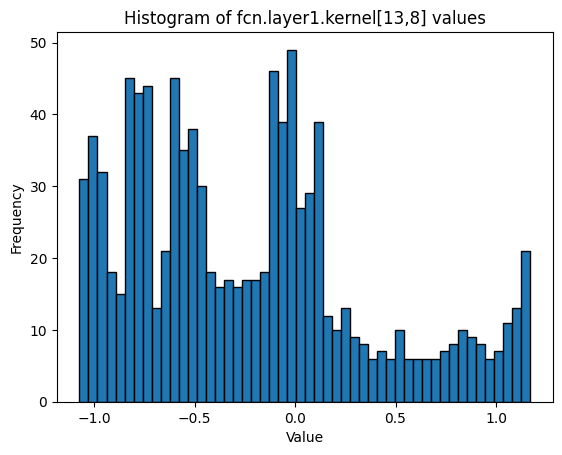

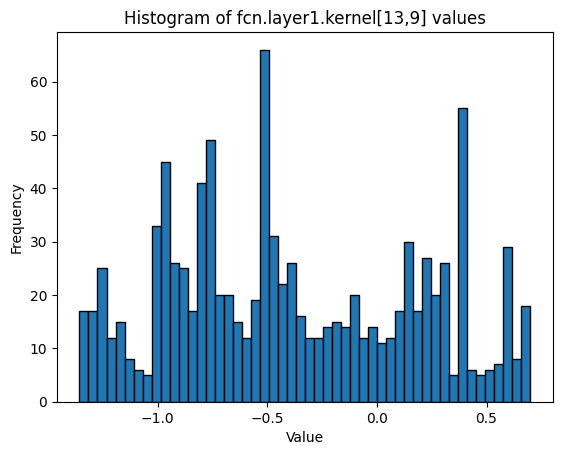

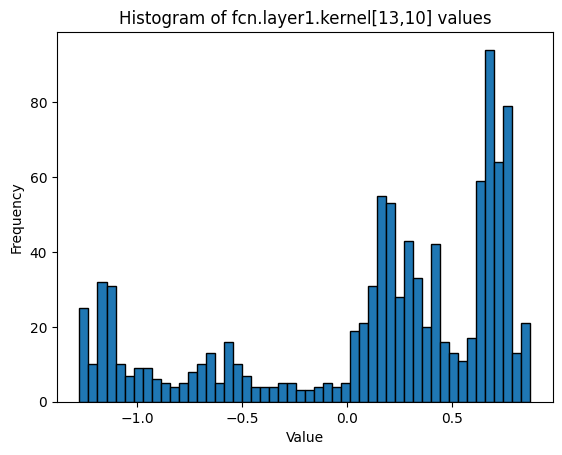

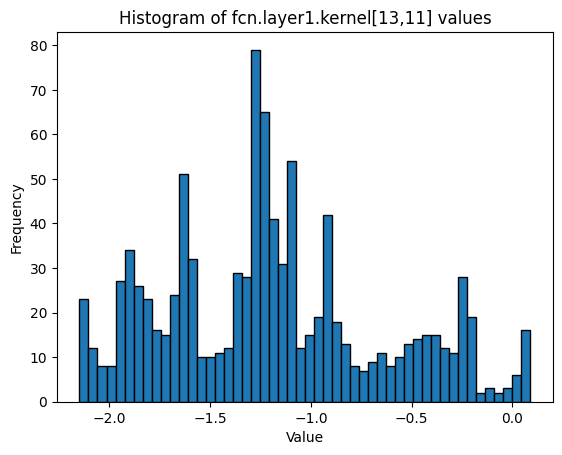

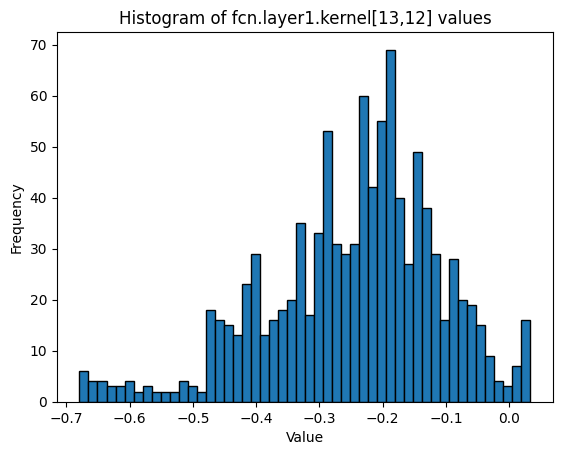

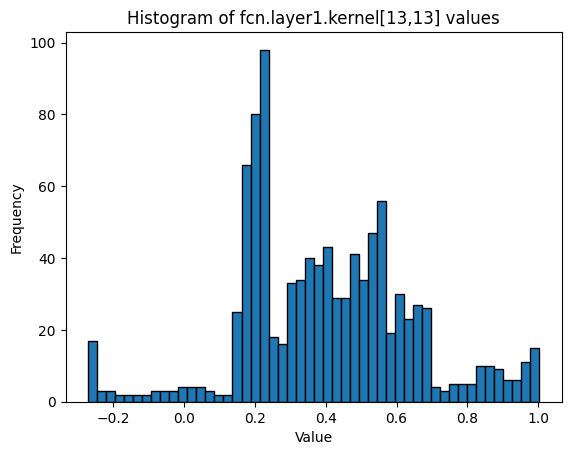

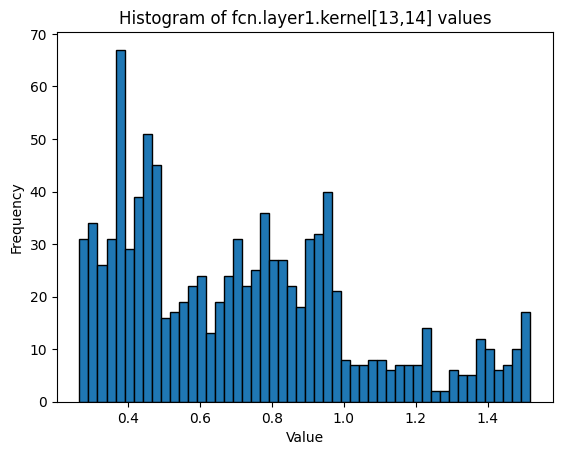

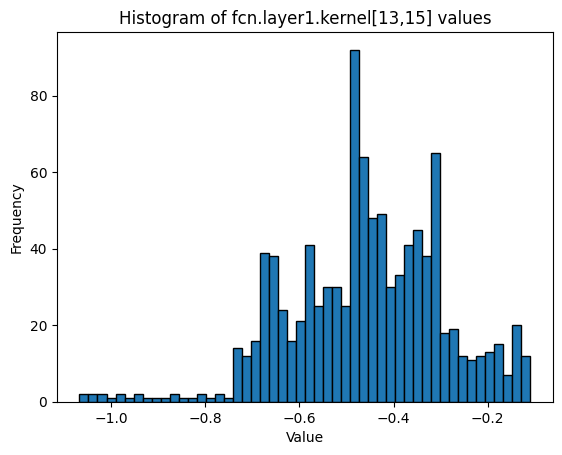

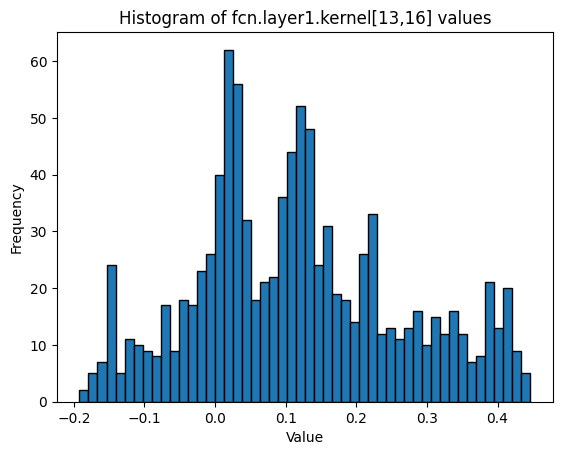

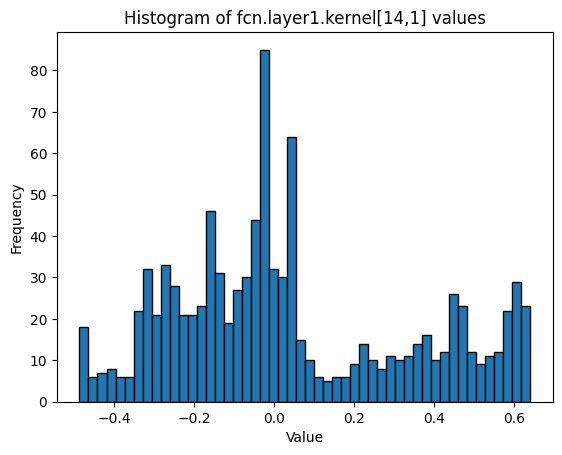

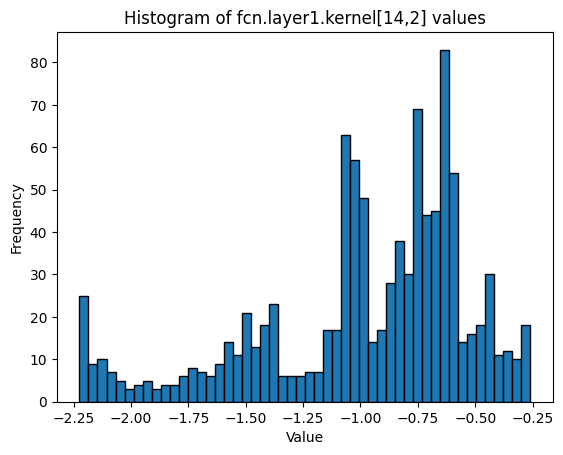

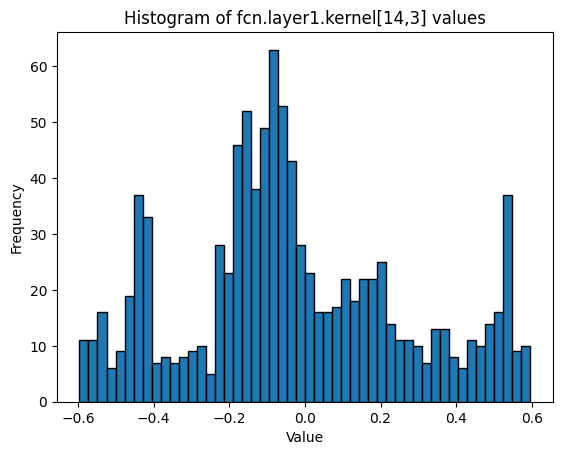

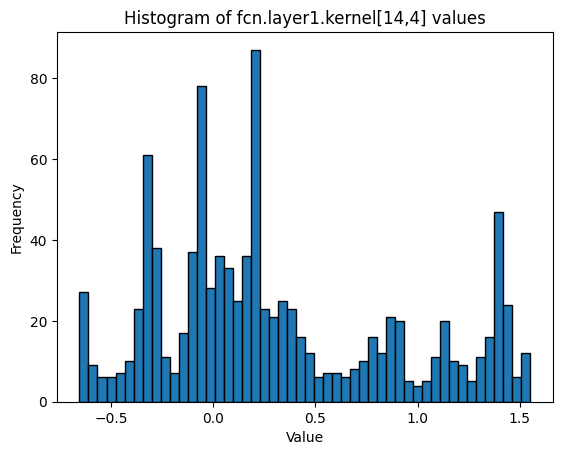

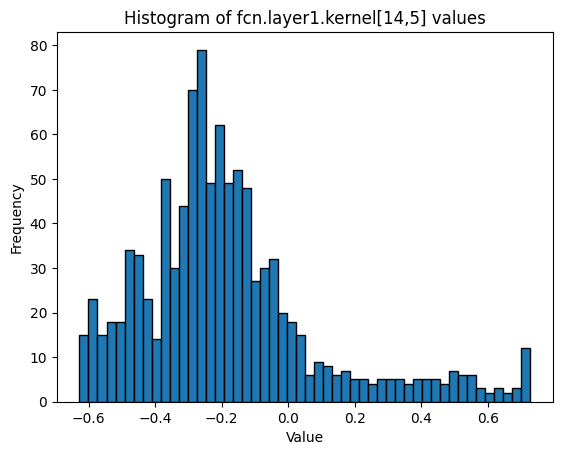

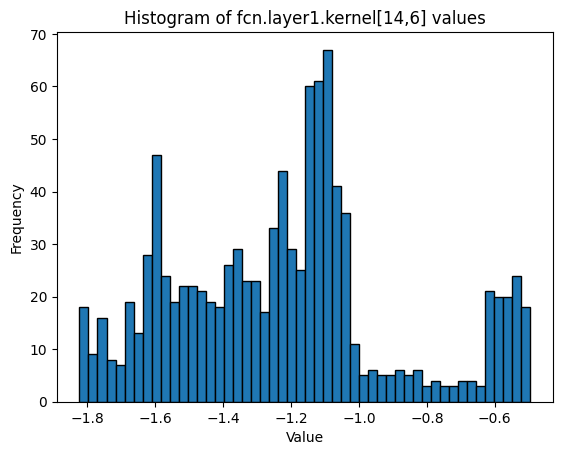

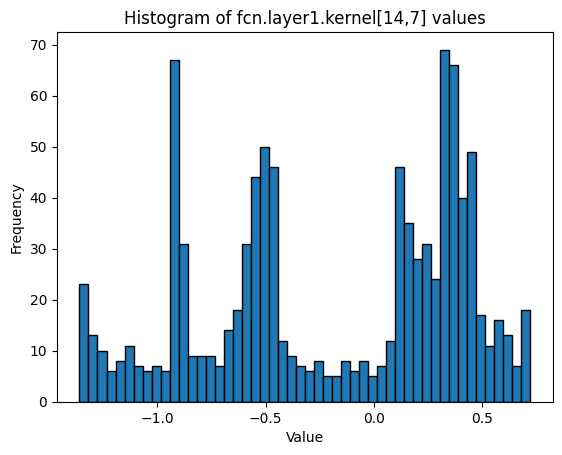

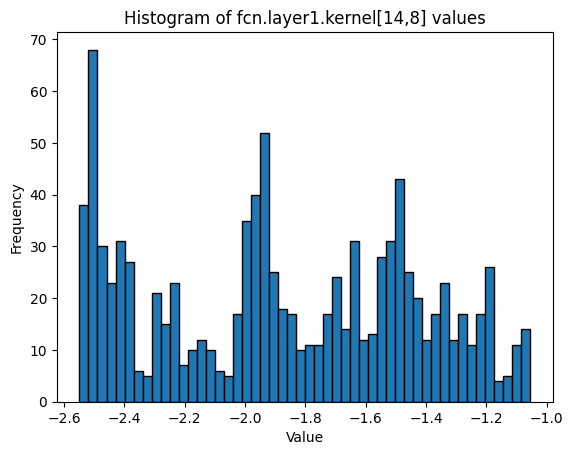

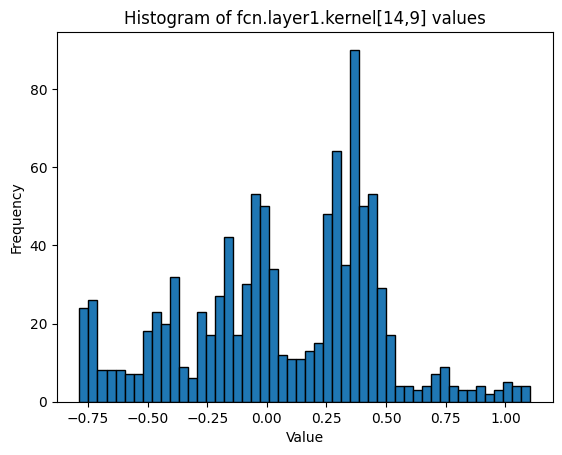

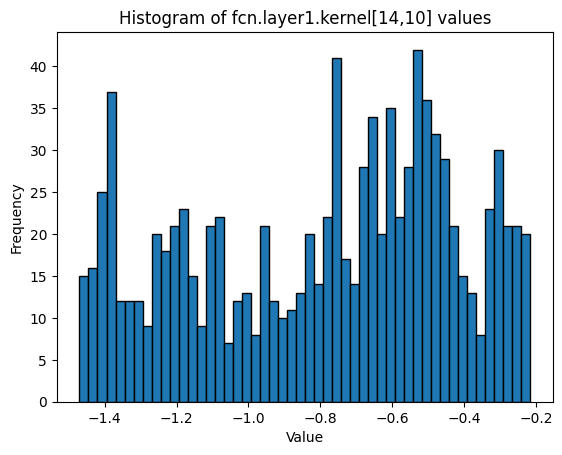

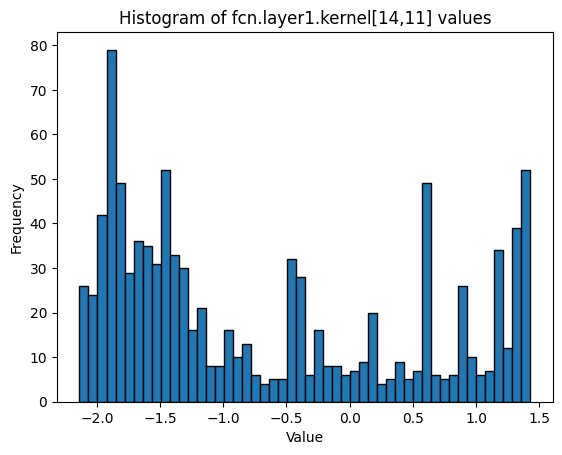

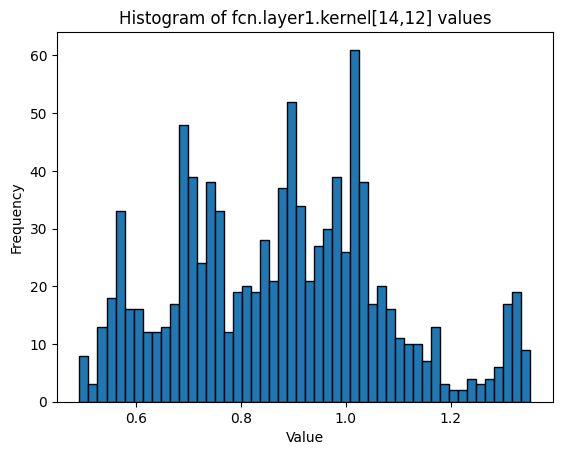

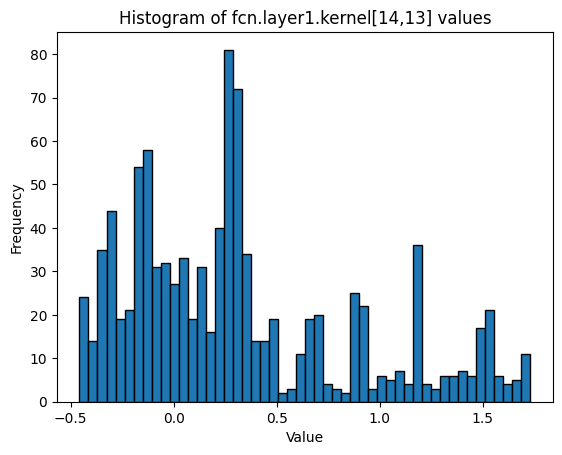

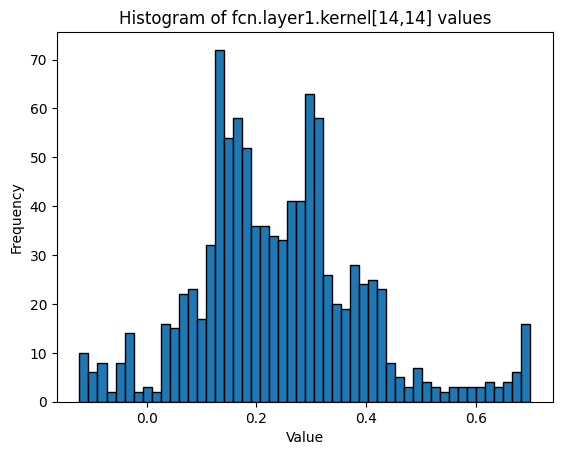

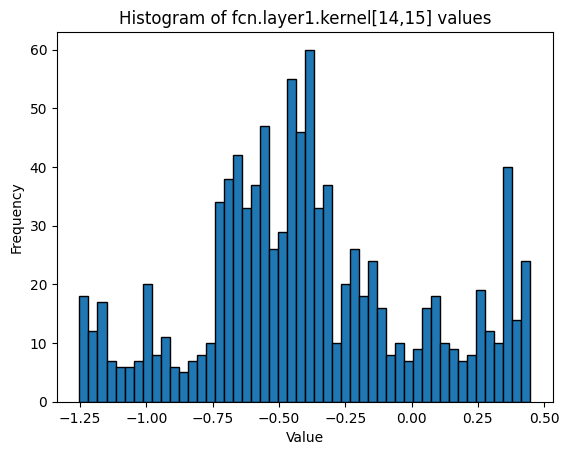

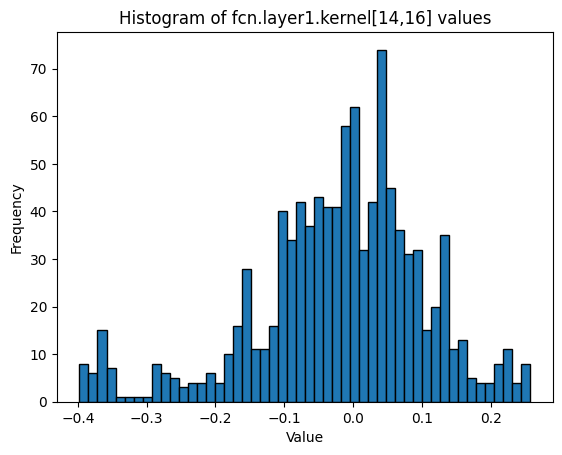

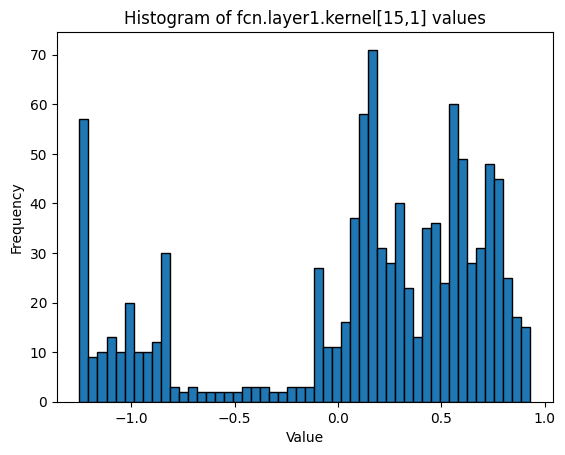

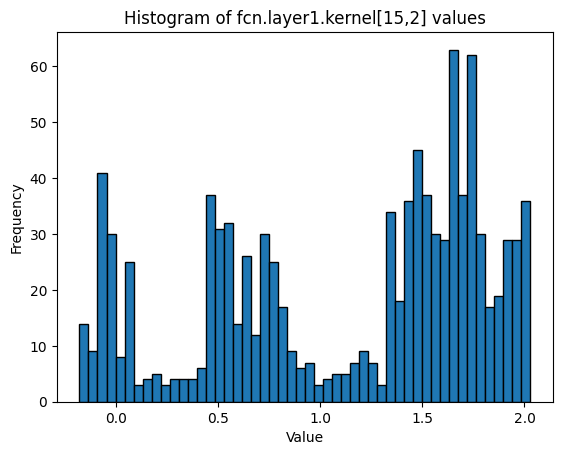

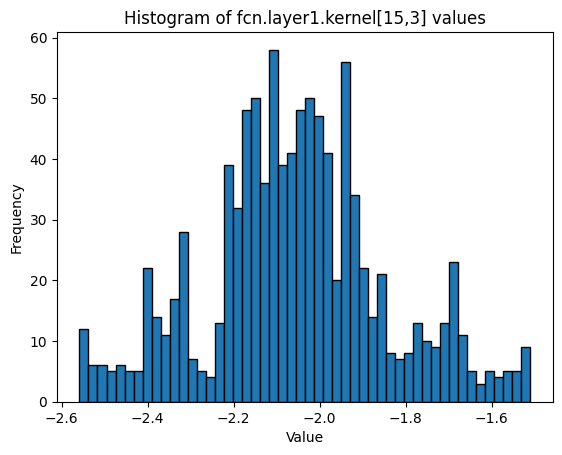

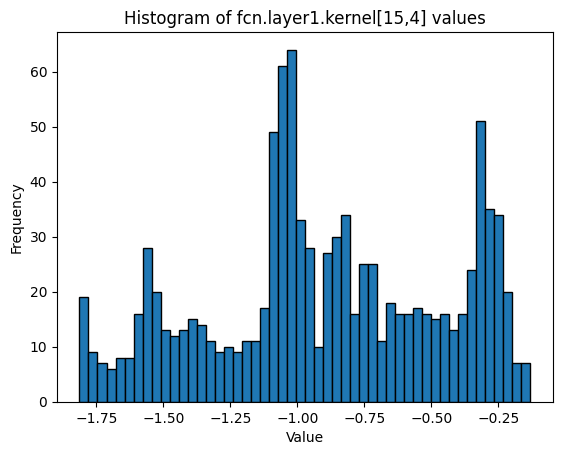

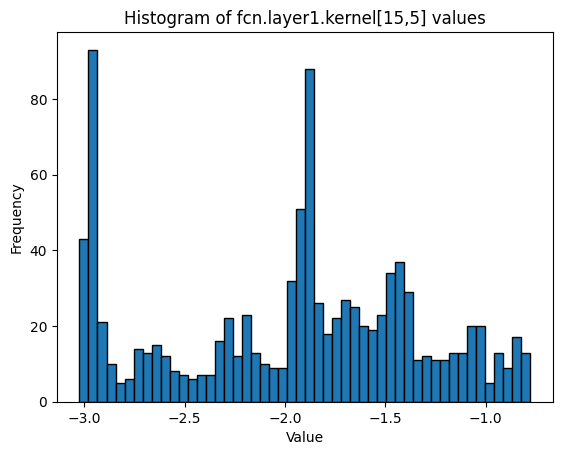

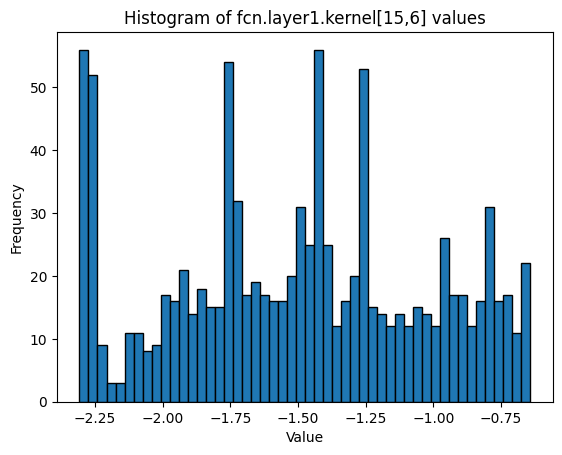

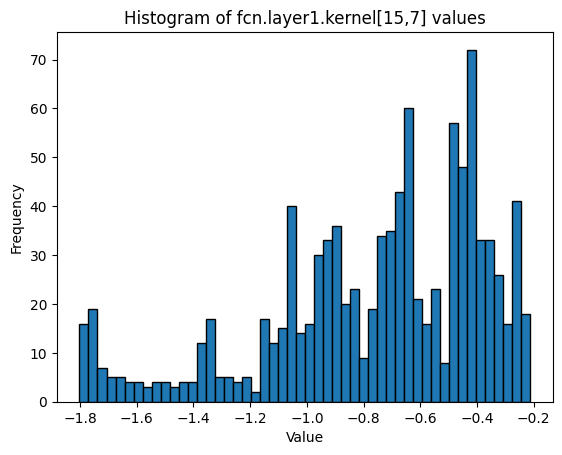

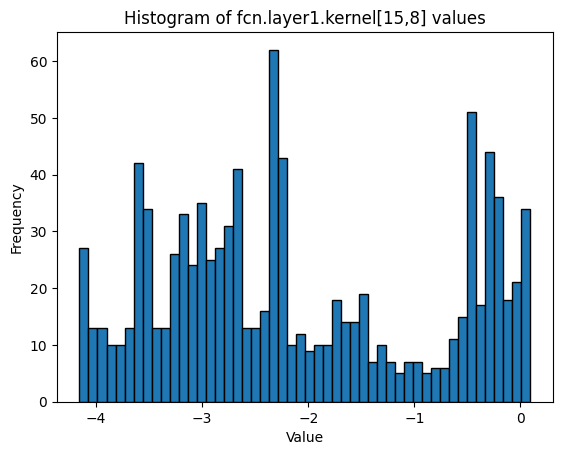

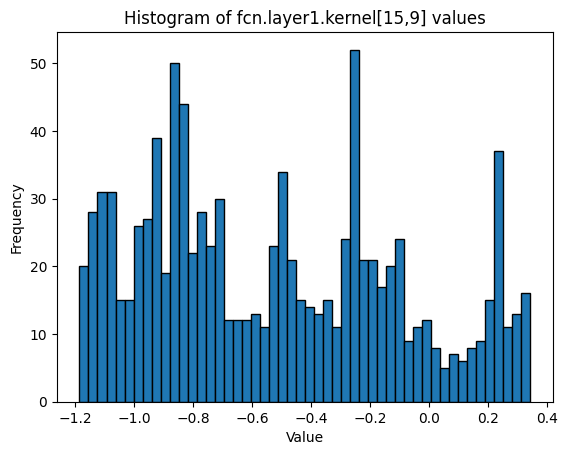

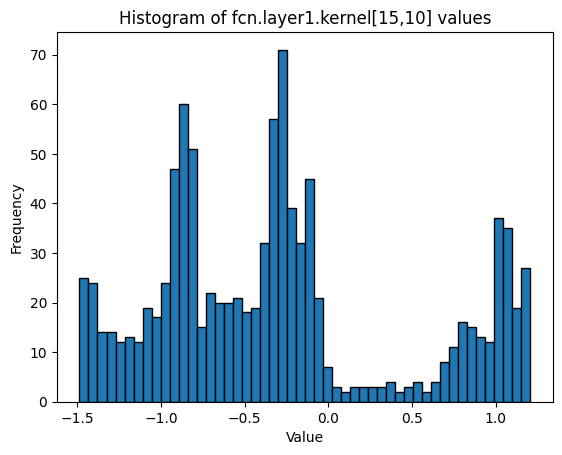

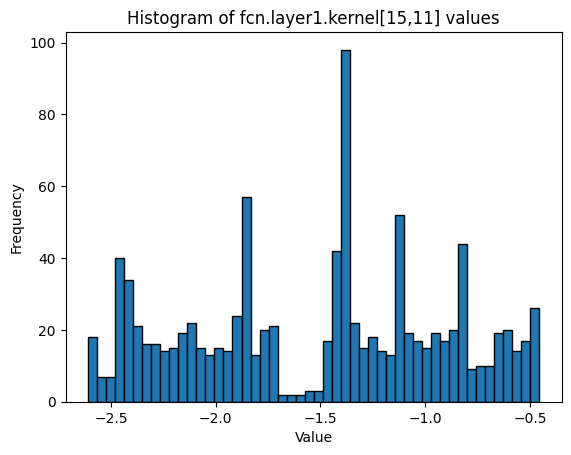

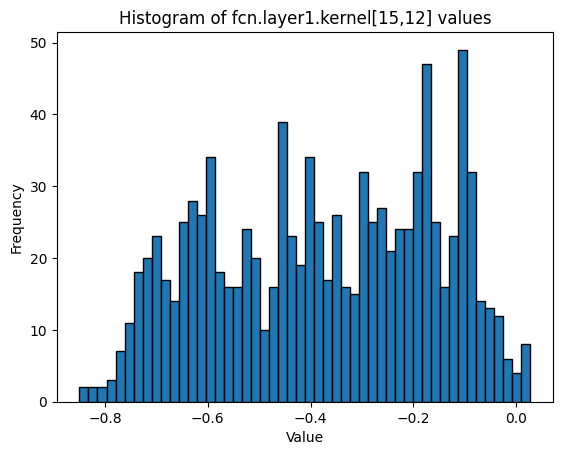

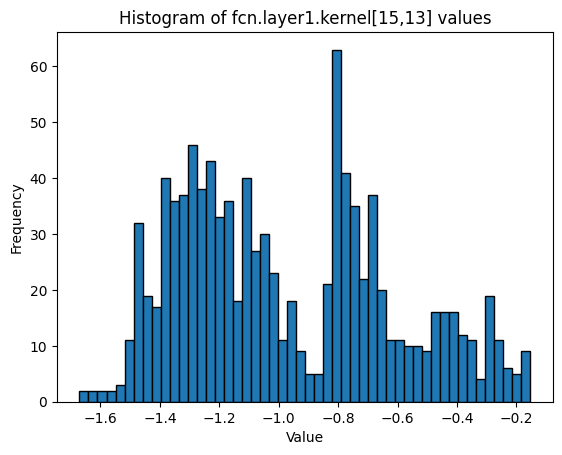

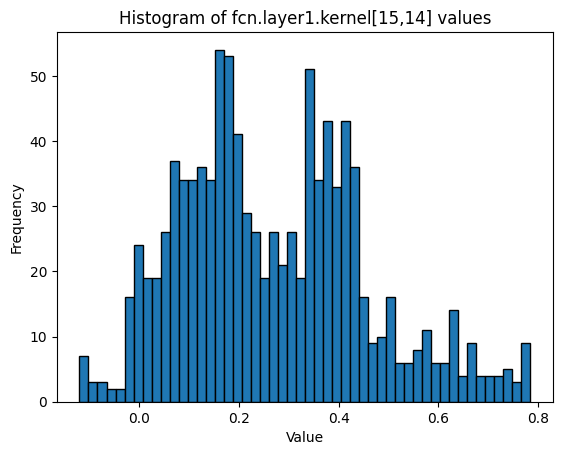

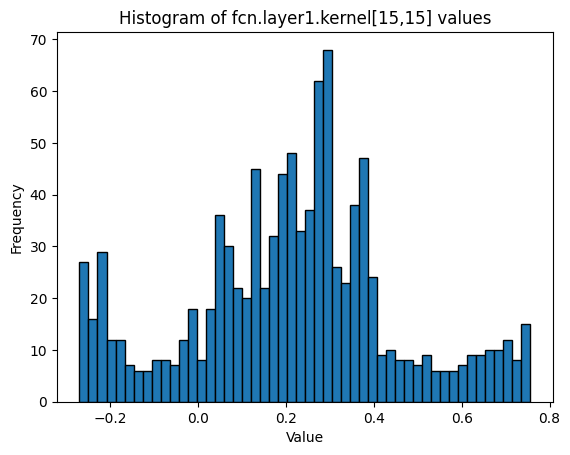

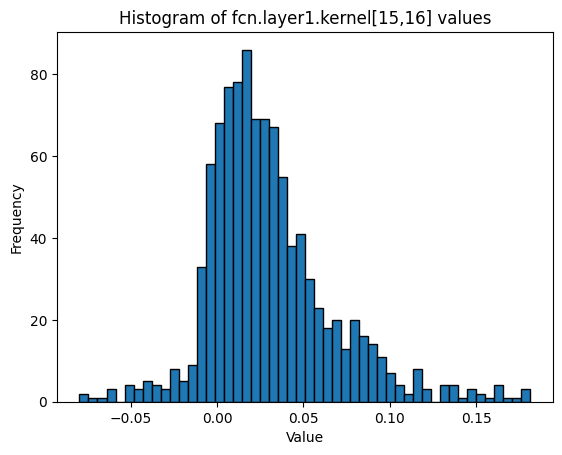

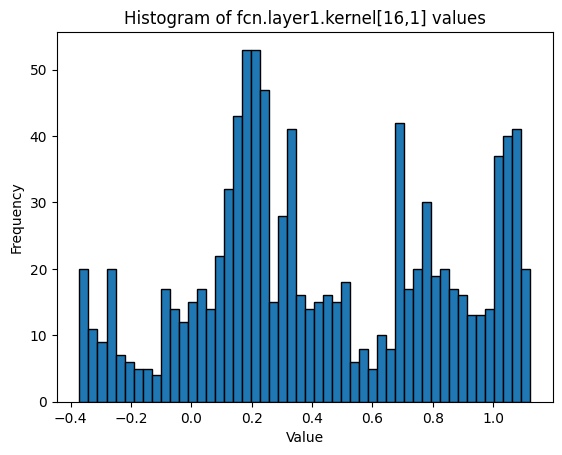

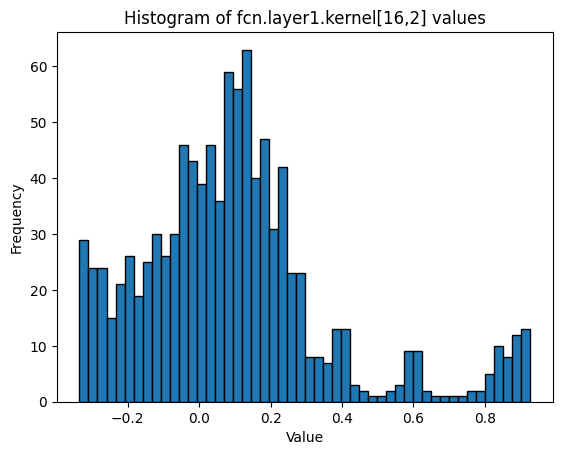

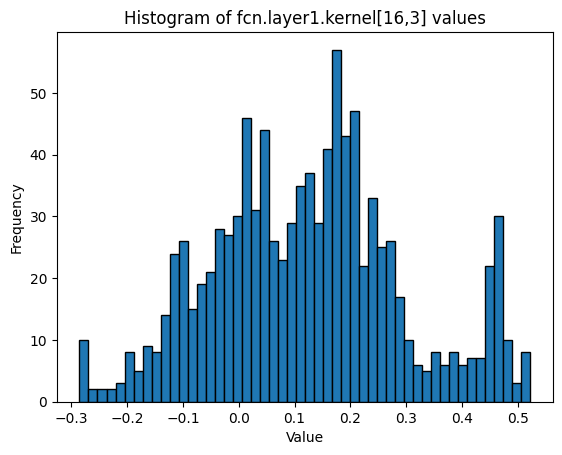

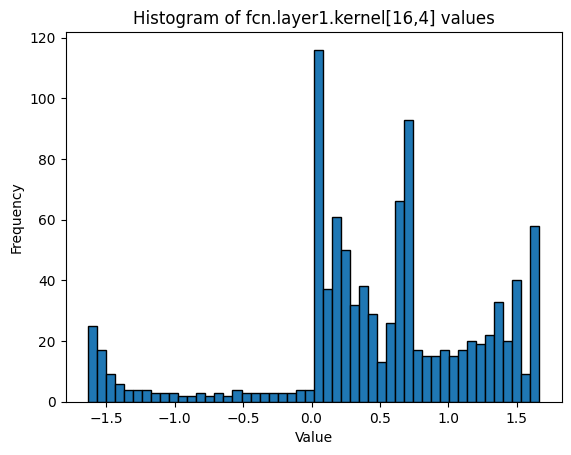

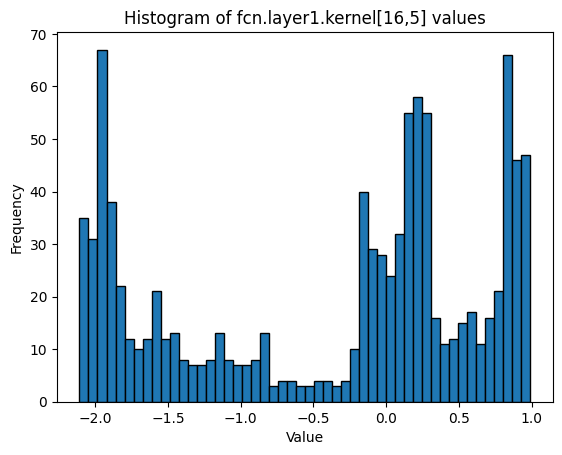

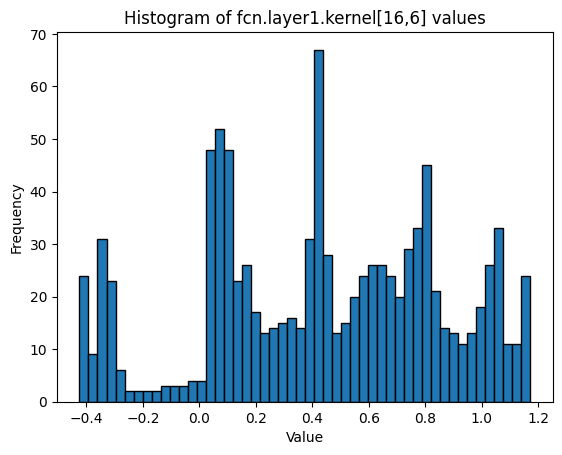

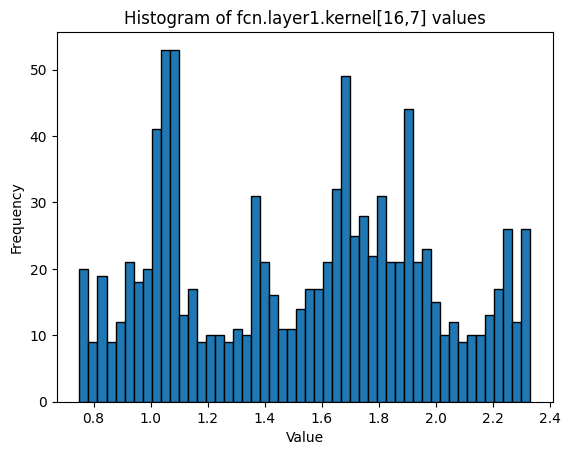

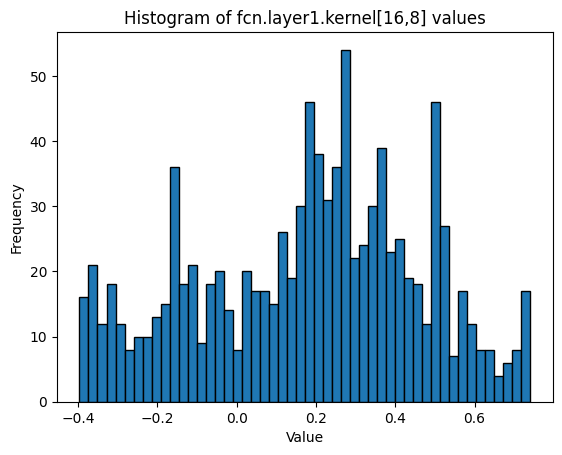

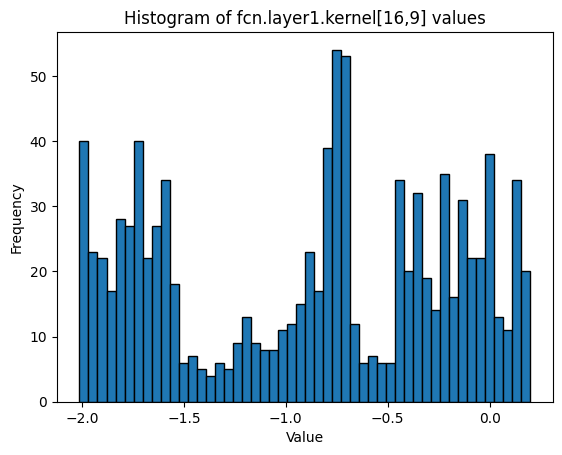

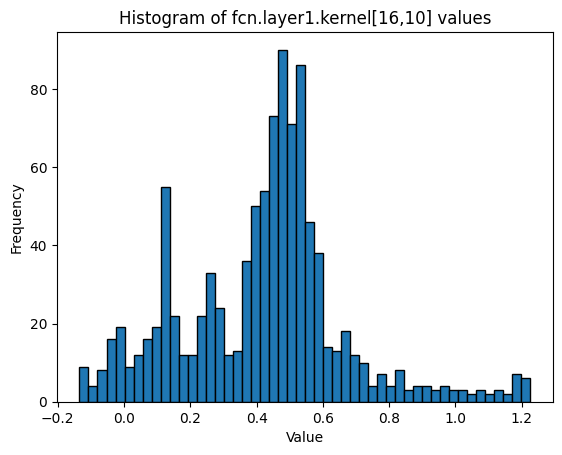

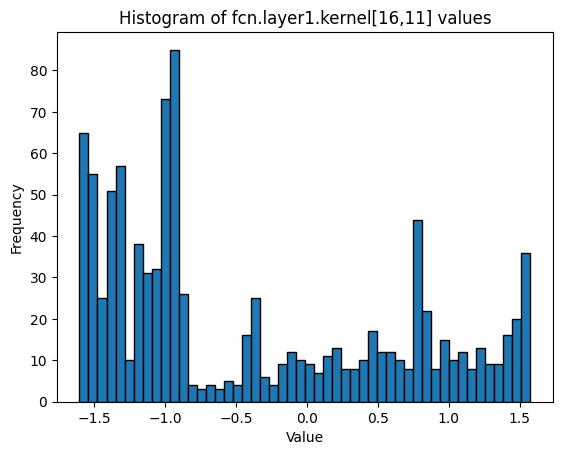

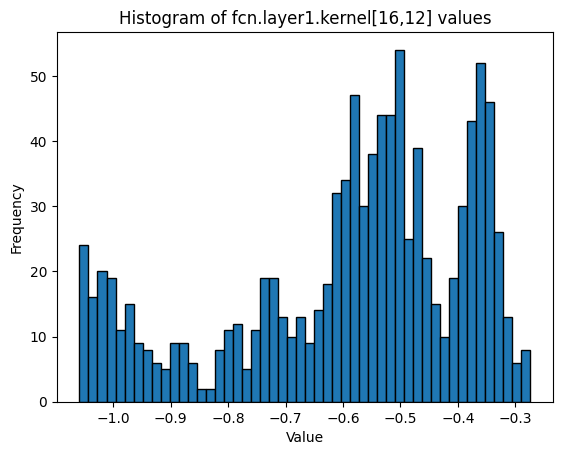

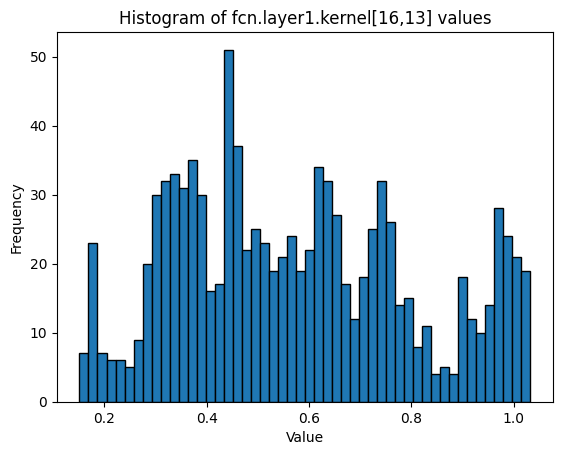

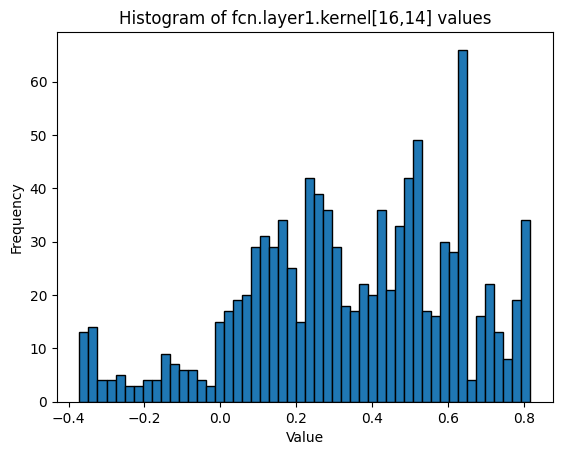

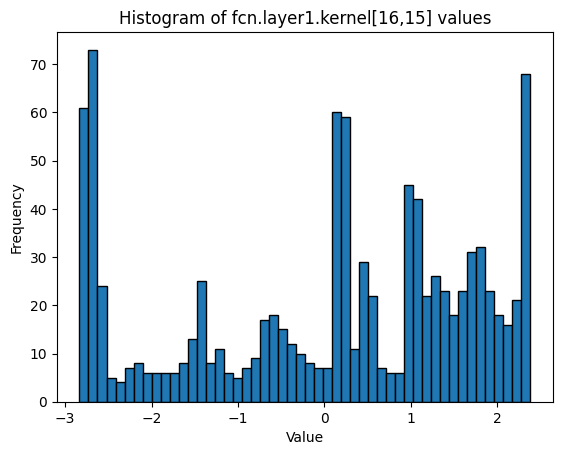

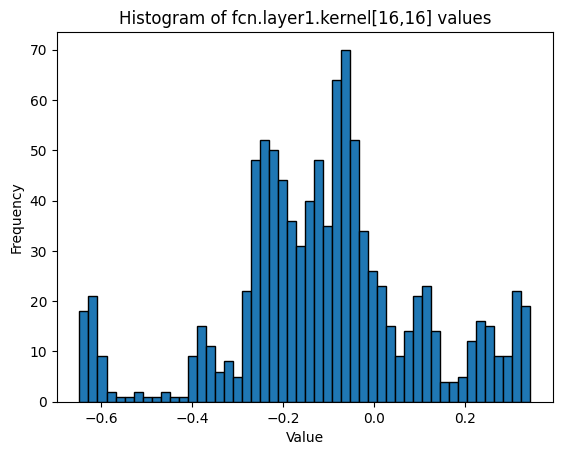

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Path to the directory containing the npz files
directory = 'results/repl_uci/mclmc_energy_true/samples/0'

# Initialize a dictionary to store the kernel values for each position
kernel_values = { (i, j): [] for i in range(16) for j in range(16) }

# Iterate over the npz files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.npz'):
        filepath = os.path.join(directory, filename)
        data = np.load(filepath)
        kernel = data['fcn.layer1.kernel']
        for i in range(16):
            for j in range(16):
                kernel_values[(i, j)].append(kernel[i, j])

# Plot histograms for each position in the kernel
for i in range(16):
    for j in range(16):
        plt.figure()
        plt.hist(kernel_values[(i, j)], bins=50, edgecolor='k')
        plt.title(f'Histogram of fcn.layer1.kernel[{i+1},{j+1}] values')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.show()

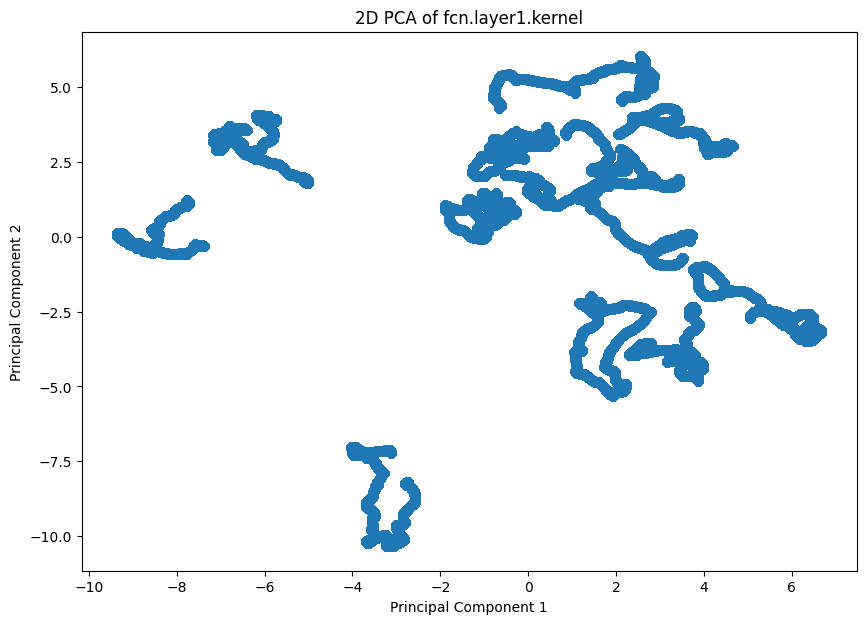

In [6]:
from sklearn.decomposition import PCA

# Initialize a list to store all kernel values
all_kernel_values = []

# Iterate over the chains and samples to collect the kernel values
for chain in range(12):
    for sample in range(1000):
        for filename in os.listdir(f'./results/repl_uci/mclmc_energy_true/samples/{chain}'):
            if filename.endswith('.npz'):
                filepath = os.path.join(f'./results/repl_uci/mclmc_energy_true/samples/{chain}', filename)
                data = np.load(filepath)
                kernel = data['fcn.layer1.kernel']
                all_kernel_values.append(kernel.flatten())

# Convert the list to a numpy array
all_kernel_values = np.array(all_kernel_values)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(all_kernel_values)

# Plot the PCA result
plt.figure(figsize=(10, 7))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
plt.title('2D PCA of fcn.layer1.kernel')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()